# <center> Final project

### <center> Resume recommender system
<center> <img src=https://media.licdn.com/dms/image/C5612AQEg5ghSochF8Q/article-cover_image-shrink_720_1280/0/1632544677267?e=2147483647&v=beta&t=1_Hpp19AXksV23OSE3z1Tpw35J6_P17WvA4pvNTmYHA align="center" width="300"/> </center>

**Business Task**:
To create a recommender system that recommends the best-matched resumes to vacancy.

*Description of business situation*: it is a big company. There are a lot of open vacancies (corresponds to different job positions) and pull of resumes (HR specialist has already collected them). Now HR specialist needs to find the best candidate for vacancy from these pull of resumes.

**Technical Task**
* Using Natural Language Processing (NLP) techniques to process resumes and job listings and sort resumes by similarity score in descending order, to create this ultimate resume screening tool.

**Type of ML task**
* Recommender System based on similarity score
* Dimensionality reduction by SVD/ TSNE (for visualization) + Clustering (Kmeans, DBSCAN, Agglomerative clustering) + Recommender System based on similarity score
* Topic modeling (NMF) + Recommender System based on similarity score

**Metrics:**
* Recommender System: cosine similarity 
* Clustering: Silhouette coefficient, Gap statistic - to get optimal number of clusters
* Topic modeling (NMF): coherence score - to evaluate the best number of topics

**Data:** The dataset was found on Kaggle, with a total of 8,653 entries of applicant experiences and ~80K job listings (before dataset cleaning stage)

*I run it based on Kaggle resources (without accelerator)*

# 0. Install and Import

In [1]:
# Install libs
!pip install kneed
!pip install wordcloud

# Import libs
import os
import pandas as pd
import numpy as np
import re # regular expression
import pickle # for save model/ data

from collections import Counter, defaultdict
from operator import itemgetter
from time import time

# Libs for visualization
import matplotlib.pyplot as plt
import seaborn as sns
import folium # map visualization
import wordcloud
from kneed import KneeLocator # Knee-point detection

# Text preprocessing
import nltk
import subprocess

# Download and unzip wordnet
try:
    nltk.data.find("wordnet.zip")
except:
    nltk.download("wordnet", download_dir="/kaggle/working/")
    command = "unzip /kaggle/working/corpora/wordnet.zip -d /kaggle/working/corpora"
    subprocess.run(command.split())
    nltk.data.path.append("/kaggle/working/")
    
from nltk.corpus import wordnet
from nltk.stem import WordNetLemmatizer
from nltk.corpus import stopwords #list of lexical stop words
from nltk import word_tokenize, pos_tag, pos_tag_sents
nltk.download("stopwords")
from sklearn.feature_extraction.text import TfidfVectorizer
from string import punctuation #sets of punctuation

# Metrics
from scipy.stats import normaltest # D'Agostino's K-squared test
from sklearn.metrics.pairwise import linear_kernel
from sklearn.metrics import silhouette_score, pairwise_distances
from gensim.models.coherencemodel import CoherenceModel

# Dimensionality reduction
from sklearn.decomposition import TruncatedSVD
from sklearn.manifold import TSNE

# Clustering algorithms, Topic modeling
from sklearn.cluster import KMeans, MiniBatchKMeans, DBSCAN, AgglomerativeClustering
from sklearn.mixture import GaussianMixture
from sklearn.neighbors import NearestNeighbors
from sklearn.decomposition import NMF
from gensim.models.nmf import Nmf
from gensim import corpora
from gensim.corpora.dictionary import Dictionary

import warnings
warnings.filterwarnings("ignore")

# Input data files are available in the read-only "../input/" directory
for dirname, _, filenames in os.walk("/kaggle/input"):
    for filename in filenames:
        print(os.path.join(dirname, filename))

[nltk_data] Downloading package wordnet to /kaggle/working/...
Archive:  /kaggle/working/corpora/wordnet.zip
   creating: /kaggle/working/corpora/wordnet/
  inflating: /kaggle/working/corpora/wordnet/lexnames  
  inflating: /kaggle/working/corpora/wordnet/data.verb  
  inflating: /kaggle/working/corpora/wordnet/index.adv  
  inflating: /kaggle/working/corpora/wordnet/adv.exc  
  inflating: /kaggle/working/corpora/wordnet/index.verb  
  inflating: /kaggle/working/corpora/wordnet/cntlist.rev  
  inflating: /kaggle/working/corpora/wordnet/data.adj  
  inflating: /kaggle/working/corpora/wordnet/index.adj  
  inflating: /kaggle/working/corpora/wordnet/LICENSE  
  inflating: /kaggle/working/corpora/wordnet/citation.bib  
  inflating: /kaggle/working/corpora/wordnet/noun.exc  
  inflating: /kaggle/working/corpora/wordnet/verb.exc  
  inflating: /kaggle/working/corpora/wordnet/README  
  inflating: /kaggle/working/corpora/wordnet/index.sense  
  inflating: /kaggle/working/corpora/wordnet/data.

In [2]:
# Fixing RANDOM_SEED to make experiment repetable
RANDOM_SEED = 42

# Fixing package versions to make experiment repetable
!pip freeze > requirements.txt

In [3]:
# Load datasets
DATA_DIR = "/kaggle/input/job-recommendation-datasets/" #"data/"

job_description = pd.read_csv(DATA_DIR+"Combined_Jobs_Final.csv")
position_of_interest = pd.read_csv(DATA_DIR +"Positions_Of_Interest.csv") # position of interest
job_data = pd.read_csv(DATA_DIR+"job_data.csv") # job data
resumes = pd.read_csv(DATA_DIR+"Experience.csv") # experience of candidate
job_views = pd.read_csv(DATA_DIR+"Job_Views.csv") # job views

#### Let's look at the content of each datasets

In [4]:
# Vacancies information (full version)
display(job_description.head(2))
print(f"\nNumber of rows and columns in dataset: {job_description.shape}")

,Job.ID,Provider,Status,Slug,Title,Position,Company,City,State.Name,State.Code,...,Industry,Job.Description,Requirements,Salary,Listing.Start,Listing.End,Employment.Type,Education.Required,Created.At,Updated.At
0,111,1,open,palo-alto-ca-tacolicious-server,Server @ Tacolicious,Server,Tacolicious,Palo Alto,California,CA,...,Food and Beverages,Tacolicious' first Palo Alto store just opened...,NaN,8.0,NaN,NaN,Part-Time,NaN,2013-03-12 02:08:28 UTC,2014-08-16 15:35:36 UTC
1,113,1,open,san-francisco-ca-claude-lane-kitchen-staff-chef,Kitchen Staff/Chef @ Claude Lane,Kitchen Staff/Chef,Claude Lane,San Francisco,California,CA,...,Food and Beverages,\r\n\r\nNew French Brasserie in S.F. Financia...,NaN,0.0,NaN,NaN,Part-Time,NaN,2013-04-12 08:36:36 UTC,2014-08-16 15:35:36 UTC



Number of rows and columns in dataset: (84090, 23)


In [5]:
# Applicant's position of interest
display(position_of_interest.head(2))
print(f"\nNumber of rows and columns in dataset: {position_of_interest.shape}")

,Applicant.ID,Position.Of.Interest,Created.At,Updated.At
0,10003,security officer,2014-12-12 21:20:54 UTC,2014-12-12 21:20:54 UTC
1,10007,Server,2014-08-14 15:56:42 UTC,2015-02-26 20:35:12 UTC



Number of rows and columns in dataset: (6560, 4)


In [6]:
# Short version of vacancy dataset: Job_ID and merged information from Job_title and Job_description
# it's look like cleaned vacancy dataset
display(job_data.head(2))
print(f"\nNumber of rows and columns in dataset: {job_data.shape}")

,Unnamed: 0,Job.ID,text
0,0,111,server tacolici palo alto part time tacolici f...
1,1,113,kitchen staff chef claud lane san francisco pa...



Number of rows and columns in dataset: (84090, 3)


In [7]:
# Resumes dataset
display(resumes.head(5))
print(f"\nNumber of rows and columns in dataset: {resumes.shape}")

,Applicant.ID,Position.Name,Employer.Name,City,State.Name,State.Code,Start.Date,End.Date,Job.Description,Salary,Can.Contact.Employer,Created.At,Updated.At
0,10001,Account Manager / Sales Administration / Quali...,Barcode Resourcing,Bellingham,Washington,WA,2012-10-15,NaN,NaN,NaN,NaN,2014-12-12 20:10:02 UTC,2014-12-12 20:10:02 UTC
1,10001,Electronics Technician / Item Master Controller,Ryzex Group,Bellingham,Washington,WA,2001-12-01,2012-04-01,NaN,NaN,NaN,2014-12-12 20:10:02 UTC,2014-12-12 20:10:02 UTC
2,10001,Machine Operator,comptec inc,Custer,Washington,WA,1997-01-01,1999-01-01,NaN,NaN,NaN,2014-12-12 20:10:02 UTC,2014-12-12 20:10:02 UTC
3,10003,maintenance technician,Winn residental,washington,District of Columbia,DC,NaN,NaN,"Necessary maintenance for ""Make Ready"" Plumbin...",10.0,False,2014-12-12 21:27:05 UTC,2014-12-12 21:27:05 UTC
4,10003,Electrical Helper,michael and son services,alexandria,Virginia,VA,NaN,NaN,repair and services of electrical construction,NaN,False,2014-12-12 21:27:05 UTC,2014-12-12 21:27:05 UTC



Number of rows and columns in dataset: (8653, 13)


In [8]:
# Information about Job views by Applicant
display(job_views.head(5))
print(f"\nNumber of rows and columns in dataset: {job_views.shape}")

,Applicant.ID,Job.ID,Title,Position,Company,City,State.Name,State.Code,Industry,View.Start,View.End,View.Duration,Created.At,Updated.At
0,10000,73666,Cashiers & Valets Needed! @ WallyPark,Cashiers & Valets Needed!,WallyPark,Newark,New Jersey,NJ,NaN,2014-12-12 20:12:35 UTC,2014-12-12 20:31:24 UTC,1129.0,2014-12-12 20:12:35 UTC,2014-12-12 20:12:35 UTC
1,10000,96655,Macy's Seasonal Retail Fragrance Cashier - Ga...,Macy's Seasonal Retail Fragrance Cashier - Ga...,Macy's,Garden City,New York,NY,NaN,2014-12-12 20:08:50 UTC,2014-12-12 20:10:15 UTC,84.0,2014-12-12 20:08:50 UTC,2014-12-12 20:08:50 UTC
2,10001,84141,Part Time Showroom Sales / Cashier @ Grizzly I...,Part Time Showroom Sales / Cashier,Grizzly Industrial Inc.,Bellingham,Washington,WA,NaN,2014-12-12 20:12:32 UTC,2014-12-12 20:17:18 UTC,286.0,2014-12-12 20:12:32 UTC,2014-12-12 20:12:32 UTC
3,10002,77989,Event Specialist Part Time @ Advantage Sales &...,Event Specialist Part Time,Advantage Sales & Marketing,Simpsonville,South Carolina,SC,NaN,2014-12-12 20:39:23 UTC,2014-12-12 20:42:13 UTC,170.0,2014-12-12 20:39:23 UTC,2014-12-12 20:39:23 UTC
4,10002,69568,Bonefish - Kitchen Staff @ Bonefish Grill,Bonefish - Kitchen Staff,Bonefish Grill,Greenville,South Carolina,SC,NaN,2014-12-12 20:43:25 UTC,2014-12-12 20:43:58 UTC,33.0,2014-12-12 20:43:25 UTC,2014-12-12 20:43:25 UTC



Number of rows and columns in dataset: (12370, 14)


We have 5 datasets:
- Vacancies information (full version)
- Applicant's position of interest
- Short version of vacancy dataset: Job_ID and merged information from Job_title and Job_description
- Resumes dataset
- Information about Job views by Applicant

In this project I **use only 2 datasets**: *Vacancies* and *Resumes*.

- Dataset with job data looks like processed full version of vacancy dataset (it is not so interisting to get it for investigation).
- *Position of interest* is about prefereble job position for applicant. And as you can see sometimes applicant's job experience is different than position of interest. For example:
    - Applicant 10003: job experience as "*maintenance technician*" <-> position of interest "*security officer*"
- *Job views* describes information about job views by Applicant. Maybe this dataset will be useful for further investigation, but not in this case.

***

# 1. Checking datasets: missing values, duplicates, outliers

## <center> VACANCIES DATASET

### `Total information`

Let's read the dataset into the DataFrame *job_description* and will have a look at the *shape, columns, column data types and the first 5 rows of the data*.

This will give a brief overview of the data at hand.

In [9]:
# Reading csv-file
print(f"Data shape: {job_description.shape}\n")

display(job_description.head(5))
display(job_description.info())

Data shape: (84090, 23)



,Job.ID,Provider,Status,Slug,Title,Position,Company,City,State.Name,State.Code,...,Industry,Job.Description,Requirements,Salary,Listing.Start,Listing.End,Employment.Type,Education.Required,Created.At,Updated.At
0,111,1,open,palo-alto-ca-tacolicious-server,Server @ Tacolicious,Server,Tacolicious,Palo Alto,California,CA,...,Food and Beverages,Tacolicious' first Palo Alto store just opened...,NaN,8.00,NaN,NaN,Part-Time,NaN,2013-03-12 02:08:28 UTC,2014-08-16 15:35:36 UTC
1,113,1,open,san-francisco-ca-claude-lane-kitchen-staff-chef,Kitchen Staff/Chef @ Claude Lane,Kitchen Staff/Chef,Claude Lane,San Francisco,California,CA,...,Food and Beverages,\r\n\r\nNew French Brasserie in S.F. Financia...,NaN,0.00,NaN,NaN,Part-Time,NaN,2013-04-12 08:36:36 UTC,2014-08-16 15:35:36 UTC
2,117,1,open,san-francisco-ca-machka-restaurants-corp-barte...,Bartender @ Machka Restaurants Corp.,Bartender,Machka Restaurants Corp.,San Francisco,California,CA,...,Food and Beverages,We are a popular Mediterranean wine bar and re...,NaN,11.00,NaN,NaN,Part-Time,NaN,2013-07-16 09:34:10 UTC,2014-08-16 15:35:37 UTC
3,121,1,open,brisbane-ca-teriyaki-house-server,Server @ Teriyaki House,Server,Teriyaki House,Brisbane,California,CA,...,Food and Beverages,● Serve food/drinks to customers in a profess...,NaN,10.55,NaN,NaN,Part-Time,NaN,2013-09-04 15:40:30 UTC,2014-08-16 15:35:38 UTC
4,127,1,open,los-angeles-ca-rosa-mexicano-sunset-kitchen-st...,Kitchen Staff/Chef @ Rosa Mexicano - Sunset,Kitchen Staff/Chef,Rosa Mexicano - Sunset,Los Angeles,California,CA,...,Food and Beverages,"Located at the heart of Hollywood, we are one ...",NaN,10.55,NaN,NaN,Part-Time,NaN,2013-07-17 15:26:18 UTC,2014-08-16 15:35:40 UTC


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 84090 entries, 0 to 84089
Data columns (total 23 columns):
 #   Column              Non-Null Count  Dtype  
---  ------              --------------  -----  
 0   Job.ID              84090 non-null  int64  
 1   Provider            84090 non-null  int64  
 2   Status              84090 non-null  object 
 3   Slug                84090 non-null  object 
 4   Title               84090 non-null  object 
 5   Position            84090 non-null  object 
 6   Company             81819 non-null  object 
 7   City                83955 non-null  object 
 8   State.Name          83919 non-null  object 
 9   State.Code          83919 non-null  object 
 10  Address             36 non-null     object 
 11  Latitude            84090 non-null  float64
 12  Longitude           84090 non-null  float64
 13  Industry            267 non-null    object 
 14  Job.Description     84034 non-null  object 
 15  Requirements        0 non-null      float64
 16  Sala

None

### **Exploring the content of variables**

The dataset is dedicated to the vacancies and contains 84,090 rows and 23 columns.

Let's divide all features into 4 groups:
- job description
- candidate requirements
- location
- non-informative features

*Job description*:
- Job.ID: nominal, from 1-digit to 6-digit integral number uniquely assigned to each job posting's.
- Title: this column contains of information about job position and company name by "@" symbol ("Server @ Tacolicious")
- Position: job position
- Company: employer name
- Job.Description: description of job position
- Salary: numeric, salary per hour (/day)
- Employment.Type: type of employment
- Industry: industry of the company/ job
- Slug: this column contains of information about city name, state code, company and job position by "-" symbol ("palo-alto-ca-tacolicious-server")

*Candidate requirements*:
- Requirements: job requirements (for candidate). This columns is empty -> move it to *Non-informative features*
- Education.Required: required education level

*Location*:
- City: full name of city
- State.Name: full name of state
- State.Code: state abbreviations
- Address: address of the company
- Latitude: latitude of the company location
- Longitude: longitude of the company location

*Non-informative features*:
- Provider: nominal, 1-digit integral number. There are three variants: 1,2,3.
- Status: all rows have the same "status" value - *open*.
- Listing.Start: date objects
- Listing.End: date objects
- Created.At: date objects
- Updated.At: date objects

Some observations about the data:
* There are columns with duplicated information:
    - State.Name and State.Code
    - Slug
     
The most interesting groups for our task is *Job description* and *Candidate requirements*. Unfortunately, in further investigation I'll see that the last group's columns are empty or describes a small part of data.

In [10]:
"""
Define Unique categories in each column
"""
unique_list = []

for col in job_description.columns:
    # creating tuple: column name, number of unique values, type
    item = (col, job_description[col].nunique(), job_description[col].dtypes, job_description[col].unique())
    unique_list.append(item)
    
unique_counts = pd.DataFrame(
    unique_list,
    columns=["Column_Name", "Num_Unique", "Type", "Unique_category"]
).sort_values(by="Num_Unique")


display(unique_counts)

,Column_Name,Num_Unique,Type,Unique_category
15,Requirements,0,float64,[nan]
2,Status,1,object,[open]
1,Provider,3,int64,"[1, 2, 3]"
20,Education.Required,5,object,"[nan, Not Specified, High School Diploma, Mast..."
13,Industry,6,object,"[Food and Beverages, Retail, nan, Transportati..."
19,Employment.Type,8,object,"[Part-Time, Full-Time/Part-Time, Seasonal/Temp..."
10,Address,24,object,"[nan, 3600 Griffith Park Blvd, 565 Metro Place..."
16,Salary,26,float64,"[8.0, 0.0, 11.0, 10.55, nan, 10.0, 15.0, 19.0,..."
8,State.Name,51,object,"[California, New Jersey, Wisconsin, Illinois, ..."
9,State.Code,51,object,"[CA, NJ, WI, IL, KY, SC, PA, NC, OH, MN, MO, M..."


***

### Candidate requirements features

- Requirements
- Education.Required

*Requirements has only empty values. We should drop this column*

***

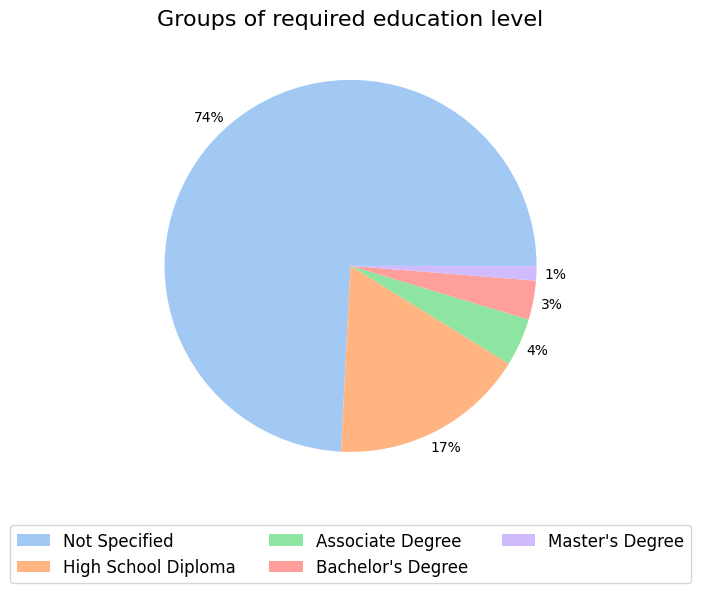

In [11]:
"""
Let's check unique categories in Education.Required column in details
"""
edu_level = job_description["Education.Required"].value_counts().reset_index()
edu_level.columns = ["Education.Required", "count"]

#define Seaborn color palette to use
colors = sns.color_palette("pastel")

#create pie chart
plt.figure(facecolor='white', figsize=(6,8))
plt.pie(edu_level["count"], colors = colors, autopct="%.0f%%", pctdistance=1.1)
plt.title("Groups of required education level", fontsize=16)
plt.legend(edu_level["Education.Required"], loc="upper center", bbox_to_anchor=(0.5, -0.04), ncol=3, fontsize=12)

plt.show()

Some observations:
* The most part of data has not specified information about education level - 75%

It means that this column will be useless during further investigation.

***

### Job description features
- Job.ID - each row describes each unique vacancy
- Position
- Company
- Job.Description
- Salary
- Employment.Type
- Industry

Title and Slug columns duplicate information from Position, Company, Location features. I guess that I won't use it in this study

***

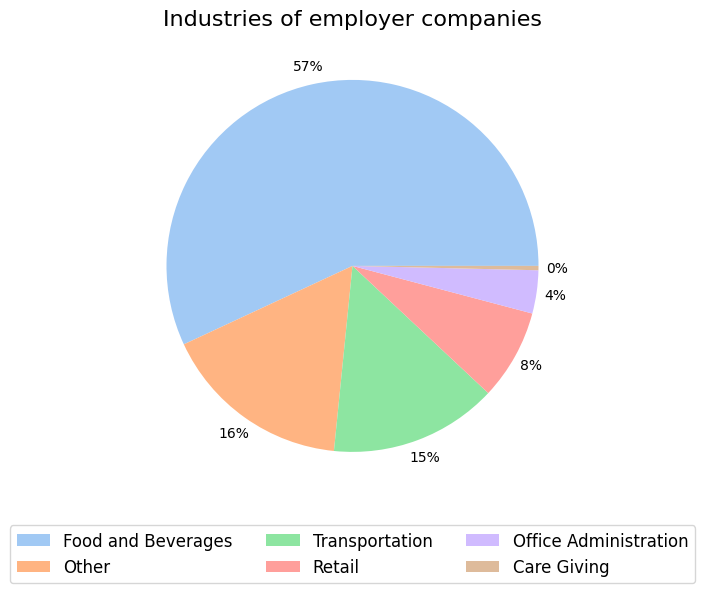

In [12]:
"""
Let's check unique categories in Industry column in details
"""
industry = job_description["Industry"].value_counts().reset_index()
industry.columns = ["Industry", "count"]

#define Seaborn color palette to use
colors = sns.color_palette("pastel")

#create pie chart
plt.figure(facecolor='white', figsize=(6,8))
plt.pie(industry["count"], colors=colors, autopct="%.0f%%", pctdistance=1.1)
plt.title("Industries of employer companies", fontsize=16)
plt.legend(industry["Industry"], loc="upper center", bbox_to_anchor=(0.5, -0.04), ncol=3, fontsize=12)

plt.show()

Some observations:
* Based at the pie chart, there are 5 unique industries:
    - Food and Beverages ~ 60%
    - Transportation - 15%
    - Retail - 8%
    - Office Administration - 4%
    - Care giving ~ less than 1%
* This column has only 267 not null data. It means that this feature is also useless for this study

In [13]:
"""
Let's check unique categories in Employment.Type column in details
"""
round(job_description["Employment.Type"].value_counts(normalize=True), 2)

Employment.Type
Part-Time              0.40
Seasonal/Temp          0.33
Full-Time/Part-Time    0.21
Per Diem               0.06
Intern                 0.01
Full-Time              0.00
Contract               0.00
Temporary/seasonal     0.00
Name: proportion, dtype: float64

As you can see **Seasonal/Temp** type of employment has the second version - *Temporary/seasonal* (with less examples number).

We should to merge these examples into one type: *Seasonal/Temp*

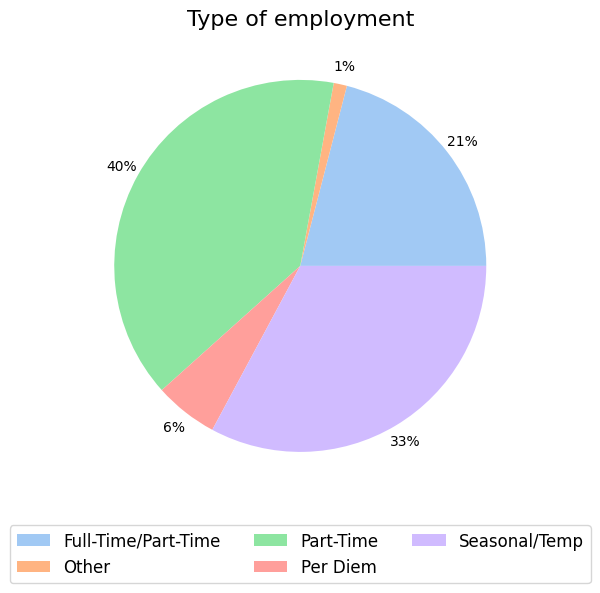

In [14]:
# replacing "Temporary/seasonal" value to "Seasonal/Temp" in type of employment column
job_description.loc[:, "Employment.Type"] = job_description["Employment.Type"].replace(["Temporary/seasonal"], "Seasonal/Temp")

# getting temp df with counts of Employment.Type
employment_type = job_description["Employment.Type"].value_counts().reset_index()
employment_type.columns = ["Employment.Type", "count"]

# getting popular types of employment (taggig unpopular as "other")
popular_emp_type = employment_type[employment_type["count"] >= 1000]["Employment.Type"].tolist()
employment_type["Employment.Type"] = employment_type["Employment.Type"].apply(lambda x: x if x in popular_emp_type else "Other")

# aggregate the same values into one
employment_type = employment_type.groupby(["Employment.Type"])["count"].sum().reset_index()

#define Seaborn color palette to use
colors = sns.color_palette("pastel")

#create pie chart
plt.figure(facecolor='white', figsize=(6,8))
plt.pie(employment_type["count"], colors = colors, autopct="%.0f%%", pctdistance=1.1)
plt.title("Type of employment", fontsize=16)
plt.legend(employment_type["Employment.Type"], loc="upper center", bbox_to_anchor=(0.5, -0.04), ncol=3, fontsize=12)

plt.show()

Some observations:
* The most popular type of employment is Part time - 40%
* The least popular type of employment belongs to Other group which includes Intern, Full-time and Contract - 1%

I'm not sure that this feature is meaningful for our task, I'll drop it later

count    229.000000
mean       7.832227
std        7.566016
min        0.000000
25%        0.000000
50%        8.000000
75%       10.550000
max       58.000000
Name: Salary, dtype: float64

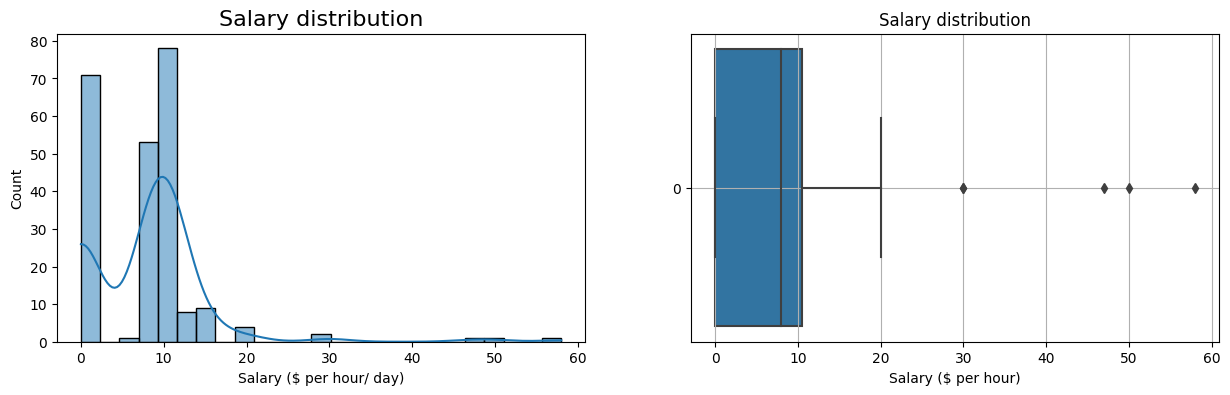

In [15]:
"""
Let's check the distribution of Salary
"""
# coordinate systems visualization
fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(15,4))

# create histogram
sns.histplot(
    job_description["Salary"],
    bins=25,
    kde=True,
    ax=axes[0]
);
axes[0].set_title("Salary distribution", fontsize=16);
axes[0].set_xlabel("Salary ($ per hour/ day)")

# create boxplot
sns.boxplot(
    job_description["Salary"],
    orient="h",
    width=0.9,
    ax=axes[1]
);
axes[1].set_title("Salary distribution");
axes[1].set_xlabel("Salary ($ per hour)");
axes[1].grid()

job_description["Salary"].describe()

Some observations:
* based on the histogram and boxplot of Salary distribution I can conclude that the data aren't normally distributed. There are outliers.
* anyway, this column has only 229 not null rows, that's why it has no sense to study it

In [16]:
"""
Let's check unique categories in Position column in details
"""
job_description["Position"].value_counts()

Position
Administrative Assistant                                                      1414
Customer Service Representative                                               1296
Accounts Payable Clerk                                                         970
Accounting Clerk                                                               953
Sales Representative / Sales Associate ( Entry Level )                         917
                                                                              ... 
Medical Records Clerk - Home Health - PRN - Kindred at Home - Campbell, CA       1
Immediate Need for Accounts Receivable Clerk                                     1
Financial Operations Consultant                                                  1
AR Clerk with Cash Applications experience needed Downtown                       1
Book Keeper                                                                      1
Name: count, Length: 36245, dtype: int64

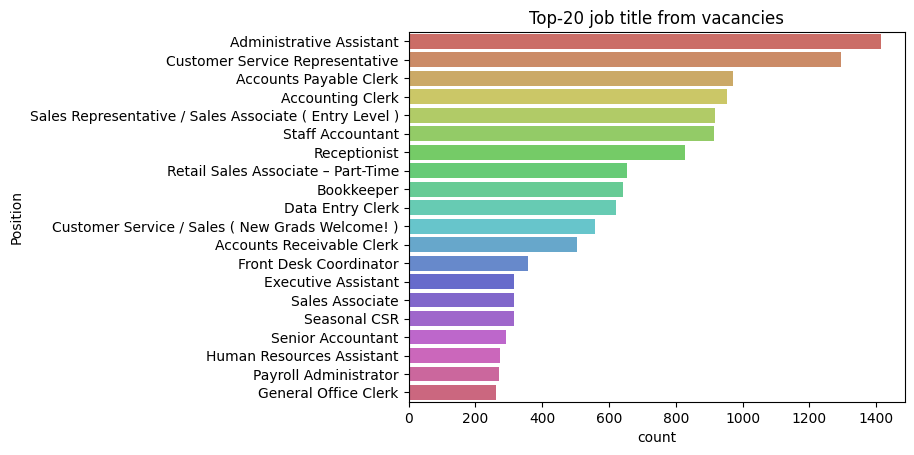

In [17]:
job_title = job_description["Position"].value_counts().reset_index()[:20]
job_title.columns = ["Position", "count"]

sns.barplot(x="count", y="Position", data=job_title, color="blue", palette="hls").set(title="Top-20 job title from vacancies");

Top-5 job position in Vacancies:
* Administrative assistant
* Customer care representative
* Accounts payable clerk
* Accounting clerk
* Sales representative

Based on this small part of job position I can conclude that there are cases when one job position has different variation:
* *Customer service representative* <-> *Seasonal CSR*
In this case the word *seasonal* should be remove to Employment.Type column.

So, I guess that it is popular problem when one job position has different variation of title name. I can check it manually in order to get "clean" job titles, but it needs time. Maybe it will be good for further study.

***

### Location features
- City
- State.Name
- State.Code
- Address
- Latitude, Longitude

***

In [18]:
"""
Let's check unique categories in State.Name and State.Code columns in details
"""
state_name_code = job_description.groupby("State.Code")["State.Name"].value_counts().reset_index(name="count").sort_values(["count"], ascending=False).reset_index()
state_name_code.drop("index", axis=1)

,State.Code,State.Name,count
0,CA,California,10755
1,FL,Florida,5683
2,TX,Texas,5479
3,PA,Pennsylvania,4972
4,IL,Illinois,4081
5,OH,Ohio,4047
6,NY,New York,3243
7,NJ,New Jersey,2869
8,MN,Minnesota,2476
9,IN,Indiana,2420


Some observations:
* 51 USA states
* The most vacancies are from California companies
* The least vacancies are from Wyoming companies

In [19]:
"""
Let's check unique categories in City column in details
"""
city_by_state = job_description.groupby("State.Code")["City"].value_counts().reset_index(name="count")

print(f"\nNumber of cities from different states: {city_by_state.shape[0]}\n")
display(city_by_state[:10])


Number of cities from different states: 7203



,State.Code,City,count
0,AK,Anchorage,87
1,AK,Fairbanks,15
2,AK,Kodiak,9
3,AK,Juneau,5
4,AK,Wasilla,4
5,AK,Valdez,4
6,AK,Soldotna,4
7,AK,Fort Wainwright,3
8,AK,Bethel,3
9,AK,Kotzebue,3


In [20]:
# Checking for duplicate city names from different states
cities = city_by_state.groupby(["City"])["State.Code"].nunique().reset_index()
townships = cities[cities["State.Code"] != 1]

print(f"\nNumber of cities-townships: {townships.shape[0]}\n")
display(townships[:10])


Number of cities-townships: 870



,City,State.Code
0,Abbeville,2
2,Aberdeen,5
3,Abilene,2
4,Abingdon,2
9,Acton,3
11,Ada,2
16,Addison,3
20,Adrian,2
30,Akron,3
37,Alamo,2


Some observations:
- This dataset consists of information about vacancies from 7203 cities
- There are 870 cities-townships. It is a case when there is the same name of city in different states. This is an important point for the stage of filling Missing values.

In [21]:
"""
Let's check unique categories in Company column in details
"""
company_by_state = job_description.groupby("State.Code")["Company"].value_counts().reset_index(name="count")

print(f"\nNumber of companies from different states: {company_by_state.shape[0]}\n")
display(company_by_state[:10])


Number of companies from different states: 15566



,State.Code,Company,count
0,AK,Providence Health & Services,36
1,AK,Swedish Health,31
2,AK,Alaska Airlines,10
3,AK,"The Geo Group, Inc.",10
4,AK,Vector Marketing,9
5,AK,SAS Retail Services,6
6,AK,First Student,6
7,AK,Transportation Security Administration,6
8,AK,KeyBank,4
9,AK,Charter College,4


In [22]:
# Checking for duplicate company names from different states
companies = company_by_state.groupby(["Company"])["State.Code"].nunique().reset_index()
duplicated_name_of_company = companies[companies["State.Code"] != 1]

print(f"\nNumber of companies with the same name from different states: {duplicated_name_of_company.shape[0]}\n")
display(duplicated_name_of_company[:20])


Number of companies with the same name from different states: 1502



,Company,State.Code
8,1st Class Staffing,2
11,"20/20 Companies, Inc.",3
14,"2020 Companies, Inc.",2
16,24 Seven Inc,3
18,360 Healthcare Staffing,11
20,5 Entry Level Openings!,2
24,84 Lumber,21
36,A+E Networks,2
38,A-Line Staffing Solutions.,2
44,AAA,2


In [23]:
"""
Let's visualize companies location in a map context
"""
# Create city_map dataset for visualisation
city_cols = list(["City"] + ["Latitude"] + ["Longitude"])
city_data = job_description[city_cols]
city_data.dropna(inplace=True) # delete rows with missing values


# latitude and longitude of USA
latitude = 33.247875
longitude = -83.441162

city_map = folium.Map(location=[latitude, longitude], zoom_start=11)

# add markers to map
for lat, lng, label in zip(city_data["Latitude"], city_data["Longitude"], city_data["City"]):
    label = folium.Popup(label, parse_html=True)
    folium.CircleMarker(
        [lat, lng],
        radius=5,
        popup=label,
        color="blue",
        fill=True,
        fill_color="#3186cc",
        fill_opacity=0.7,
        parse_html=False).add_to(city_map)  
    
city_map.save("./city_map.html") # "data/city_map.html"
# city_map

***Some observations about the data:***

* Number of required education level: 4 specific levels and 1 not specified (about 75% of data).

* This dataset presents of vacancies from 5 different industries as:
    - Food and Beverages
    - Transportation
    - Retail
    - Office Administration
    - Care Giving and Other
    
    
* Number of unique employment type: 7.
    - Part-Time
    - Full-Time/Part-Time
    - Per Diem
    - Intern
    - Full-Time
    - Contract
    - "Seasonal/Temp" and "Temporary/seasonal" are the same. We should check it further


* Top-5 job position in Vacancies: Administrative assistant, Customer care representative, Accounts payable clerk, Accounting clerk, Sales representative. It belongs to Office Administration and Retail industries. There is a problem when one job position has different variation of title name. We can check it manually and replace to "true value" by using dictionary and map() method.

* Number of states: 51. The most vacancies from companies based in California.

* Number of unique city names: 5503. **But** after grouping city with state code I see more than 7k rows of cities. It means that there are cities with similar names in different states (usually this city called as township). There are 870 cities-townships.

* This dataset consists of vacancies from 8335 companies. **But** after grouping company names with state code I saw the same situation as with cities-townships. In real there are 15566 different companies. Number of companies with the same name from different states: 1502

* Number of unique job position: 36245. I assume that there are fewer unique job positions, because there are examples where the same job position is written differently (caps lock, added company name/ employment type). We can check it further
    - "Sales Representative / Sales Associate ( Entry Level )" / "Sales Associate" / "SALES ASSOCIATE (Herndon, VA - PT)" / "Sales Associate - Slots A Fun Shop (PT)"

***

### Checking missing values and full duplicates

In [24]:
"""
Let`s check our data for Missing values (MV)
"""
print(f"Total number of rows, columns: {job_description.shape}")

# duplicates
all_columns = list(job_description.columns)
mask_dupl = job_description.duplicated(subset=all_columns) 
data_duplicates = job_description[mask_dupl]
print(f"\nNumber of found duplicates: {data_duplicates.shape[0]}")

# features with missing values
nulls_data = job_description.isnull().sum()
nulls = nulls_data[nulls_data > 0]
print(f"\nFeatures with nulls: {nulls_data[nulls_data>0].count()}\n{nulls}")

Total number of rows, columns: (84090, 23)

Number of found duplicates: 0

Features with nulls: 13
Company                2271
City                    135
State.Name              171
State.Code              171
Address               84054
Industry              83823
Job.Description          56
Requirements          84090
Salary                83861
Listing.Start           683
Listing.End             167
Employment.Type          10
Education.Required      267
dtype: int64


 From the above list we see that there are lot of NaN values, perform data cleansing for each and every column

#### **Subsetting only needed columns and not considering the columns that are not necessary:**

*Columns with more than 40% of missing values*:
- Industry
- Requirements
- Salary
- Address

*Columns with duplicated information*:
- State.Name
- Slug
- Title

*Non informative columns*:
- Provider
- Status
- Listing.Start
- Listing.End
- Created.At
- Updated.At'

*Columns for further work*:
* Job.ID
* Position
* Company
* City
* State.Code
* Latitude
* Longitude
* Job.Description
* Employment.Type
* Education.Required

In [25]:
# get columns for further work
cols = list(["Job.ID"]+["Position"]+["Company"]+["City"]+["State.Code"]+\
    ["Latitude"]+["Longitude"]+["Employment.Type"]+["Job.Description"]+["Education.Required"])

jobs_temp = job_description[cols]
jobs_temp.columns = ["Job_ID", "Position", "Company", "City", "State_code",
                      "Latitude", "Longitude", "Employment_type", "Job_description", "Edu_required"]
jobs_temp.head()

,Job_ID,Position,Company,City,State_code,Latitude,Longitude,Employment_type,Job_description,Edu_required
0,111,Server,Tacolicious,Palo Alto,CA,37.443346,-122.161170,Part-Time,Tacolicious' first Palo Alto store just opened...,NaN
1,113,Kitchen Staff/Chef,Claude Lane,San Francisco,CA,37.789830,-122.404268,Part-Time,\r\n\r\nNew French Brasserie in S.F. Financia...,NaN
2,117,Bartender,Machka Restaurants Corp.,San Francisco,CA,37.795597,-122.402963,Part-Time,We are a popular Mediterranean wine bar and re...,NaN
3,121,Server,Teriyaki House,Brisbane,CA,37.685073,-122.400275,Part-Time,● Serve food/drinks to customers in a profess...,NaN
4,127,Kitchen Staff/Chef,Rosa Mexicano - Sunset,Los Angeles,CA,34.073384,-118.460439,Part-Time,"Located at the heart of Hollywood, we are one ...",NaN


In [26]:
# checking for the null values again
jobs_temp.isnull().sum()

Job_ID                0
Position              0
Company            2271
City                135
State_code          171
Latitude              0
Longitude             0
Employment_type      10
Job_description      56
Edu_required        267
dtype: int64

### `City` column

Let's select NaN rows of City and check is there any value in Latitude and Longitude columns. If it is true, then it is possible to recover NaN values in City column.

In [27]:
"""
Selecting NaN rows of City
"""
nan_city = jobs_temp[jobs_temp["City"].isnull()]

print(nan_city.shape)
display(nan_city.head())

(135, 10)


,Job_ID,Position,Company,City,State_code,Latitude,Longitude,Employment_type,Job_description,Edu_required
3425,142044,Registered Nurse (RN),St. Francis Hospital,NaN,GA,0.0,0.0,Full-Time/Part-Time,Under the direction of the Clinical Coordinato...,Associate Degree
3433,142054,Sales Representative - Business Development Op...,CHI Payment Systems,NaN,NaN,0.0,0.0,Full-Time/Part-Time,"If you&rsquo;re energetic, motivated, hardwork...",High School Diploma
3434,142055,New Business Executive,CHI Payment Systems,NaN,NaN,0.0,0.0,Full-Time/Part-Time,"If you&rsquo;re energetic, motivated, hardwork...",High School Diploma
3435,142056,Outside Sales Representative (Business Develop...,CHI Payment Systems,NaN,NaN,0.0,0.0,Full-Time/Part-Time,"If you&rsquo;re energetic, motivated, hardwork...",High School Diploma
3436,142057,Outside Sales Representative,CHI Payment Systems,NaN,NaN,0.0,0.0,Full-Time/Part-Time,"If you&rsquo;re energetic, motivated, hardwork...",High School Diploma


So, my hypothesis is false. In this case columns with information about Latitude and Longitude are only duplicate information from city columns. I can delete them.

***

In [28]:
# Look at the companies list in cities with no name
nan_city.groupby(["Company"])["City"].count()

Company
Academic Year In America                0
CBS Healthcare Services and Staffing    0
CHI Payment Systems                     0
Driveline Retail                        0
Educational Testing Services            0
Genesis Health System                   0
Genesis Health Systems                  0
Home Instead Senior Care                0
St. Francis Hospital                    0
Volvo Group                             0
Name: City, dtype: int64

We see that there are only 9 unique companies cities that are having NaN values. So I manually adding their head quarters with the help of google search


In [29]:
"""
Replacing NaN with thier headquarters location
I created 2 dictionary with City name and State code because there are cities with the same name in different states.
"""
jobs_temp.loc[:, "Company"] = jobs_temp.loc[:, "Company"].replace(["Genesis Health Systems"], "Genesis Health System")

# # we should check every cities of these companies "is this city township or unique?" For example:
# jobs_temp[jobs_temp["City"] == "Washington"]["State_code"].value_counts()

city_of_headquarters = {
    "Academic Year In America": "Stamford",
    "CBS Healthcare Services and Staffing": "Urbandale",
    "CHI Payment Systems": "Westlake Village",
    "Driveline Retail": "Coppell",
    "Educational Testing Services": "Princeton",
    "Genesis Health System": "Davenport",
    "Home Instead Senior Care": "Omaha",
    "St. Francis Hospital": "Hartford",
    "Volvo Group": "Washington"
}

state_code_of_headquarters = {
    "Academic Year In America": "CT",
    "CBS Healthcare Services and Staffing": "IA",
    "CHI Payment Systems": "CA",
    "Driveline Retail": "TX",
    "Educational Testing Services": "NJ",
    "Genesis Health System": "IA",
    "Home Instead Senior Care": "NE",
    "St. Francis Hospital": "CT",
    "Volvo Group": "DC"
}

# Getting a list with MV rows
city = list(jobs_temp[jobs_temp["City"].isna()].index)
state_code = list(jobs_temp[jobs_temp["State_code"].isna()].index)

# Filling MV by dict
jobs_temp.loc[city, "City"] = jobs_temp.loc[city, "Company"].map(city_of_headquarters)
jobs_temp.loc[state_code, "State_code"] = jobs_temp.loc[state_code, "Company"].map(state_code_of_headquarters)

display(jobs_temp.head())

,Job_ID,Position,Company,City,State_code,Latitude,Longitude,Employment_type,Job_description,Edu_required
0,111,Server,Tacolicious,Palo Alto,CA,37.443346,-122.161170,Part-Time,Tacolicious' first Palo Alto store just opened...,NaN
1,113,Kitchen Staff/Chef,Claude Lane,San Francisco,CA,37.789830,-122.404268,Part-Time,\r\n\r\nNew French Brasserie in S.F. Financia...,NaN
2,117,Bartender,Machka Restaurants Corp.,San Francisco,CA,37.795597,-122.402963,Part-Time,We are a popular Mediterranean wine bar and re...,NaN
3,121,Server,Teriyaki House,Brisbane,CA,37.685073,-122.400275,Part-Time,● Serve food/drinks to customers in a profess...,NaN
4,127,Kitchen Staff/Chef,Rosa Mexicano - Sunset,Los Angeles,CA,34.073384,-118.460439,Part-Time,"Located at the heart of Hollywood, we are one ...",NaN


In [30]:
jobs_temp.isnull().sum()

Job_ID                0
Position              0
Company            2271
City                  0
State_code           39
Latitude              0
Longitude             0
Employment_type      10
Job_description      56
Edu_required        267
dtype: int64

### `Employment type`

In [31]:
"""
Selecting NaN rows of Employment type
"""
nan_emp_type = jobs_temp[jobs_temp["Employment_type"].isnull()]

display(nan_emp_type)

,Job_ID,Position,Company,City,State_code,Latitude,Longitude,Employment_type,Job_description,Edu_required
10768,153197,Driving Partner,Uber,San Francisco,CA,37.774929,-122.419415,NaN,Uber is changing the way the world moves. From...,NaN
10769,153198,Driving Partner,Uber,Los Angeles,CA,34.052234,-118.243685,NaN,Uber is changing the way the world moves. From...,NaN
10770,153199,Driving Partner,Uber,Chicago,IL,41.878114,-87.629798,NaN,Uber is changing the way the world moves. From...,NaN
10771,153200,Driving Partner,Uber,Boston,MA,42.358431,-71.059773,NaN,Uber is changing the way the world moves. From...,NaN
10772,153201,Driving Partner,Uber,Ann Arbor,MI,42.280826,-83.743038,NaN,Uber is changing the way the world moves. From...,NaN
10773,153202,Driving Partner,Uber,Oklahoma,OK,35.467560,-97.516428,NaN,Uber is changing the way the world moves. From...,NaN
10774,153203,Driving Partner,Uber,Omaha,NE,41.252363,-95.997988,NaN,Uber is changing the way the world moves. From...,NaN
10775,153204,Driving Partner,Uber,Lincoln,NE,40.809722,-96.675278,NaN,Uber is changing the way the world moves. From...,NaN
10776,153205,Driving Partner,Uber,Minneapolis,MN,44.983334,-93.266670,NaN,Uber is changing the way the world moves. From...,NaN
10777,153206,Driving Partner,Uber,St. Paul,MN,44.953703,-93.089958,NaN,Uber is changing the way the world moves. From...,NaN


There are only 10 rows with MV. All of them belongs to Uber company, which looks for driving partner. So I assume it look like part-time/full time job position.

In [32]:
# replacing na values with part time/full time
jobs_temp.loc[:, "Employment_type"] = jobs_temp["Employment_type"].fillna("Full-Time/Part-Time")

jobs_temp.groupby(["Employment_type"])["Company"].count()

Employment_type
Contract                  14
Full-Time                 37
Full-Time/Part-Time    16771
Intern                   904
Part-Time              32188
Per Diem                4514
Seasonal/Temp          27391
Name: Company, dtype: int64

### `State code`

In [33]:
"""
Selecting NaN rows of State code
"""
nan_state_code = jobs_temp[jobs_temp["State_code"].isnull()]

display(nan_state_code.head(10))

,Job_ID,Position,Company,City,State_code,Latitude,Longitude,Employment_type,Job_description,Edu_required
204,134544,Pool Attendant (Regular Part-time),Wyndham Hotel Group,Rio Grande,NaN,18.30180,-66.08000,Part-Time,The Pool Attendant is responsible for ensuring...,High School Diploma
205,134545,Towel Hut Attendant (Regular Part-time),Wyndham Hotel Group,Rio Grande,NaN,18.30180,-66.08000,Part-Time,The Towel Hut Attendant is responsible for ens...,High School Diploma
4879,144174,Part Time Supervisor - Preload,UPS,Carolina,NaN,18.40914,-65.97484,Part-Time,"UPS is currently seeking highly motivated, ene...",High School Diploma
5604,144928,Seasonal CSR,David's Bridal,Carolina,NaN,18.40914,-65.97484,Part-Time,We are hiring for our upcoming busy season! In...,High School Diploma
6318,145693,Entry Level Sales / Customer Service – Part ti...,Vector Marketing,San Juan,NaN,18.39050,-66.09030,Part-Time,Entry Level Sales / Customer Service &ndash; P...,High School Diploma
6452,145827,Entry Level Sales / Customer Service – Part ti...,Vector Marketing,Mayaguez,NaN,18.20380,-67.14530,Part-Time,Entry Level Sales / Customer Service &ndash; P...,High School Diploma
6473,145848,Entry Level Sales / Customer Service – Part ti...,Vector Marketing,Ponce,NaN,18.11440,-66.85680,Part-Time,Entry Level Sales / Customer Service &ndash; P...,High School Diploma
7430,146983,Molecular Sales Consultant (MSC),NaN,San Juan,NaN,18.39669,-66.07442,Part-Time,Molecular Sales Consultant (MSC)\r\n&nbsp;\r\n...,Bachelor's Degree
9578,150031,Casino Surveillance Agent (Regular Part-time),Wyndham Hotel Group,Rio Grande,NaN,18.30180,-66.08000,Part-Time,The Surveillance Agent performs undercover obs...,High School Diploma
10483,151086,Veterinary Assistant,Banfield Pet Hospital,Guaynabo,NaN,18.36580,-66.09280,Part-Time,Veterinary Assistant (VA) The Veterinary Assis...,Not Specified


In [34]:
# Look at the lat, lng coordinates of cities with no State code
nan_state_code.groupby(["City"])[["Latitude", "Longitude"]].mean()

,Latitude,Longitude
City,,
Barceloneta,18.454800,-66.538900
Bayamon,18.189200,-66.113400
Carolina,18.409140,-65.974840
Dededo,13.534600,144.885800
Guaynabo,18.365800,-66.092800
Juncos,18.233900,-65.921800
Mayaguez,18.203800,-67.145300
Ponce,18.114400,-66.856800
Rio Grande,18.301800,-66.080000


All of these cities based on Puerto Rico. That's why they have not any state code. But they are part of USA.

*Puerto Rico officially the Commonwealth of Puerto Rico is a Caribbean island and unincorporated territory of the United States*

I want to add as state code **PR**

In [35]:
# fill missing values in state code with PR tag (Puerto Rico)
jobs_temp.loc[:, "State_code"] = jobs_temp["State_code"].fillna("PR")

display(jobs_temp[jobs_temp["State_code"] == "PR"].head())

,Job_ID,Position,Company,City,State_code,Latitude,Longitude,Employment_type,Job_description,Edu_required
204,134544,Pool Attendant (Regular Part-time),Wyndham Hotel Group,Rio Grande,PR,18.30180,-66.08000,Part-Time,The Pool Attendant is responsible for ensuring...,High School Diploma
205,134545,Towel Hut Attendant (Regular Part-time),Wyndham Hotel Group,Rio Grande,PR,18.30180,-66.08000,Part-Time,The Towel Hut Attendant is responsible for ens...,High School Diploma
4879,144174,Part Time Supervisor - Preload,UPS,Carolina,PR,18.40914,-65.97484,Part-Time,"UPS is currently seeking highly motivated, ene...",High School Diploma
5604,144928,Seasonal CSR,David's Bridal,Carolina,PR,18.40914,-65.97484,Part-Time,We are hiring for our upcoming busy season! In...,High School Diploma
6318,145693,Entry Level Sales / Customer Service – Part ti...,Vector Marketing,San Juan,PR,18.39050,-66.09030,Part-Time,Entry Level Sales / Customer Service &ndash; P...,High School Diploma


### `Required education level`

I want to check two points:
- what types of job positions have NaN value in Education_required column
- and is it possible to fill missing values by the other examples in dataset?

In [36]:
"""
Selecting NaN rows of Education level
"""
nan_edu_level = jobs_temp[jobs_temp["Edu_required"].isnull()]

display(nan_edu_level.head())

,Job_ID,Position,Company,City,State_code,Latitude,Longitude,Employment_type,Job_description,Edu_required
0,111,Server,Tacolicious,Palo Alto,CA,37.443346,-122.161170,Part-Time,Tacolicious' first Palo Alto store just opened...,NaN
1,113,Kitchen Staff/Chef,Claude Lane,San Francisco,CA,37.789830,-122.404268,Part-Time,\r\n\r\nNew French Brasserie in S.F. Financia...,NaN
2,117,Bartender,Machka Restaurants Corp.,San Francisco,CA,37.795597,-122.402963,Part-Time,We are a popular Mediterranean wine bar and re...,NaN
3,121,Server,Teriyaki House,Brisbane,CA,37.685073,-122.400275,Part-Time,● Serve food/drinks to customers in a profess...,NaN
4,127,Kitchen Staff/Chef,Rosa Mexicano - Sunset,Los Angeles,CA,34.073384,-118.460439,Part-Time,"Located at the heart of Hollywood, we are one ...",NaN


In [37]:
"""
Checking the type of job position with NaN value in Edu_requierd column
"""
nan_edu_level["Position"].value_counts()

Position
Server                                              82
Delivery Team Couriers (Drivers and Bikers)         28
Line Cook                                           13
Driving Partner                                     10
Driver                                               8
                                                    ..
UI Lead                                              1
Business Analyst                                     1
Entry Level - Immediate Hire for our New Office!     1
Welder                                               1
Book Keeper                                          1
Name: count, Length: 78, dtype: int64

In [38]:
"""
Let's look at the required education level corresponds to "Server" and "Line Cook" positions (they have high level of missing values)
"""
print("\nRequired education level at the Server position\n")
display(jobs_temp[jobs_temp["Position"] == "Server"]["Edu_required"].value_counts())

print("\nRequired education level at the Line Cook position\n")
display(jobs_temp[jobs_temp["Position"] == "Line Cook"]["Edu_required"].value_counts())


Required education level at the Server position



Edu_required
Not Specified          19
High School Diploma    15
Name: count, dtype: int64


Required education level at the Line Cook position



Edu_required
Not Specified          12
High School Diploma     2
Name: count, dtype: int64

As you can see, it is not so obvious how to fill missing values correctly. Because *Not specified* and *High school diploma* are about different.

Also, earlier I've pointed that the most popular tag for this column is *Not specified* (75%).

Maybe it has more sense to drop these rows or don't use this feature at all.

***

As you can see in the list of columns above, there is a lot of information about location of the job (city, State.Name, State.Code, Address, Latitude, Longitude), which we will not use to recommend resume.

The rest of the columns either don’t seem to be adding many values to our use case, or it has a lot of missing values.

So, I want to use only 3 columns from Vacancies dataset:
* Job_ID
* Position (or job title)
* Job description

In [39]:
"""
Get final_jobs dataset with 3 columns
Drop rows with MV in "Job_description" column
"""
cols = list(["Job_ID"]+["Position"]+["Job_description"])
final_jobs = jobs_temp[cols]
final_jobs.columns = ["Job_ID", "Job_position", "Job_description"]
display(final_jobs.head(2))

final_jobs = final_jobs.dropna(subset=["Job_description"])
final_jobs.shape

,Job_ID,Job_position,Job_description
0,111,Server,Tacolicious' first Palo Alto store just opened...
1,113,Kitchen Staff/Chef,\r\n\r\nNew French Brasserie in S.F. Financia...


(84034, 3)

In [40]:
# Check MV one more time
final_jobs.isnull().sum()

Job_ID             0
Job_position       0
Job_description    0
dtype: int64

#### Deleting full duplicates in Job_description columns from Vacancies dataset

In [41]:
"""
Let`s check our Job_description column to duplicates
"""
duplicate = final_jobs[final_jobs.duplicated("Job_description")]

print("\nDuplicated rows in Job_description: \n")
display(duplicate.head(3))
print(f"\nNumber of duplicated rows: {duplicate.shape[0]}")


Duplicated rows in Job_description: 



,Job_ID,Job_position,Job_description
28,134296,Sales Professional,What can Michael Hill offer you?\r\n\r\nA comm...
29,134297,Sales Professional,What can Michael Hill offer you?\r\n\r\nA comm...
30,134298,Sales Professional,What can Michael Hill offer you?\r\n\r\nA comm...



Number of duplicated rows: 24765


In [42]:
"""
Delete duplicates by drop_duplicates() method
Create new df vacancies_dedupped - is cleaned from duplicates
"""
vacancies_dedupped = final_jobs.drop_duplicates(subset=["Job_description"])
print(f"Total number of rows after deleting duplicates: {vacancies_dedupped.shape[0]}")

Total number of rows after deleting duplicates: 59269


***

## <center> RESUMES DATASET

Let's look at the resumes dataset in details.

In [43]:
display(resumes.head())
print(f"\nShape of resumes dataset: {resumes.shape}\n")
display(resumes.info())

,Applicant.ID,Position.Name,Employer.Name,City,State.Name,State.Code,Start.Date,End.Date,Job.Description,Salary,Can.Contact.Employer,Created.At,Updated.At
0,10001,Account Manager / Sales Administration / Quali...,Barcode Resourcing,Bellingham,Washington,WA,2012-10-15,NaN,NaN,NaN,NaN,2014-12-12 20:10:02 UTC,2014-12-12 20:10:02 UTC
1,10001,Electronics Technician / Item Master Controller,Ryzex Group,Bellingham,Washington,WA,2001-12-01,2012-04-01,NaN,NaN,NaN,2014-12-12 20:10:02 UTC,2014-12-12 20:10:02 UTC
2,10001,Machine Operator,comptec inc,Custer,Washington,WA,1997-01-01,1999-01-01,NaN,NaN,NaN,2014-12-12 20:10:02 UTC,2014-12-12 20:10:02 UTC
3,10003,maintenance technician,Winn residental,washington,District of Columbia,DC,NaN,NaN,"Necessary maintenance for ""Make Ready"" Plumbin...",10.0,False,2014-12-12 21:27:05 UTC,2014-12-12 21:27:05 UTC
4,10003,Electrical Helper,michael and son services,alexandria,Virginia,VA,NaN,NaN,repair and services of electrical construction,NaN,False,2014-12-12 21:27:05 UTC,2014-12-12 21:27:05 UTC



Shape of resumes dataset: (8653, 13)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 8653 entries, 0 to 8652
Data columns (total 13 columns):
 #   Column                Non-Null Count  Dtype  
---  ------                --------------  -----  
 0   Applicant.ID          8653 non-null   int64  
 1   Position.Name         7655 non-null   object 
 2   Employer.Name         8568 non-null   object 
 3   City                  4891 non-null   object 
 4   State.Name            4595 non-null   object 
 5   State.Code            4595 non-null   object 
 6   Start.Date            6618 non-null   object 
 7   End.Date              4906 non-null   object 
 8   Job.Description       5646 non-null   object 
 9   Salary                2798 non-null   float64
 10  Can.Contact.Employer  3581 non-null   object 
 11  Created.At            8653 non-null   object 
 12  Updated.At            8653 non-null   object 
dtypes: float64(1), int64(1), object(11)
memory usage: 878.9+ KB


None

### **Exploring the content of variables**

The dataset is dedicated to the Resumes and contains 8,653 rows and 13 columns.

Let's divide all features into 4 groups:
- Applicant information
    * Applicant_ID
- Job experience: 
    * Job_title (previous work places), Employer.Name, Duration of a job (Start.Date, End.Date), Job_description, Salary, Can.Contact.Employer
- Employer location:
    * City, State.Name, State.Code,
- Non-informative features:
    * Created.At, Updated.At
     
The most interesting columns for our task are *Job title* and *Job descriprion*. Anyway, information about *Duration of a job* is also important in order to get total years of applicant's work experience. But the Requirenments column is empty in Vacancies dataset, in this case information about work experience years becomes meaningless.

In [44]:
# I modify the column name so that I can use df dot column name more easily
resumes = resumes.rename(columns={"Applicant.ID": "Applicant_ID",
                                  "Position.Name": "Job_title",
                                  "Job.Description": "Job_description"})

print(f"\nNumber of unique applicant ID: {resumes.Applicant_ID.nunique()}")


Number of unique applicant ID: 3790


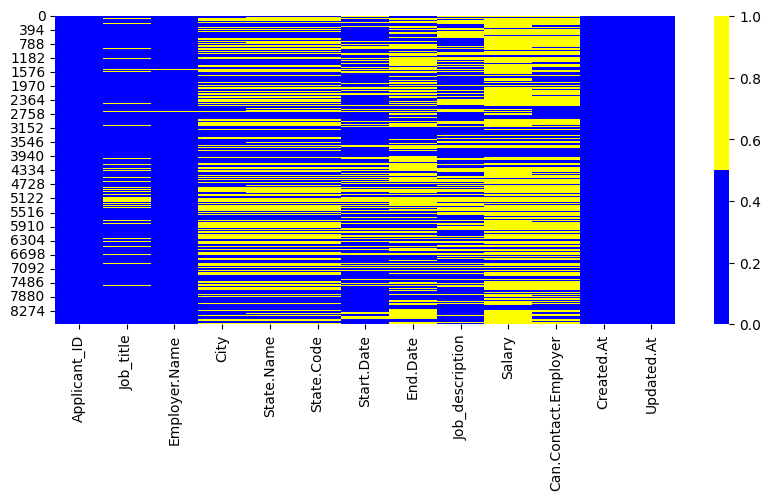

In [45]:
"""
Distribution of Missing Values according to the data
"""
cols_with_null = resumes.isnull().sum()

colors = ["blue", "yellow"]

fig = plt.figure(figsize=(10,4))
cols = cols_with_null.index
ax = sns.heatmap(
    resumes[cols].isnull(),
    cmap=sns.color_palette(colors)
)

The graph shows that the concentrations of Missing Values are on the next points:
* Location features,
* Information about previous job place
    - work period
    - salary
    - can.contact.employer
    - job description and job title

It will be enough to delete uninformative columns and rows with MV in Job description and Job title columns

In [46]:
"""
For example, for applicant_id 10001
its job description is shown as Nan for the first three rows, hence these observations will be removed and won’t be considered in the dataset.
"""
resumes[resumes["Applicant_ID"] == 10001]

,Applicant_ID,Job_title,Employer.Name,City,State.Name,State.Code,Start.Date,End.Date,Job_description,Salary,Can.Contact.Employer,Created.At,Updated.At
0,10001,Account Manager / Sales Administration / Quali...,Barcode Resourcing,Bellingham,Washington,WA,2012-10-15,NaN,NaN,NaN,NaN,2014-12-12 20:10:02 UTC,2014-12-12 20:10:02 UTC
1,10001,Electronics Technician / Item Master Controller,Ryzex Group,Bellingham,Washington,WA,2001-12-01,2012-04-01,NaN,NaN,NaN,2014-12-12 20:10:02 UTC,2014-12-12 20:10:02 UTC
2,10001,Machine Operator,comptec inc,Custer,Washington,WA,1997-01-01,1999-01-01,NaN,NaN,NaN,2014-12-12 20:10:02 UTC,2014-12-12 20:10:02 UTC


In [47]:
# But, as we know, that there is implicit MV too - special words/ symbols. Let's look at the example - "none"
resumes.iloc[45]

Applicant_ID                               1005
Job_title                                  none
Employer.Name                              none
City                                       none
State.Name                                  NaN
State.Code                                  NaN
Start.Date                                  NaN
End.Date                                    NaN
Job_description                            none
Salary                                      NaN
Can.Contact.Employer                      False
Created.At              2014-08-15 22:05:48 UTC
Updated.At              2014-08-15 22:05:48 UTC
Name: 45, dtype: object

In [48]:
# None example
resumes[resumes["Applicant_ID"] == 1105]["Job_description"].iloc[0]

'None '

So, this implicit missing values not a simple as you can see.
* firtsly, it is a string type
* secondly, there is a space in string
* lastly, this word could be written in lower and upper case.

I need to keep in mind these points in order to correctly check examples from the whole dataset

In [49]:
# Replace None values with np.nan in order to remove rows with missing values
resumes["Job_description"] = resumes["Job_description"].apply(lambda x: x if str(x).lower().replace(' ', '') != "none" and x is not None else np.nan)
resumes["Job_title"] = resumes["Job_title"].apply(lambda x: x if str(x).lower().replace(' ', '') != "none" and x is not None else np.nan)

In [50]:
# Let's check how does it work
display(resumes.iloc[45])
print('')
display(resumes[resumes["Applicant_ID"] == 1105]["Job_title"])

Applicant_ID                               1005
Job_title                                   NaN
Employer.Name                              none
City                                       none
State.Name                                  NaN
State.Code                                  NaN
Start.Date                                  NaN
End.Date                                    NaN
Job_description                             NaN
Salary                                      NaN
Can.Contact.Employer                      False
Created.At              2014-08-15 22:05:48 UTC
Updated.At              2014-08-15 22:05:48 UTC
Name: 45, dtype: object

397    NaN
Name: Job_title, dtype: object

In [51]:
print(f"\nShape of resumes dataset: {resumes.shape}")
print(f"\nNumber of unique applicant ID: {resumes.Applicant_ID.nunique()}")


Shape of resumes dataset: (8653, 13)

Number of unique applicant ID: 3790


In [52]:
# Delete rows with missing values in "Job_description" and "Job_title" columns
resumes_clean = resumes.dropna(subset=["Job_description", "Job_title"])

# location, employer and salary won’t be helpful for our recommendation engine, so we’ll remove them as well
resumes_clean = resumes_clean.drop(columns=["Employer.Name", "Salary", "Start.Date", "End.Date",
                                "Can.Contact.Employer", "Created.At", "Updated.At",
                                "City", "State.Name", "State.Code"], axis=1)

print(f"\nShape of resumes dataset: {resumes_clean.shape}")
print(f"\nNumber of unique applicant ID: {resumes_clean.Applicant_ID.nunique()}")


Shape of resumes dataset: (5572, 3)

Number of unique applicant ID: 2327


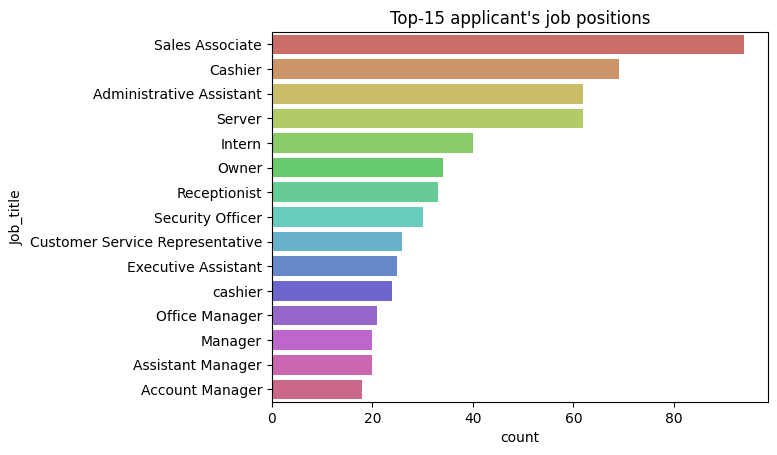

In [53]:
# Let's visualize the most popular job positions from resumes
applicant_job_title = resumes_clean["Job_title"].value_counts().reset_index()[:15]
applicant_job_title.columns = ["Job_title", "count"]

sns.barplot(
    x="count",
    y="Job_title",
    data=applicant_job_title,
    color="blue",
    palette="hls"
).set(title="Top-15 applicant's job positions");

In [54]:
display(resumes_clean.head(5))

,Applicant_ID,Job_title,Job_description
3,10003,maintenance technician,"Necessary maintenance for ""Make Ready"" Plumbin..."
4,10003,Electrical Helper,repair and services of electrical construction
5,10003,technician,"basic auto maintenance, and customer services ..."
10,10007,Bartender,Support bar and management staff at a well-kno...
11,10007,Bar Manager / Head Bartender,•\tCollaborate with management team on a regul...


#### Deleting full duplicates in Job_description columns from Resumes dataset

In [55]:
"""
Let`s check our Job_description column to duplicates
"""
duplicate = resumes_clean[resumes_clean.duplicated("Job_description")]
 
print("\nDuplicated rows in Job_description: \n")
display(duplicate.iloc[3:10])
print(f"\nNumber of duplicated rows: {duplicate.shape[0]}")


Duplicated rows in Job_description: 



,Applicant_ID,Job_title,Job_description
676,11568,Producer / (Design and Production),Work on diverse multimedia creative area of de...
678,11568,Art Director / Interactive Designer,Work on diverse multimedia creative area of de...
685,11595,Sales Administrator,SuperValu Account
972,12421,Customer Service Representative,Assisted Customers with the status of their gr...
1405,13748,Substitute Teacher,Assists teachers by rendering pre-written less...
1434,13811,Operator/processor,Process online orders and have the orders deli...
1524,13876,HRMS- TEMP Database Analyst,*Manage and organize electronic data according...



Number of duplicated rows: 82


In [56]:
"""
Delete duplicates by drop_duplicates() method
Create new df resume_dedupped - is cleaned from duplicates
"""
resume_dedupped = resumes_clean.drop_duplicates(subset=["Job_description"])
print(f"Total number of rows after deleting duplicates: {resume_dedupped.shape[0]}")

Total number of rows after deleting duplicates: 5490


***

In [57]:
"""
Pickle datasets that will be used later
"""
vacancies_dedupped.to_pickle("./vacancies.pkl") # "preprocess_data/vacancies.pkl"
resume_dedupped.to_pickle("./resumes.pkl") # "preprocess_data/resumes.pkl"

# 2. Text Preprocessing

Text preprocessing is the practice of cleaning and preparing text data. This is one of the most crucial steps in the process.

Using NLTK, job title and job description are then pre-processed with the following:

* tokenization — convert sentences to words
* converting the text to lower case
* stopwords removal - frequent words which have not any semantic sense
* removing punctuation, numerical values, some extra examples
* lemmatization - convert the word into a root word
* part-of-speech tagging - removing noninformative POS
* vectorization - numerically representation of text (tf-idf vectorization)

At every stage is necessary go through the text manually to try "catch" examples which can definitely show up and hurt the model.

Since after pre-processing, vacancies with short length got even shorter, i.e., less than 20 words. I’ve decided to remove vacancies that are less than 23 words, in order to still have at least 1,000 resumes in the dataset, ensuring that there’s enough text for the model to be trained on.

In [58]:
# Read the last version
vacancies_temp = pd.read_pickle("./vacancies.pkl")
resume_temp = pd.read_pickle("./resumes.pkl")

In [59]:
print("Vacancies' dataset: \n")
display(vacancies_temp.head(2))
print(f"\nVacancies' dataset shape: {vacancies_temp.shape}\n")
print("*"*80)
print("\nResumes' dataset: \n")
display(resume_temp.head(2))
print(f"\nResumes' dataset shape: {resume_temp.shape}\n")

Vacancies' dataset: 



,Job_ID,Job_position,Job_description
0,111,Server,Tacolicious' first Palo Alto store just opened...
1,113,Kitchen Staff/Chef,\r\n\r\nNew French Brasserie in S.F. Financia...



Vacancies' dataset shape: (59269, 3)

********************************************************************************

Resumes' dataset: 



,Applicant_ID,Job_title,Job_description
3,10003,maintenance technician,"Necessary maintenance for ""Make Ready"" Plumbin..."
4,10003,Electrical Helper,repair and services of electrical construction



Resumes' dataset shape: (5490, 3)



In [60]:
"""
Vacancies dataset
Concat Job title and Job description text into one column
"""
vacancies_temp["Job_title_and_desc"] = vacancies_temp["Job_position"].map(str) + "  " + vacancies_temp["Job_description"]
display(vacancies_temp.head(2))

,Job_ID,Job_position,Job_description,Job_title_and_desc
0,111,Server,Tacolicious' first Palo Alto store just opened...,Server Tacolicious' first Palo Alto store jus...
1,113,Kitchen Staff/Chef,\r\n\r\nNew French Brasserie in S.F. Financia...,Kitchen Staff/Chef \r\n\r\nNew French Brasse...


In [61]:
"""
Resumes dataset
Last step: to make a resume out of this data, I want to concatenate all job experiences by applicant ID

Usually the information about candidate presents full story of his work experience. It has a sense to merge these "work history" into one.
"""
resume_temp = resume_temp.groupby("Applicant_ID").agg({"Job_title": " ".join,"Job_description": " ".join}).reset_index()
display(resume_temp.head(5))
display(resume_temp.shape)

,Applicant_ID,Job_title,Job_description
0,2,Writer for the Uloop Blog Volunteer,"* Wrote articles for the ""Uloop Blog,"" which i..."
1,38,Sales Person & Phone Receptionist,Asking customer if they need any assistance an...
2,78,Impact team member,"Help maintain merchandise flow, Work on fillin..."
3,89,Healthcare Specialist / Combat Medic Clerk's h...,"Clinical and field medicine, Healthcare educat..."
4,96,Cashier Receptionist Cashiet/Waiter,Greeting people and introducing/recommend food...


(2313, 3)

***

## 2.1 Text preprocessing: Part-of-Speech tagging (POS)

Previously I want to do part-of-speech tagging. This step is important for lemmatisation to work, as words which have different meanings depending on part of speech. So, it would be better if POS Tagging implementation is done first.

Also we need to remove not informative words, as prononuns, which is not define job roles.

`What is Part of Speech Tagging?`

Part of Speech Tagging is the process of associating each word in a piece of text with a particular tag, which represents the type of word it is, i.e. proper noun, comparative adjective, interjection etc.

The Universal tagset shown below is a simplified POS tagset:
* CC coordinating conjunction
* CD cardinal digit
* DT determiner
* EX existential there (like: “there is” … think of it like “there exists”)
* FW foreign word
* IN preposition/subordinating conjunction
* JJ adjective ‘big’
* JJR adjective, comparative ‘bigger’
* JJS adjective, superlative ‘biggest’
* LS list marker 1)
* MD modal could, will
* NN noun, singular ‘desk’
* NNS noun plural ‘desks’
* NNP proper noun, singular ‘Harrison’
* NNPS proper noun, plural ‘Americans’
* PDT predeterminer ‘all the kids’
* POS possessive ending parent’s
* PRP personal pronoun I, he, she
* PRP\$ possessive pronoun my, his, hers
* RB adverb very, silently,
* RBR adverb, comparative better
* RBS adverb, superlative best
* RP particle give up
* TO, to go "to" the store
* UH interjection, errrrrrrrm
* VB verb, base form take
* VBD verb, past tense, took
* VBG verb, gerund/present participle taking
* VBN verb, past participle taken
* VBP verb, sing. present, non-3d take
* VBZ verb, 3rd person sing. present takes
* WDT wh-determiner which
* WP wh-pronoun who, what
* WP$ possessive wh-pronoun whose
* WRB wh-adverb where, when

In [62]:
def text_preprocessing(data):
    """
    - Splitting the text into separate words (token) by capital letter
    (! Be careful with regex in order to save correct version of words writting by capslock)
    Example before:
    "The duties of a janitor, General Cleaner include but not limited to the following:ResponsibilitiesClean restroomsReplenish restroomsEmpty trashEmpty..."
    After:
    "the duties of a janitor,  general  cleaner include but not limited to the following: responsibilities clean restrooms replenish restrooms empty trash empty recycle"
    
    - Converting all the characeters to lower case
    """
    data["Job_title_and_desc"] = data["Job_title_and_desc"].apply(lambda x: re.sub( r"([A-Z][^a-z]*)", r" \1", x))
    data["Job_title_and_desc"] = data["Job_title_and_desc"].str.lower()
    
    return data

In [63]:
"""
Part-of-speech tagging
"""
def get_pos(data):
    """
    Get column: list of pair - (token, part-of-speech)
    """
    texts = data["Job_title_and_desc"].tolist() #extract the Text column to a list of string
    tagged_texts = pos_tag_sents(map(word_tokenize, texts))
    
    #add the column back to the DataFrame
    data["POS"] = tagged_texts

    return data


def get_informative_token(data):
    """
    Get list of pair with POS which one play a role in define job positions
    Delete noninformative part-of-speech: pronouns, preposition and postposition, etc.
    
    I wanted to remove ADJ, but I couldn't do it because I lost meaningful words: "electrical(ADJ) maintenance technician(ADJ)"
    """
    pos_noninformative = [".", "CC", "CD", "DT", "IN", "LS", "MD", "POS", "PRP",
                          "PRP$", "TO", "UH", "WDT", "WP", "WP$", "WRB"]
    
    data["POS_clean"] = data["POS"].apply(lambda x: [pair for pair in x if pair[0] != "nbsp" and pair[1] not in pos_noninformative])
                
    return data


def get_only_token(data):
    """
    Get column: list of token with meaningful part-of-speech
    """
    data["clean_token"] = data["POS_clean"].apply(lambda x: [word[0] for word in x])
    
    return data


def get_count_of_tokens(data):
    """
    Get column with words number in job description
    """
    data["token_number"] = data["clean_token"].apply(lambda x: len(x))
    
    return data

In [64]:
"""
Text preprocessing:
- get tokens (separate words)
- convert tokens to lower case
"""
vacancies_temp = text_preprocessing(vacancies_temp)

In [65]:
"""
Get POS tags
"""
vacancies_temp = get_pos(vacancies_temp)
vacancies_temp = get_informative_token(vacancies_temp)
vacancies_temp = get_only_token(vacancies_temp)
vacancies_temp = get_count_of_tokens(vacancies_temp)

vacancies_temp.head(2)

,Job_ID,Job_position,Job_description,Job_title_and_desc,POS,POS_clean,clean_token,token_number
0,111,Server,Tacolicious' first Palo Alto store just opened...,server tacolicious' first palo alto store...,"[(server, RB), (tacolicious, JJ), (', POS), (f...","[(server, RB), (tacolicious, JJ), (first, JJ),...","[server, tacolicious, first, palo, alto, store...",37
1,113,Kitchen Staff/Chef,\r\n\r\nNew French Brasserie in S.F. Financia...,kitchen staff/ chef \r\n\r\n new french ...,"[(kitchen, NN), (staff/, NN), (chef, NN), (new...","[(kitchen, NN), (staff/, NN), (chef, NN), (new...","[kitchen, staff/, chef, new, french, brasserie...",146


In [66]:
"""
Delete tokens with 1 character

I'm not sure that it will be right to delete token with 2 characters, it could be meaningful abbreviation (as RN or LPN from medicine domain)
"""
vacancies_temp["clean_token"] = [[subelt for subelt in elt if len(subelt) > 1] for elt in vacancies_temp["clean_token"]]

#update count_token_number_in_job column
vacancies_temp = get_count_of_tokens(vacancies_temp)
vacancies_temp.head()

,Job_ID,Job_position,Job_description,Job_title_and_desc,POS,POS_clean,clean_token,token_number
0,111,Server,Tacolicious' first Palo Alto store just opened...,server tacolicious' first palo alto store...,"[(server, RB), (tacolicious, JJ), (', POS), (f...","[(server, RB), (tacolicious, JJ), (first, JJ),...","[server, tacolicious, first, palo, alto, store...",31
1,113,Kitchen Staff/Chef,\r\n\r\nNew French Brasserie in S.F. Financia...,kitchen staff/ chef \r\n\r\n new french ...,"[(kitchen, NN), (staff/, NN), (chef, NN), (new...","[(kitchen, NN), (staff/, NN), (chef, NN), (new...","[kitchen, staff/, chef, new, french, brasserie...",129
2,117,Bartender,We are a popular Mediterranean wine bar and re...,bartender we are a popular mediterranean w...,"[(bartender, NN), (we, PRP), (are, VBP), (a, D...","[(bartender, NN), (are, VBP), (popular, JJ), (...","[bartender, are, popular, mediterranean, wine,...",40
3,121,Server,● Serve food/drinks to customers in a profess...,server ● serve food/drinks to customers in...,"[(server, RB), (●, NNP), (serve, VBP), (food/d...","[(server, RB), (●, NNP), (serve, VBP), (food/d...","[server, serve, food/drinks, customers, profes...",23
4,127,Kitchen Staff/Chef,"Located at the heart of Hollywood, we are one ...",kitchen staff/ chef located at the heart o...,"[(kitchen, NN), (staff/, NN), (chef, NN), (loc...","[(kitchen, NN), (staff/, NN), (chef, NN), (loc...","[kitchen, staff/, chef, located, heart, hollyw...",32


In [67]:
# Put back tokens into one single string for lemmatization
vacancies_temp["clean_job_desc"] = [" ".join(x) for x in vacancies_temp["clean_token"]]
vacancies_temp.head(2)

,Job_ID,Job_position,Job_description,Job_title_and_desc,POS,POS_clean,clean_token,token_number,clean_job_desc
0,111,Server,Tacolicious' first Palo Alto store just opened...,server tacolicious' first palo alto store...,"[(server, RB), (tacolicious, JJ), (', POS), (f...","[(server, RB), (tacolicious, JJ), (first, JJ),...","[server, tacolicious, first, palo, alto, store...",31,server tacolicious first palo alto store just ...
1,113,Kitchen Staff/Chef,\r\n\r\nNew French Brasserie in S.F. Financia...,kitchen staff/ chef \r\n\r\n new french ...,"[(kitchen, NN), (staff/, NN), (chef, NN), (new...","[(kitchen, NN), (staff/, NN), (chef, NN), (new...","[kitchen, staff/, chef, new, french, brasserie...",129,kitchen staff/ chef new french brasserie s.f f...


## 2.2 Text preprocessing: Lemmatization

In [68]:
"""
After getting POS and deleting some of them we can use lemmatization which will return the base form or lemma
"""
wnl = WordNetLemmatizer()
patterns = "[^a-zA-Z \n\.]"

# Use stopwords list from nltk
stopwords_eng = stopwords.words("english")
# add extra stopwords
stopwords_eng.extend(["also", "new", "etc", "part", "time", "hours", "hour",
                      "week", "per", "please", "offer", "part time", "example",
                      "monday", "tuesday", "wednesday", "thursday", "friday",
                     "saturday", "sunday", "pm", "am"])

def lemmatize_sentence(text):
    text = re.sub(patterns, " ", text)
    tokens = []
    
    for token in text.split():
        if token and token not in stopwords_eng:
            token = token.strip()
            token = wnl.lemmatize(token)
            
            tokens.append(token)
            
    return " ".join(tokens) # back to string from list

In [69]:
print("Before lemmatization:\n", vacancies_temp["clean_job_desc"].iloc[1])
print("\nAfter lemmatization:\n", lemmatize_sentence(vacancies_temp["clean_job_desc"].iloc[1]))

Before lemmatization:
 kitchen staff/ chef new french brasserie s.f financial district seeks chef are seeking energetic dynamic chef take charge grow company ideal candidate is motivated self-starter has great work ethic is ready challenge building own team executive support position is perfect fit talented chef ready take next step someone multi task high volume kitchen has exceptional organizational skills position requirements are experience french cuisine minimum years sous chef high volume full service restaurant be team player leading example working side side other members team computer management skills are are experience ordering inventory cost control right candidate have previously demonstrated understanding leadership accountability infectious energetic approach problem solving facing challenges are equal opportunity employer qualified applicants are considered employment regard age race religion sex national origin sexual orientation disability veteran status

After lemmat

In [70]:
# Get new column with lemmatize text
vacancies_temp["job_desc_lem"] = vacancies_temp["clean_job_desc"].apply(lemmatize_sentence)
vacancies_temp.head(2)

,Job_ID,Job_position,Job_description,Job_title_and_desc,POS,POS_clean,clean_token,token_number,clean_job_desc,job_desc_lem
0,111,Server,Tacolicious' first Palo Alto store just opened...,server tacolicious' first palo alto store...,"[(server, RB), (tacolicious, JJ), (', POS), (f...","[(server, RB), (tacolicious, JJ), (first, JJ),...","[server, tacolicious, first, palo, alto, store...",31,server tacolicious first palo alto store just ...,server tacolicious first palo alto store opene...
1,113,Kitchen Staff/Chef,\r\n\r\nNew French Brasserie in S.F. Financia...,kitchen staff/ chef \r\n\r\n new french ...,"[(kitchen, NN), (staff/, NN), (chef, NN), (new...","[(kitchen, NN), (staff/, NN), (chef, NN), (new...","[kitchen, staff/, chef, new, french, brasserie...",129,kitchen staff/ chef new french brasserie s.f f...,kitchen staff chef french brasserie s.f financ...


In [71]:
# Update token_number_in_job column
vacancies_temp["token_number_after_lem"] = [len(word.split()) for word in vacancies_temp["job_desc_lem"]]
vacancies_temp.head()

,Job_ID,Job_position,Job_description,Job_title_and_desc,POS,POS_clean,clean_token,token_number,clean_job_desc,job_desc_lem,token_number_after_lem
0,111,Server,Tacolicious' first Palo Alto store just opened...,server tacolicious' first palo alto store...,"[(server, RB), (tacolicious, JJ), (', POS), (f...","[(server, RB), (tacolicious, JJ), (first, JJ),...","[server, tacolicious, first, palo, alto, store...",31,server tacolicious first palo alto store just ...,server tacolicious first palo alto store opene...,28
1,113,Kitchen Staff/Chef,\r\n\r\nNew French Brasserie in S.F. Financia...,kitchen staff/ chef \r\n\r\n new french ...,"[(kitchen, NN), (staff/, NN), (chef, NN), (new...","[(kitchen, NN), (staff/, NN), (chef, NN), (new...","[kitchen, staff/, chef, new, french, brasserie...",129,kitchen staff/ chef new french brasserie s.f f...,kitchen staff chef french brasserie s.f financ...,113
2,117,Bartender,We are a popular Mediterranean wine bar and re...,bartender we are a popular mediterranean w...,"[(bartender, NN), (we, PRP), (are, VBP), (a, D...","[(bartender, NN), (are, VBP), (popular, JJ), (...","[bartender, are, popular, mediterranean, wine,...",40,bartender are popular mediterranean wine bar r...,bartender popular mediterranean wine bar resta...,31
3,121,Server,● Serve food/drinks to customers in a profess...,server ● serve food/drinks to customers in...,"[(server, RB), (●, NNP), (serve, VBP), (food/d...","[(server, RB), (●, NNP), (serve, VBP), (food/d...","[server, serve, food/drinks, customers, profes...",23,server serve food/drinks customers professiona...,server serve food drink customer professional ...,20
4,127,Kitchen Staff/Chef,"Located at the heart of Hollywood, we are one ...",kitchen staff/ chef located at the heart o...,"[(kitchen, NN), (staff/, NN), (chef, NN), (loc...","[(kitchen, NN), (staff/, NN), (chef, NN), (loc...","[kitchen, staff/, chef, located, heart, hollyw...",32,kitchen staff/ chef located heart hollywood ar...,kitchen staff chef located heart hollywood pop...,26


***

### Descriptive statistics for word count

In [72]:
vacancies_temp["token_number_after_lem"].describe()

count    59269.000000
mean       119.298048
std        100.288420
min          2.000000
25%         55.000000
50%         85.000000
75%        150.000000
max       2616.000000
Name: token_number_after_lem, dtype: float64

Statistics=37084.023, p-value=0.000

NOT normal distribution: The data aren't normally distributed


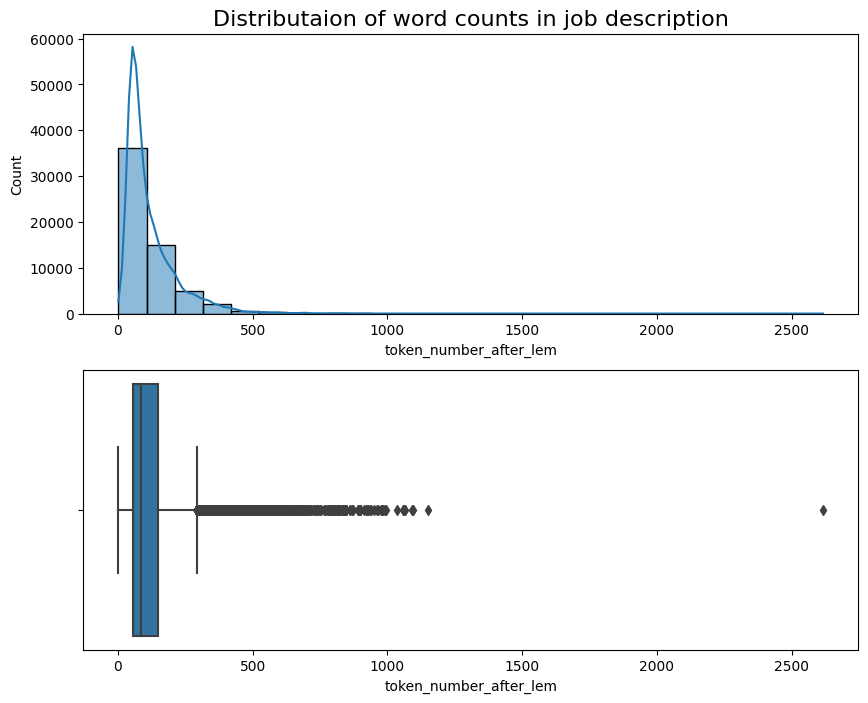

In [73]:
"""
Checking the distribution character of word counts

Statistic test to check character of distribution (ab-/normal):
- D'Agostino and Pearson normality test
- alpha = 0.05
"""
# Data visualisation: histogram and boxplot
fig, axes = plt.subplots(nrows=2, ncols=1, figsize=(10, 8))

histplot = sns.histplot(
    data=vacancies_temp,
    x="token_number_after_lem",
    bins=25,
    kde=True,
    ax=axes[0]);
histplot.set_title("Distributaion of word counts in job description",  fontsize=16);

boxplot = sns.boxplot(
    data=vacancies_temp,
    x="token_number_after_lem",
    orient="h",
    width=0.9,
    ax=axes[1]);

# Normality test: D'Agostino and Pearson
# Define hypothesis
H0 = "Normal distribution: Data is symmetrically distributed with no skew"
Ha = "NOT normal distribution: The data aren't normally distributed"

# p-value
alpha = 0.05

stat, p = normaltest(vacancies_temp["token_number_after_lem"])
print("Statistics=%.3f, p-value=%.3f" % (stat, p))

# Interpretation
if p > alpha:
    print(f"\n{H0}")
else:
    print(f"\n{Ha}")

Some observations:
* The data aren't normally distributed. There are outliers: one example with more than 2500 words in job description


In [74]:
"""
Look in details of example with 2616 word counts
"""
vacancies_temp[vacancies_temp["token_number_after_lem"] == 2616]["job_desc_lem"].iloc[0]

'administrative assistant st. cloud normal falsefalsefalse en usx nonex nonedef semi hidden true def qformat false def priority latent style count used false qformat true name normal unhide used false qformat true name heading unhide used false qformat true name title unhide used false qformat true name subtitle unhide used false qformat true name strong unhide used false qformat true name emphasis unhide used false name table grid unhide used false qformat true name spacing unhide used false name light shading unhide used false name light list unhide used false name light grid unhide used false name medium shading unhide used false name medium shading unhide used false name medium list unhide used false name medium list unhide used false name medium grid unhide used false name medium grid unhide used false name medium grid unhide used false name dark list unhide used false name colorful shading unhide used false name colorful list unhide used false name colorful grid unhide used false

This example of job description looks like a little bit strange, as multiple duplication of words. Maybe it has more sense to remove this row from dataset.

**So, what is it optimal number of words in job description?**

A job post should be long enough to be substantive, but short enough to keep a candidate’s attention. The job descriptions that perform best tend to fall between *300 and 660* words total.

*This conclustion is getting from articles (by this link: https://textio.com/blog/how-to-write-a-job-description-in-2020-best-practices-from-half-a-billion-job-postings/28706464272#:~:text=Hit%20the%20sweet%20spot%20for%20word%20count&text=A%20job%20post%20should%20be,300%20and%20660%20words%20total.)*

In our case if we calculate The Interquartile Range (IQR) (calculated as Q3 - Q1) - the middle 50% of the data consists of job description word counts around 95 (Q3 = 150, Q1 = 55). And I guess that it has a sense to remove examples with less than 10 word counts and more than 290 (based on 1.5*IQR values =~290). Because "300-660 words" is about full text of description with all part-of-speech. But I have clean text of job description with meaningful keywords.

Let's look at these examples.

In [75]:
# Check the number of examples with more than 290 word counts
print("Total number of examples in dataset: ")
display(vacancies_temp.shape[0])

print("\nNumber of examples with more than 290 word counts: ")
display(len(vacancies_temp[vacancies_temp["token_number_after_lem"] > 290]["Job_ID"]))

print("")
display(vacancies_temp[vacancies_temp["token_number_after_lem"] > 290]["job_desc_lem"].iloc[1])

Total number of examples in dataset: 


59269


Number of examples with more than 290 word counts: 


3926

'financial operation specialist undergraduate student program company state street corporation nyse stt world leading provider financial service institutional investor including investment servicing investment management investment research trading asset custody administration asset management june state street operates globally geographic market employ worldwide information visit state street website www.statestreet.com promoting culture excellence employee country state street people greatest asset recognize highly skilled engaged productive employee essential success company value reflect commitment employee engagement global inclusion corporate social responsibility help build fulfilling career world aim employer choice offering competitive compensation benefit personal professional development opportunity work environment promotes diverse array people idea skill company insists reward performance excellence know success hinge attracting best people join people state street support

In [76]:
"""
Check job description with less than 10 keywords
"""
print("Total number of examples in dataset: ")
display(vacancies_temp.shape[0])

print("\nNumber of job vacanies with equals or less than 10 keywords ")
display(vacancies_temp[vacancies_temp["token_number_after_lem"] <= 10]["Job_position"].count())

Total number of examples in dataset: 


59269


Number of job vacanies with equals or less than 10 keywords 


190

Some observations:
* The examples of job descriptions with word count *more than 290* is about 7%.
* The examples of job descriptions with word count *less (or equal) than 10* is about 0,3%.

I guess that I can delete them as outliers.

In [77]:
# Delete job description with less than 10 keywords and more than 290
vacancies_temp = vacancies_temp[(vacancies_temp["token_number_after_lem"] <= 290)&(vacancies_temp["token_number_after_lem"] > 10)]
vacancies_temp.shape[0]

55153

Statistics=7850.587, p-value=0.000

NOT normal distribution: The data aren't normally distributed


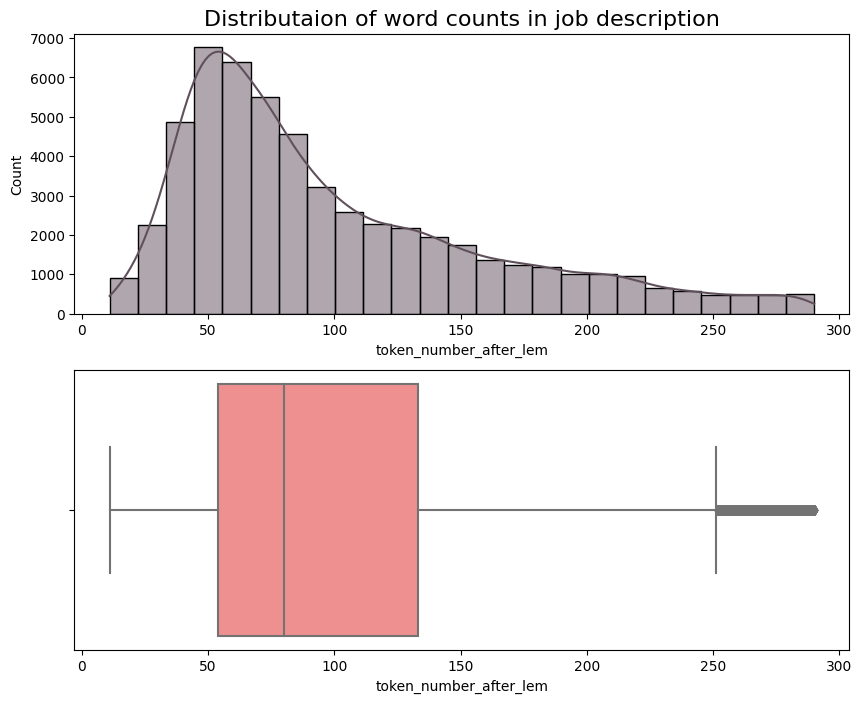

In [78]:
# Plot a boxplot and histplot of the word counts after deleting Outliers
fig, axes = plt.subplots(nrows=2, ncols=1, figsize=(10, 8))

histplot = sns.histplot(
    data=vacancies_temp,
    x="token_number_after_lem",
    color="#60505C",
    bins=25,
    kde=True,
    ax=axes[0]);
histplot.set_title("Distributaion of word counts in job description",  fontsize=16);

boxplot = sns.boxplot(
    data=vacancies_temp,
    x="token_number_after_lem",
    orient="h",
    color="#ff8080",
    width=0.9,
    ax=axes[1]);

# Normality test: D'Agostino and Pearson
# Define hypothesis
H0 = "Normal distribution: Data is symmetrically distributed with no skew"
Ha = "NOT normal distribution: The data aren't normally distributed"

# p-value
alpha = 0.05

stat, p = normaltest(vacancies_temp["token_number_after_lem"])
print("Statistics=%.3f, p-value=%.3f" % (stat, p))

# Interpretation
if p > alpha:
    print(f"\n{H0}")
else:
    print(f"\n{Ha}")

Some observations:
* The data aren't normally distributed. But I guess that we should stop to clean dataset based on word counts in job description, because we can lost meaningful part of information.

In [79]:
vacancies_temp.head(2)

,Job_ID,Job_position,Job_description,Job_title_and_desc,POS,POS_clean,clean_token,token_number,clean_job_desc,job_desc_lem,token_number_after_lem
0,111,Server,Tacolicious' first Palo Alto store just opened...,server tacolicious' first palo alto store...,"[(server, RB), (tacolicious, JJ), (', POS), (f...","[(server, RB), (tacolicious, JJ), (first, JJ),...","[server, tacolicious, first, palo, alto, store...",31,server tacolicious first palo alto store just ...,server tacolicious first palo alto store opene...,28
1,113,Kitchen Staff/Chef,\r\n\r\nNew French Brasserie in S.F. Financia...,kitchen staff/ chef \r\n\r\n new french ...,"[(kitchen, NN), (staff/, NN), (chef, NN), (new...","[(kitchen, NN), (staff/, NN), (chef, NN), (new...","[kitchen, staff/, chef, new, french, brasserie...",129,kitchen staff/ chef new french brasserie s.f f...,kitchen staff chef french brasserie s.f financ...,113


In [80]:
# Get the top 20 most common words among all the job descriptions
p_text = [word.split() for word in vacancies_temp["job_desc_lem"]]

# Flaten the list of lists
p_text = [item for sublist in p_text for item in sublist]

# Top 20
top_20 = pd.DataFrame(
    Counter(p_text).most_common(20),
    columns=["word", "frequency"]
)

top_20

,word,frequency
0,service,59028
1,customer,47032
2,care,46204
3,work,39177
4,experience,38198
5,position,36645
6,team,33017
7,opportunity,30596
8,company,29431
9,account,28115


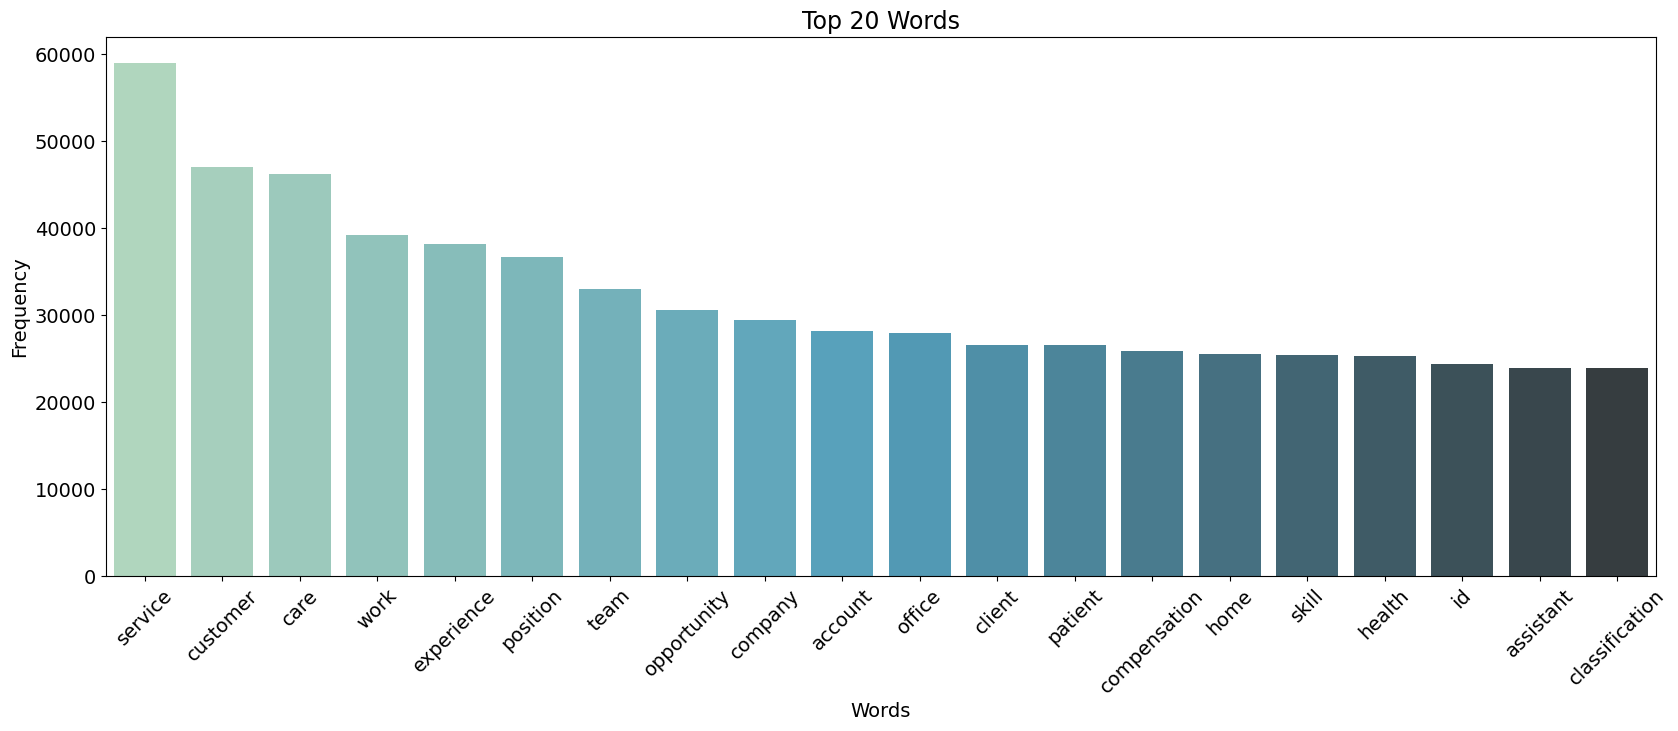

In [81]:
# Plot a bar chart for the top 20 most frequently occuring words
fig = plt.figure(figsize=(20,7))

g = sns.barplot(
    x="word",
    y="frequency",
    data=top_20,
    palette="GnBu_d"
)

g.set_xticklabels(
    g.get_xticklabels(),
    rotation=45,
    fontsize=14
)

plt.yticks(fontsize=14)
plt.xlabel("Words", fontsize=14)
plt.ylabel("Frequency", fontsize=14)
plt.title("Top 20 Words", fontsize=17)


plt.show()

Here are the **top 20 words** by frequency among all the descriptions after processing the text:

* ‘service’, ‘customer', ‘care’, 'experience' and ‘work’ are the top 5

In [82]:
# Get the number of unique words after processing
num_unique_words = len(set(p_text))
num_unique_words

39745

So, there is a lot of unique words here. I want to check it more: maybe some of the word has low high of frequency.

In [83]:
"""
Create dataset with frequency of unique words in job description
- Check the number of words with 1 and 5 frequency level
"""
top_all = pd.DataFrame(
    Counter(p_text).items(),
    columns=["word", "frequency"]
).sort_values(["frequency"], ascending=False)

display(top_all.head(2))

print("\nNumber of words with frequency level equals 1:")
display(top_all[top_all["frequency"] == 1]["word"].count())

print("\nNumber of words with frequency level equals or less than 10:")
display(top_all[top_all["frequency"] <= 10]["word"].count())

,word,frequency
77,service,59028
16,customer,47032



Number of words with frequency level equals 1:


14173


Number of words with frequency level equals or less than 10:


28561

In [84]:
top_all[top_all["frequency"] == 1]["word"][:50]

39238                   outpaced
38101                       adrn
33319                  rorschach
38122                destructing
32884                        ilo
38114               prairieville
37732                emsinet.com
38121                    suppler
32810                     ironer
38070                    conpany
37757                    bryanna
39336         internshipexposure
32809                        .be
32832                delineators
33367                    muliple
32833                  supports.
32898                    quantum
32801                  knolwedge
38094                     minmum
37758                coterminous
37781              pharmaceutcal
33347                   buidilng
39333                   refueled
37782                       iata
39230    www.charlottehungerford
33345                    nexsure
38093            dutiesrequested
32836                broadmeadow
32885    www.integrityliving.com
39229                 shrubbery.
33369     

*Type of words with frequency equals 1*

Some observations. There are examples with:
* company's site link or e-mail address ("www.integrityliving.com"),
* merged words (washesdishes, excelmonitor, dutiesrequested)
* abbreviation of word (a.s.,  c.p.r, qtg)
* misspelling of a word (responsable, specifictions, opportunies), etc.

All of these cases could be solved in further study. But in this project at the step of vectorize text data I'll use parameters as min_df and max_df
* max_df is used for removing terms that appear too frequently, also known as "corpus-specific stop words"
* min_df is used for removing terms that appear too infrequently

***

## 2.3 Text preprocessing: Vectorization - TF-IDF Vectorizer

In this project I use TF-IDF Vectorization (Term Frequency - Inverse Document Frequency)
* Term Frequency (TF): This summarizes how often a given word appears within a document
* Inverse Document Frequency (IDF): This downscales the words that appear a lot across documents.

TF-IDF Vectorizer takes into account not only how many times a word appears in a document but also how important that word is to the whole corpus.

Also I use *word level TF-IDF*: matrix representing tf-idf scores of every term in different documents.

In [85]:
"""
Vacancy dataset
update index value after removing rows
"""
vacancies_final = vacancies_temp.reset_index(drop=True)
display(vacancies_final.head(2))
display(vacancies_final.iloc[-2:])

print(f"Shape of final vacancy dataset: {vacancies_final.shape}")

,Job_ID,Job_position,Job_description,Job_title_and_desc,POS,POS_clean,clean_token,token_number,clean_job_desc,job_desc_lem,token_number_after_lem
0,111,Server,Tacolicious' first Palo Alto store just opened...,server tacolicious' first palo alto store...,"[(server, RB), (tacolicious, JJ), (', POS), (f...","[(server, RB), (tacolicious, JJ), (first, JJ),...","[server, tacolicious, first, palo, alto, store...",31,server tacolicious first palo alto store just ...,server tacolicious first palo alto store opene...,28
1,113,Kitchen Staff/Chef,\r\n\r\nNew French Brasserie in S.F. Financia...,kitchen staff/ chef \r\n\r\n new french ...,"[(kitchen, NN), (staff/, NN), (chef, NN), (new...","[(kitchen, NN), (staff/, NN), (chef, NN), (new...","[kitchen, staff/, chef, new, french, brasserie...",129,kitchen staff/ chef new french brasserie s.f f...,kitchen staff chef french brasserie s.f financ...,113


,Job_ID,Job_position,Job_description,Job_title_and_desc,POS,POS_clean,clean_token,token_number,clean_job_desc,job_desc_lem,token_number_after_lem
55151,84,Driver,ONIGILLY (Japanese rice ball wraps) seeks outg...,driver onigilly (japanese rice ball wraps) ...,"[(driver, NN), (onigilly, RB), ((, (), (japane...","[(driver, NN), (onigilly, RB), ((, (), (japane...","[driver, onigilly, japanese, rice, ball, wraps...",121,driver onigilly japanese rice ball wraps seeks...,driver onigilly japanese rice ball wrap seek o...,110
55152,88,Line Cook,We are a popular Mediterranean restaurant in F...,line cook we are a popular mediterranean ...,"[(line, NN), (cook, NN), (we, PRP), (are, VBP)...","[(line, NN), (cook, NN), (are, VBP), (popular,...","[line, cook, are, popular, mediterranean, rest...",41,line cook are popular mediterranean restaurant...,line cook popular mediterranean restaurant fin...,35


Shape of final vacancy dataset: (55153, 11)


In [86]:
"""
Get dataset with 5 columns
"""
vacancies_final = vacancies_final[["Job_ID", "Job_position", "Job_description", "Job_title_and_desc", "job_desc_lem"]].iloc[:]
display(vacancies_final.head(2))
print(f"Shape of final vacancy dataset: {vacancies_final.shape}")

,Job_ID,Job_position,Job_description,Job_title_and_desc,job_desc_lem
0,111,Server,Tacolicious' first Palo Alto store just opened...,server tacolicious' first palo alto store...,server tacolicious first palo alto store opene...
1,113,Kitchen Staff/Chef,\r\n\r\nNew French Brasserie in S.F. Financia...,kitchen staff/ chef \r\n\r\n new french ...,kitchen staff chef french brasserie s.f financ...


Shape of final vacancy dataset: (55153, 5)


In [87]:
"""
Generate tfidf matrix model for entire corpus
* ‘min_df’ to 5 which will tell the model to ignore words that appear in less than 5 of the job descriptions.
* ‘max_df’ to .95 which will tell the model to ignore words that appear in more than 95% of the job descriptions.

This will help eliminate words that don’t contribute positively to the model.
Also, reducing the number of words (tokens) will help save time on running the model.

But of course it is better to leave the min, max parameters unchanged in order to get high quality of clustering.
But I have not enough machine's processing capabilities in order to run model faster on the defualt parameters.
"""
tfidf_vect = TfidfVectorizer(min_df=5,
                             max_df=0.95
                            )

tfidf = tfidf_vect.fit(vacancies_final["job_desc_lem"]) #fitting the vector
tfidf

TfidfVectorizer(max_df=0.95, min_df=5)

***

# 3. Resume recommendation based on similarity score

In [88]:
"""
Text preprocessing of Resumes dataset - we can do it or not.
In this case I run without text preprocessing of New data
"""
# # Concat Job title and Job description text into one column
# resume_temp["Job_title_and_desc"] = resume_temp["Job_title"].map(str) + "  " + resume_temp["Job_description"]

# #Text preprocessing
# resume_temp = text_preprocessing(resume_temp)

# # Get POS tags
# resume_temp = get_pos(resume_temp)
# vacancies_temp = get_informative_token(resume_temp)
# vacancies_temp = get_only_token(resume_temp)
# vacancies_temp = get_count_of_tokens(resume_temp)

# # Delete tokens with 1 character
# resume_temp["clean_token"] = [[subelt for subelt in elt if len(subelt) > 1] for elt in resume_temp["clean_token"]]

# #update count_token_number_in_job column
# resume_temp = get_count_of_tokens(resume_temp)

# # Put back tokens into one single string for lemmatization
# resume_temp["clean_job_desc"] = [" ".join(x) for x in resume_temp["clean_token"]]

# # Get new column with lemmatize text
# resume_temp["job_desc_lem"] = resume_temp["clean_job_desc"].apply(lemmatize_sentence)

# # Update count_token_number_in_job column
# resume_temp["token_number_after_lem"] = [len(word.split()) for word in resume_temp["job_desc_lem"]]

'\nText preprocessing of Resumes dataset - we can do it or not.\nIn this case I run without text preprocessing of New data\n'

In [89]:
"""
Pickle datasets that will be used later
"""
vacancies_final.to_pickle("./vacancies_preprocess.pkl") # "preprocess_data/vacancies_preprocess.pkl"
resume_temp.to_pickle("./resumes_preprocess.pkl") # "preprocess_data/resumes_preprocess.pkl"

In [90]:
# Read the last version
vacancies_final = pd.read_pickle("./vacancies_preprocess.pkl")
resume_final = pd.read_pickle("./resumes_preprocess.pkl")

It's simple way to build Recommender system based on similarity score

I use linear_kernel (not cosine_similarity) because we already get normalized vectors after TF-IDF.

In [91]:
# Vectorize applicants' job experience
resumes_tfidf = tfidf_vect.transform(resume_final["Job_description"])
resumes_tfidf

<2313x14206 sparse matrix of type '<class 'numpy.float64'>'
	with 101187 stored elements in Compressed Sparse Row format>

In [92]:
# Choose vacancy id
vacancies_final.head(3)

,Job_ID,Job_position,Job_description,Job_title_and_desc,job_desc_lem
0,111,Server,Tacolicious' first Palo Alto store just opened...,server tacolicious' first palo alto store...,server tacolicious first palo alto store opene...
1,113,Kitchen Staff/Chef,\r\n\r\nNew French Brasserie in S.F. Financia...,kitchen staff/ chef \r\n\r\n new french ...,kitchen staff chef french brasserie s.f financ...
2,117,Bartender,We are a popular Mediterranean wine bar and re...,bartender we are a popular mediterranean w...,bartender popular mediterranean wine bar resta...


In [93]:
"""
Create recommendation of resumes by Job ID
"""
def resumes_to_vacancy(job_id):
    # get vacancy id as an index
    v = job_id
    
    if v in vacancies_final["Job_ID"].tolist():
        index = np.where(vacancies_final["Job_ID"] == v)[0][:]
        vacancy_q = vacancies_final.iloc[index[0]:(index[-1]+1)]
        
        print(f"Information about Vacancy: {v}")
        display(vacancy_q)
        
        # Vectorize vacancy's job description
        vacancy_tfidf = tfidf_vect.transform(vacancy_q["Job_description"])
        
        # compute similarity score
        similarity_score = map(lambda x: linear_kernel(vacancy_tfidf, x), resumes_tfidf)
        output = list(similarity_score)
        
        # getting the job id's of the recommendations
        top = sorted(range(len(output)), key=lambda i: output[i], reverse=True)[:10]
        recommendation = pd.DataFrame(columns = ["Job_ID", "Recommended_Applicant_ID"])
        count = 0
        
        for i in top:
            recommendation.at[count, "Job_ID"] = v
            recommendation.at[count, "Recommended_Applicant_ID"] = resume_final["Applicant_ID"].iloc[i]
            count += 1
            
        # getting the job ids and their data
        nearest_candidates = recommendation["Recommended_Applicant_ID"]
        applicant_recommended = pd.DataFrame(columns = ["Job_ID", "Job_position", "Recommended_Applicant_ID", "Work_experience", "Previous_job"])
        
        for id in nearest_candidates:
            index_resume = resume_final.index[resume_final["Applicant_ID"] == id][0]
            # index = np.where(vacancies_final["Job_ID"] == id)[0][0] - different result
            applicant_recommended.at[count, "Job_ID"] = v
            applicant_recommended.at[count, "Job_position"] = vacancies_final[vacancies_final["Job_ID"] == v]["Job_position"].iloc[0]
            applicant_recommended.at[count, "Recommended_Applicant_ID"] = id
            applicant_recommended.at[count, "Work_experience"] = resume_final["Job_description"][index_resume]
            applicant_recommended.at[count, "Previous_job"] = resume_final["Job_title"][index_resume]
            count += 1
            
        print(f"\nRecommended Applicant_id for Vacancy {v}\n")
        
    else:
        return ("This Job_ID is not in Vacancies' list")
        
    return applicant_recommended

In [94]:
resumes_to_vacancy(129)

Information about Vacancy: 129


,Job_ID,Job_position,Job_description,Job_title_and_desc,job_desc_lem
5,129,Receptionist,We are a group of professional massage therapi...,receptionist we are a group of professional...,receptionist group professional massage therap...



Recommended Applicant_id for Vacancy 129



,Job_ID,Job_position,Recommended_Applicant_ID,Work_experience,Previous_job
10,129,Receptionist,4558,People are rude,Waiter
11,129,Receptionist,2850,We believe in the pursuers of dreams. Those pe...,Founder
12,129,Receptionist,539,Ensure that each person gets the best customer...,Lead Server
13,129,Receptionist,2444,"I mainily, wash and detail new, used, and rent...",Car Detailer Manager
14,129,Receptionist,2763,answer inbound phone calls and direct them to ...,Receptionist 88M/92G 88MIC Motor Transport Ope...
15,129,Receptionist,5024,Children are my priority,Yard duty.
16,129,Receptionist,3657,"If you see me at my job, you are kind of in tr...",Legal Paper Pusher
17,129,Receptionist,2214,ProfyleTracker was founded and developed throu...,Business Development Manager Senior Recruitmen...
18,129,Receptionist,9704,Founder of JobArrive. \r\n\r\nJobArrive is a l...,"Founder/CEO Sr. Strategist, Commerce Ops Summe..."
19,129,Receptionist,11366,-Assist leadership with complex supply problem...,Supply Technician Assistant Manager Sales Asso...


In [95]:
"""
Create recommendation of vacancies by Applicant ID
"""
def vacancies_for_resume(applicant_id):
    u = applicant_id
    
    if u in resume_final["Applicant_ID"].tolist():
        index = np.where(resume_final["Applicant_ID"] == u)[0][:]
        user_q = resume_final.iloc[index[0]:(index[-1]+1)] # in case if we have more than one rows with applicant_ID
        
        print(f"Information about Applicant: {u}")
        display(user_q)
        
        # Vectorize applicant job experience
        user_tfidf = tfidf_vect.transform(user_q["Job_description"])
        job_tfidf = tfidf_vect.transform(vacancies_final["Job_description"])
        
        # compute similarity score
        similarity_score = map(lambda x: linear_kernel(user_tfidf, x), job_tfidf)
        output2 = list(similarity_score)
        
        # It is necessary to use if-else statement in order to check examples with ONE resume or MORE than ONE resume.
        # Because it needs different action steps to create recommendation for the Applicant
        if len(output2[:][0]) > 1:
            print("\nThis Applicant has more than 1 resume (different job description)\n")
            output2_list = [arr.tolist() for arr in output2] # get list of lists from array
            
            # get pair of similarity value for every job description without extra square brackets
            output2_list_el = []
            for x in output2_list:
                output2_list_el.append([el[0] for el in x])
            
            # getting the job id's of the recommendations - top-20
            top = sorted(range(len(output2_list_el)), key=lambda i: output2_list_el[i], reverse=True)[:10]
            recommendation = pd.DataFrame(columns = ["Applicant_ID", "Recommended_Job_ID"])
            count = 0
            
            for i in top:
                recommendation.at[count, "Applicant_ID"] = u
                recommendation.at[count, "Recommended_Job_ID"] = vacancies_final["Job_ID"].iloc[i]
                count += 1
            # getting the job ids and their data
            nearestjobs = recommendation["Recommended_Job_ID"]
            job_recommended = pd.DataFrame(columns = ["Applicant_ID", "Applicant_job_title", "Recommended_Job_ID", "Job_description", "Job_title"])
            
            for id in nearestjobs:
                index_vacancy = vacancies_final.index[vacancies_final["Job_ID"] == id][0]
                # index = np.where(vacancies_final["Job_ID"] == id)[0][0] - different result
                job_recommended.at[count, "Applicant_ID"] = u
                job_recommended.at[count, "Applicant_job_title"] = resume_final["Job_title"].iloc[index[0]:(index[-1]+1)].tolist()
                job_recommended.at[count, "Recommended_Job_ID"] = id
                job_recommended.at[count, "Job_description"] = vacancies_final["Job_description"][index_vacancy]
                job_recommended.at[count, "Job_title"] = vacancies_final["Job_position"][index_vacancy]
                count += 1
            display(job_recommended.head())
        else:
            print("\nThis Applicant has only 1 resume\n")
            
            # getting the job id's of the recommendations
            top = sorted(range(len(output2)), key=lambda i: output2[i], reverse=True)[:10]
            recommendation = pd.DataFrame(columns = ["Applicant_ID", "Recommended_Job_ID"])
            count = 0
            
            for i in top:
                recommendation.at[count, "Applicant_ID"] = u
                recommendation.at[count, "Recommended_Job_ID"] = vacancies_final["Job_ID"].iloc[i]
                count += 1
            
            # getting the job ids and their data
            nearestjobs = recommendation["Recommended_Job_ID"]
            job_recommended = pd.DataFrame(columns = ["Applicant_ID", "Applicant_job_title", "Recommended_Job_ID", "Job_description", "Job_title"])
            
            for id in nearestjobs:
                index_vacancy = vacancies_final.index[vacancies_final["Job_ID"] == id][0]
                # index = np.where(vacancies_final["Job_ID"] == id)[0][0] - different result
                job_recommended.at[count, "Applicant_ID"] = u
                job_recommended.at[count, "Applicant_job_title"] = resume_final["Job_title"].iloc[index[0]:(index[-1]+1)].tolist()
                job_recommended.at[count, "Recommended_Job_ID"] = id
                job_recommended.at[count, "Job_description"] = vacancies_final["Job_description"][index_vacancy]
                job_recommended.at[count, "Job_title"] = vacancies_final["Job_position"][index_vacancy]
                count += 1
            
            print(f"\nRecommended Job_id for Applicant {u}\n")
    else:
        return ("This Applicant_ID is not in Resumes' list")

    return (job_recommended)

In [96]:
vacancies_for_resume(14092)

Information about Applicant: 14092


,Applicant_ID,Job_title,Job_description
2174,14092,Customer Service Representative Assistant Mana...,Take calls from customers seeking health insur...



This Applicant has only 1 resume


Recommended Job_id for Applicant 14092



,Applicant_ID,Applicant_job_title,Recommended_Job_ID,Job_description,Job_title
10,14092,[Customer Service Representative Assistant Man...,266575,Diet Aide reports to and is under the authorit...,"Food Service Worker I - Part Time, Rotating Sh..."
11,14092,[Customer Service Representative Assistant Man...,313707,\r\n\r\n\r\nAnswers and directs phone calls fo...,Customer Service Representative/Cashier
12,14092,[Customer Service Representative Assistant Man...,284826,Ref ID: 02500-9738680Classification: Customer ...,Customer Service Representative
13,14092,[Customer Service Representative Assistant Man...,318502,Exciting Opportunities with A Growing Organiza...,Retail Sales Associates (Part-time)
14,14092,[Customer Service Representative Assistant Man...,301864,Exciting Opportunities with A Growing Organiza...,Retail Sales Associates (Part-time)
15,14092,[Customer Service Representative Assistant Man...,278043,Exciting Opportunities with A Growing Organiza...,Retail Sales Associates (Part-time)
16,14092,[Customer Service Representative Assistant Man...,307926,Receptionist\r\nThe individual in this positio...,Part-time Afternoon Receptionist
17,14092,[Customer Service Representative Assistant Man...,279922,"For over 50 years, National Church Residences ...",Cook - Part Time
18,14092,[Customer Service Representative Assistant Man...,136562,Ref ID: 02101-107570Classification: Customer S...,Customer Service Representative
19,14092,[Customer Service Representative Assistant Man...,289160,Ref ID: 02101-107822Classification: Customer S...,Customer Service Representative


It's look like as a working instrument. But in this case some applicants have more than one resume corresponds to different job position - not the same.
* *customer service representative* - *cashier* - *volunteer services coordinator assistant*

And they describe different side of job.

Moreover, for me, as HR (for example) it is more interesting to get better result in recommendation lists of pull of resumes to vacancy (resumes_to_vacancy). The result as *Founder/CEO Sr. Strategist* / *Car Detailer Manager* / *Server* for *Receptionist* job position looks like very poor.

Let's look at the other possibilities, for example **Clusterization** in order to get more specific recommendation based on the clusters.

***

# 4. Clustering
## 4.1 Clustering: Preparing dataset

***

## Vacancy data
Run models on the all dataset in order to check accurate clusters number has a lot of time (more than 1.5 hours for model), because we have a lot of features (~14K from matrix shape). That's why I want to use only part of the dataset.

Also I want to get stratified sample which includes subjects from every subgroup (in this case it is Job title), ensuring that it reflects the diversity of examples.

In [97]:
display(vacancies_final.head(2))
print(f"\nVacancy dataset shape: {vacancies_final.shape}")
print(f"\nNumber of unique Job titles: {vacancies_final.Job_position.nunique()}")

,Job_ID,Job_position,Job_description,Job_title_and_desc,job_desc_lem
0,111,Server,Tacolicious' first Palo Alto store just opened...,server tacolicious' first palo alto store...,server tacolicious first palo alto store opene...
1,113,Kitchen Staff/Chef,\r\n\r\nNew French Brasserie in S.F. Financia...,kitchen staff/ chef \r\n\r\n new french ...,kitchen staff chef french brasserie s.f financ...



Vacancy dataset shape: (55153, 5)

Number of unique Job titles: 28919


In [98]:
job_title_vac = vacancies_final["Job_position"].value_counts().reset_index()
job_title_vac.columns = ["Job_position", "count"]

print("\nNumber of job title that occured only ONCE in dataset: \n")
display(job_title_vac[job_title_vac["count"] == 1]["count"].sum())

print("\nNumber of job title with more than 10 frequency: \n")
display(job_title_vac[job_title_vac["count"] >= 10]["count"].sum())


Number of job title that occured only ONCE in dataset: 



25114


Number of job title with more than 10 frequency: 



19685

In [99]:
"""
Add frequecy count as new column to DataFrame
"""
vacancies_final["frequency_job_title"] = vacancies_final.groupby("Job_position")["Job_position"].transform("count")
vacancies_final.head(2)

,Job_ID,Job_position,Job_description,Job_title_and_desc,job_desc_lem,frequency_job_title
0,111,Server,Tacolicious' first Palo Alto store just opened...,server tacolicious' first palo alto store...,server tacolicious first palo alto store opene...,94
1,113,Kitchen Staff/Chef,\r\n\r\nNew French Brasserie in S.F. Financia...,kitchen staff/ chef \r\n\r\n new french ...,kitchen staff chef french brasserie s.f financ...,5


In [100]:
"""
Take examples of dataset where frequency of job titles less than 10
"""
vacancies_part = vacancies_final[vacancies_final["frequency_job_title"] >= 10]
display(vacancies_part.head(2))
print(f"\nShape of vacancy dataset for get clusters: {vacancies_part.shape}")

,Job_ID,Job_position,Job_description,Job_title_and_desc,job_desc_lem,frequency_job_title
0,111,Server,Tacolicious' first Palo Alto store just opened...,server tacolicious' first palo alto store...,server tacolicious first palo alto store opene...,94
2,117,Bartender,We are a popular Mediterranean wine bar and re...,bartender we are a popular mediterranean w...,bartender popular mediterranean wine bar resta...,16



Shape of vacancy dataset for get clusters: (19685, 6)


After removing examples from dataset which job title is occured less than 10 times, we get about 20K examples.

Maybe it has more sense to use all of these examples for creating clusters. But I want to ise only part (less number of features -> less time for model training)

In [101]:
# Get ratio instead of raw numbers using normalize=True
expected_ratio = vacancies_part["Job_position"].value_counts(normalize=True)

# Round and then convert to percentage
expected_ratio = expected_ratio.round(4)*100

# convert to a DataFrame and store in variable 'island_ratios'
# We'll use this variable to compare ratios for samples 
# selected using SRS and Stratified Sampling 
job_title_ratios = pd.DataFrame({'Expected':expected_ratio})
job_title_ratios

,Expected
Job_position,
Administrative Assistant,7.10
Customer Service Representative,6.16
Accounts Payable Clerk,4.92
Accounting Clerk,4.83
Staff Accountant,4.60
...,...
Intake Coordinator,0.05
Kitchen Staff,0.05
Office Assistant / Customer Service / Receptionist,0.05


In [102]:
stratified_sample = vacancies_part.groupby("Job_position").apply(lambda x: x.sample(frac=0.80))
display(stratified_sample.head(2))

# Remove the extra index added by groupby()
stratified_sample = stratified_sample.droplevel(0)
display(stratified_sample.head(2))

Job_ID Job_position  \
Job_position                              
Accountant   49671  309049   Accountant   
             1003   137782   Accountant   

                                                      Job_description  \
Job_position                                                            
Accountant   49671  Ref ID:02220-9742418Classification:Accountant ...   
             1003   Accountant - Full Time\r\nImmediate Job Openin...   

                                                   Job_title_and_desc  \
Job_position                                                            
Accountant   49671   accountant   ref  id:02220-9742418classificat...   
             1003    accountant   accountant -  full  time\r\n imm...   

                                                         job_desc_lem  \
Job_position                                                            
Accountant   49671  accountant ref id classification accountant st...   
             1003   accountant accountant full immediate job openi...   

                    frequency_job_title  
Job_position                             
Accountant   49671                   40  
             1003                    40

,Job_ID,Job_position,Job_description,Job_title_and_desc,job_desc_lem,frequency_job_title
49671,309049,Accountant,Ref ID:02220-9742418Classification:Accountant ...,accountant ref id:02220-9742418classificat...,accountant ref id classification accountant st...,40
1003,137782,Accountant,Accountant - Full Time\r\nImmediate Job Openin...,accountant accountant - full time\r\n imm...,accountant accountant full immediate job openi...,40


In [103]:
# Ratio of selected items by the island
stratified_ratio = stratified_sample["Job_position"].value_counts(normalize=True)

# Convert to percentage
stratified_ratio = stratified_ratio.round(4)*100

# We did stratified sampling. So give it proper name
stratified_ratio.name = "Stratified"

# Add it to the variable job_title_ratios which already has 
# the  expected and SRS proportions 
job_title_ratios = pd.concat([job_title_ratios, stratified_ratio], axis=1)
job_title_ratios

,Expected,Stratified
Job_position,,
Administrative Assistant,7.10,7.10
Customer Service Representative,6.16,6.16
Accounts Payable Clerk,4.92,4.92
Accounting Clerk,4.83,4.83
Staff Accountant,4.60,4.60
...,...,...
Intake Coordinator,0.05,0.05
Kitchen Staff,0.05,0.05
Office Assistant / Customer Service / Receptionist,0.05,0.05


In [104]:
"""
Vacancy dataset
update index value after removing rows
"""
strat_vacancy_df = vacancies_part.reset_index(drop=True)
display(strat_vacancy_df.head(2))
display(strat_vacancy_df.iloc[-2:])

print(f"Shape of stratified vacancy dataset: {strat_vacancy_df.shape}")

,Job_ID,Job_position,Job_description,Job_title_and_desc,job_desc_lem,frequency_job_title
0,111,Server,Tacolicious' first Palo Alto store just opened...,server tacolicious' first palo alto store...,server tacolicious first palo alto store opene...,94
1,117,Bartender,We are a popular Mediterranean wine bar and re...,bartender we are a popular mediterranean w...,bartender popular mediterranean wine bar resta...,16


,Job_ID,Job_position,Job_description,Job_title_and_desc,job_desc_lem,frequency_job_title
19683,84,Driver,ONIGILLY (Japanese rice ball wraps) seeks outg...,driver onigilly (japanese rice ball wraps) ...,driver onigilly japanese rice ball wrap seek o...,72
19684,88,Line Cook,We are a popular Mediterranean restaurant in F...,line cook we are a popular mediterranean ...,line cook popular mediterranean restaurant fin...,26


Shape of stratified vacancy dataset: (19685, 6)


So I got stratified (by Job_title) part of dataset for use it as train for getting clusters number

## 4.2 Text clustering: TF-IDF + TruncatedSVD + clustering algorithms

Using clustering can address several known issues in recommendation systems, including increasing the diversity, consistency and reliability of recommendations.

**K-means** is a well-liked unsupervised learning algorithm that organizes data points into groups based on similarities. The algorithm operates by iteratively assigning each data point to its nearest cluster centroid and then recalculating the centroids based on the newly formed clusters.
**Hierarchical agglomerative clustering** is good for this task (text clustering) because documents are non-lattice, non-real valued data that do not live in Euclidean space. Furthermore, this method accounts for the overlapping/concentric structure of topic clusters in document-based data.
**DBSCAN** is a density-based clustering algorithm that groups together points that are closely packed together (i.e., high density) and separates points that are far apart (i.e., low density). But if there are 

In this notebook, we extract TF-IDF features to get a representation of the document at a high level instead, and then apply dimensionality reduction by TruncatedSVD in order to get less features than we have now.

**Steps**:
1) Vectorise our dataset by TfIdfVectorizer()

2) Reduce the dimensionality of the data using TruncatedSVD()
    - *TruncatedSVD is a popular method for dimensionality reduction. However, it works better with sparse data than PCA. This estimator does not center the data before computing the singular value decomposition. In particular, truncated SVD works on term count/tf-idf matrices as returned by the vectorizers*
    
3) Use clustering model - the standard k-means algorithm (actually, a refined variant called k-means++)
    
    - Identifying optimal number of clusters. Our case: the ground truth of a data set is not available. I use Intrinsic Methods to evaluate the clustering quality by examining how well the clusters are separated and how compact the clusters are by:
    
        - Elbow method
            - If the line chart resembles an arm, then the “elbow” (the point of inflection on the curve) is a good indication that the underlying model fits best at that point.
            
        - Silhouette score
            - It is a way to measure how close each point in a cluster to the points in its neighbouring clusters. Silhouette values lies in the range of [-1. 1]. Higher the value is better the cluster configuration. And it is more easy to check number of clusters based on this plot.
            
        - Gap Statistics
            - It standardizes the graph of log(Wk), where Wk is the within-cluster dispersion, by comparing it to its expectation under an appropriate null reference distribution of the data.
            
    - Train clustering model in order to get clusters in full data
    
4) Data visualization: dimensionality reduction by TSNE (non-linear technique)

In [105]:
#Generate tfidf matrix model for entire corpus - update it with new vocabulary
tfidf_train = TfidfVectorizer(min_df=5, max_df=0.95)

job_part_tfidf = tfidf_train.fit_transform(strat_vacancy_df["job_desc_lem"])
job_part_tfidf

<19685x6934 sparse matrix of type '<class 'numpy.float64'>'
	with 1178962 stored elements in Compressed Sparse Row format>

In [106]:
job_part_tfidf.todense()
print(job_part_tfidf.shape)

(19685, 6934)


Again, we have 19,685 job descriptions and 6,934 unique words.

~7K - It's a lot of features. It's time to reduce dimension

### Dimensionality reduction:
Truncated SVD on the TF-IDF matrix to obtain a low-rank approximation of the original matrix

In [107]:
# Create and run an TSVD with one less than number of features
t0 = time()

tsvd = TruncatedSVD(n_components=job_part_tfidf.shape[1]-1)
X_tsvd = tsvd.fit(job_part_tfidf)

print(f"\nDimensionality reduction with SVD done in {time() - t0:.3f} s")


Dimensionality reduction with SVD done in 477.911 s


In [108]:
# List of explained variances
tsvd_var_ratios = tsvd.explained_variance_ratio_

In [109]:
"""
Create a function to select the best number of components
"""
def select_n_components(var_ratio, goal_var):
    # Set initial variance explained so far
    total_variance = 0.0
    
    # Set initial number of features
    n_components = 0
    
    # For the explained variance of each feature:
    for explained_variance in var_ratio:
        total_variance += explained_variance #add the explained variance to the total
        n_components += 1 #add one to the number of components
        
        if total_variance >= goal_var: #if we reach our goal level of explained variance
            # End the loop
            break
            
    # Return the number of components
    return n_components

In [110]:
# Run function
select_n_components(tsvd_var_ratios, 0.95)

2588

Now we get optimal number of components to do dimensionality reduction by TruncatedSVD. Explained variance of the SVD: 94.9%

In [111]:
# Dimensionality reduction by TruncatedSVD() with optimal number of components
tsvd_train = TruncatedSVD(n_components=2588)
tsvd_matrix = tsvd_train.fit_transform(job_part_tfidf)
explained_variance = tsvd_train.explained_variance_ratio_.sum()

print(f"Shape of matrix: {tsvd_matrix.shape}")
print(f"\nExplained variance of the SVD step: {explained_variance * 100:.1f}%")

Shape of matrix: (19685, 2588)

Explained variance of the SVD step: 94.9%


### Identifying the optimal number of clusters
- Elbow method
- Silhouette score
- Gap Statistic

In [112]:
# Create list of inertia and silhouette_score values in different number of clusters
t0 = time()

wcss = []
silhouette = []

# training k_means model
# Fit on data (no need to normalize data, it already is due to TF-IDF)
for i in range(5,101,5):
    kmeans = KMeans(n_clusters=i, init="k-means++", n_init=10, random_state=RANDOM_SEED)
    kmeans.fit(tsvd_matrix)
    wcss.append(kmeans.inertia_)
    silhouette.append(silhouette_score(tsvd_matrix, kmeans.labels_))
    
print(f"\nModel running with 20 different number of clusters done in {time() - t0:.3f} s")


Model running with 20 different number of clusters done in 2591.135 s


Text(0, 0.5, 'Inertia value')

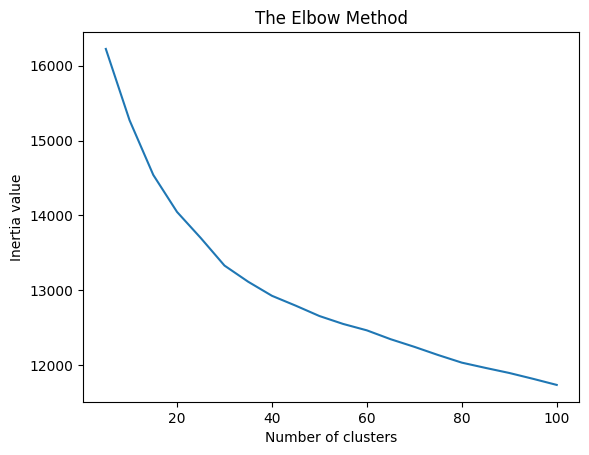

In [113]:
"""
Elbow method plot
"""
plt.plot(range(5,101,5), wcss)
plt.title("The Elbow Method")
plt.xlabel("Number of clusters")
plt.ylabel("Inertia value")

Text(0, 0.5, 'Silhouette score')

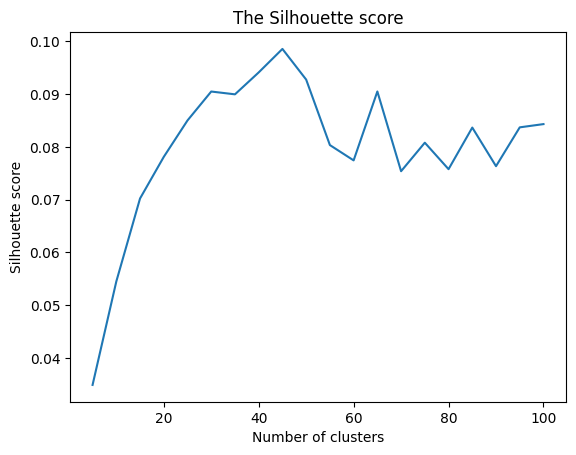

In [114]:
"""
Silhouette score plot
"""
plt.plot(range(5,101,5), silhouette)
plt.title("The Silhouette score")
plt.xlabel("Number of clusters")
plt.ylabel("Silhouette score")

In [115]:
max_score = max(silhouette)
print(f"Optimal number of clusters - {silhouette.index(max_score)*5+5} with silhouette score value: {round(max_score, 3)}")

Optimal number of clusters - 45 with silhouette score value: 0.099


In [116]:
# this code from https://www.kaggle.com/code/mallikarjunaj/gap-statistics
"""
Gap Statistic
"""
def optimalK(data, maxClusters):
    """
    Calculates KMeans optimal K using Gap Statistic from Tibshirani, Walther, Hastie
    Params:
        data: ndarry of shape (n_samples, n_features)
        nrefs: number of sample reference datasets to create
        maxClusters: Maximum number of clusters to test for
    Returns: (gaps, optimalK)
    """
    nrefs = 3
    gaps = np.zeros((len(range(5, maxClusters+1, 5)),))
    resultsdf = pd.DataFrame(
        {
            "clusterCount":[],
            "gap":[]
        })
    
    for gap_index, k in enumerate(range(5, maxClusters+1, 5)):

        # Holder for reference dispersion results
        refDisps = np.zeros(nrefs)

        # For n references, generate random sample and perform kmeans getting resulting dispersion of each loop
        for i in range(nrefs):
            
            # Create new random reference set
            randomReference = np.random.random_sample(size=data.shape)
            
            # Fit to it
            km = KMeans(k)
            km.fit(randomReference)
            
            refDisp = km.inertia_
            refDisps[i] = refDisp
            
        # Fit cluster to original data and create dispersion
        km = KMeans(k)
        km.fit(data)
        
        origDisp = km.inertia_

        # Calculate gap statistic
        gap = np.log(np.mean(refDisps)) - np.log(origDisp)

        # Assign this loop's gap statistic to gaps
        gaps[gap_index] = gap
        
        resultsdf.loc[len(resultsdf)] = {"clusterCount": k, "gap": gap}

    return resultsdf

In [117]:
t0 = time()

gapdf = optimalK(tsvd_matrix, maxClusters=75)
optimal_k = gapdf[gapdf["gap"] == gapdf["gap"].max()]["clusterCount"].iloc[0]

print(f"Optimal k is: {optimal_k}")
print(f"Calculating KMeans optimal K using Gap Statistic done in {time() - t0:.3f} s")

Optimal k is: 75
Calculating KMeans optimal K using Gap Statistic done in 4051.838 s


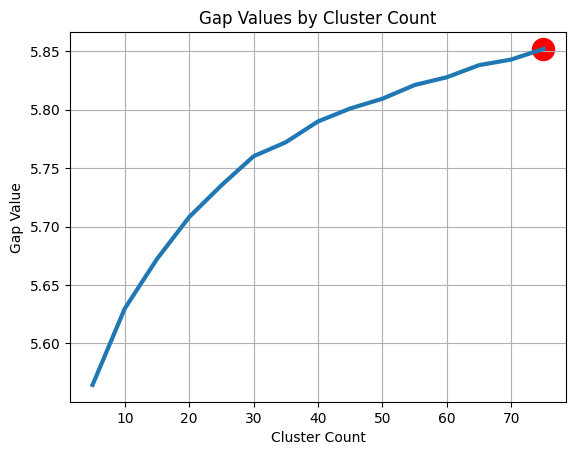

In [118]:
plt.plot(gapdf.clusterCount, gapdf.gap, linewidth=3)
plt.scatter(gapdf[gapdf.clusterCount == optimal_k].clusterCount, gapdf[gapdf.clusterCount == optimal_k].gap, s=250, c="r")
plt.grid(True)
plt.xlabel("Cluster Count")
plt.ylabel("Gap Value")
plt.title("Gap Values by Cluster Count")
plt.show()

Some observations:
* I can't see a clear elbow, so look at silhoutte score plot or check gap statistic to find the right number of clusters.
* Silhouette score plot:
    * The best score is around 0.1. This value is near 0 and denote overlapping clusters. It indicates that the sample is on or very close to the decision boundary between two neighboring clusters.
    * The highest value of silhouette score is around 45 clusters (0.099).
* Gap statistic:
    * optimal number of clusters is more than 75. Actually is more than 100 too (I get this result when run this function with different maxClusters).

Under conditions of uncertainty, different algorithms can generate competing solutions.

I guess that now we should use as the number of clusters - 45. It's not a lof of and allows us to save some diversity

***

In [119]:
"""
Before we start to test another clustering algorithms
I want to check one more time how will be better - to use only TF-IDF vectorizer or with TruncatedSVD?
"""
t0 = time()

# run kmeans model with TF-IDF vectors
kmeans_tfidf = KMeans(n_clusters=45, init="k-means++", n_init=10, random_state=RANDOM_SEED)
kmeans_tfidf_clusters = kmeans_tfidf.fit_predict(job_part_tfidf)

print(f"KMeans\non tf-idf vectors: {round(silhouette_score(job_part_tfidf, kmeans_tfidf_clusters), 4)}")
print(f"\nModel running done in {time() - t0:.3f} s")

KMeans
on tf-idf vectors: 0.0897

Model running done in 56.525 s


In [120]:
t0 = time()

# run MiniBatchKMeans model on TF-IDF vectors
minibatch_tfidf = MiniBatchKMeans(n_clusters=45, n_init=10, random_state=RANDOM_SEED, init_size=1000, batch_size=1000)
minibatch_tfidf_clusters = minibatch_tfidf.fit_predict(job_part_tfidf)

print(f"MiniBatchKMeans\non tf-idf vectors: {round(silhouette_score(job_part_tfidf, minibatch_tfidf_clusters), 4)}")
print(f"\nModel running done in {time() - t0:.3f} s")

MiniBatchKMeans
on tf-idf vectors: 0.0803

Model running done in 27.817 s


In [121]:
t0 = time()

# run kmeans model with LSA on TF-IDF vectors
kmeans_lsa = KMeans(n_clusters=45, init="k-means++", n_init=10, random_state=RANDOM_SEED)
kmeans_lsa_clusters = kmeans_lsa.fit_predict(tsvd_matrix)

print(f"KMeans with LSA\non tf-idf vectors: {round(silhouette_score(tsvd_matrix, kmeans_lsa_clusters), 4)}")
print(f"\nModel running done in {time() - t0:.3f} s")

KMeans with LSA
on tf-idf vectors: 0.0986

Model running done in 118.065 s


In [122]:
t0 = time()

# run MiniBatchKMeans model with LSA on TF-IDF vectors
minibatch_lsa = MiniBatchKMeans(n_clusters=45, n_init=10, random_state=RANDOM_SEED, init_size=1000, batch_size=1000)
minibatch_lsa_clusters = minibatch_lsa.fit_predict(tsvd_matrix)

print(f"MiniBatchKMeans with LSA\non tf-idf vectors: {round(silhouette_score(tsvd_matrix, minibatch_lsa_clusters), 4)}")
print(f"\nModel running done in {time() - t0:.3f} s")

MiniBatchKMeans with LSA
on tf-idf vectors: 0.09

Model running done in 39.184 s


In [123]:
tfidf_vs_lsa = pd.DataFrame({
    "Model Name": ["KMeans on TF-IDF", "MiniBatchKMeans on TF-IDF", "KMeans with LSA on TF-IDF", "MiniBatchKMeans with LSA on TF-IDF"],
    "Silhouette score": ["0.0897", "0.0803", "0.0986", "0.09"],
})

display(tfidf_vs_lsa)

,Model Name,Silhouette score
0,KMeans on TF-IDF,0.0897
1,MiniBatchKMeans on TF-IDF,0.0803
2,KMeans with LSA on TF-IDF,0.0986
3,MiniBatchKMeans with LSA on TF-IDF,0.09


* Silhouette score value for clustering model with LSA shows higher result than only on TF-IDF vectors.
* Also the value is higher for K-Means model (k-means++).

### Define the best text clustering model based on the Silhouette score
- K-means (kmeans++)
- Agglomerative clustering
- DBSCAN
    * define optimal values of parameters: eps, min_samples


The optimal number of eps: 1.1934440712431413


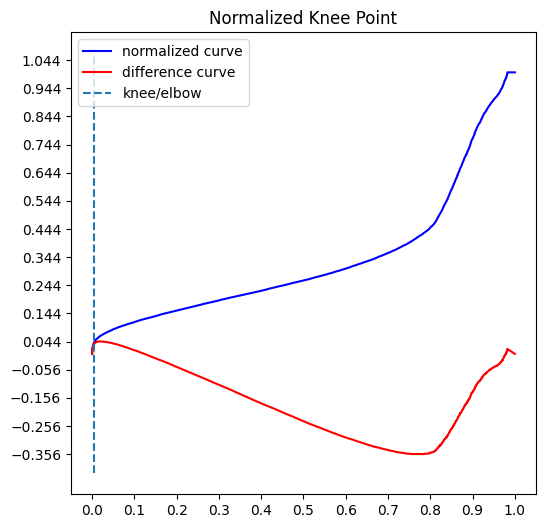

In [124]:
"""
Firstly, I need to define optimal value of eps
Use for check part of vacancy dataset too

One way to find the best eps for DBSCAN is to compute the knn, then sort the distances and see where the "knee" is located
"""
neighbors = 6

nbrs = NearestNeighbors(n_neighbors=neighbors).fit(tsvd_matrix)
distances, indices = nbrs.kneighbors(tsvd_matrix)
ns = len(distances[:][0]) # number of samples
distance_desc = sorted(distances[:, ns-1], reverse=True)

# Plotting K-distance Graph
kneedle = KneeLocator(range(1,len(distance_desc)+1),
                      distance_desc, # y values
                      S=1.0, #parameter suggested from paper
                      curve="convex", #parameter from figure
                      direction="decreasing") #parameter from figure

kneedle.plot_knee_normalized()
print(f"\nThe optimal number of eps: {kneedle.knee_y}")

I choose the elbow value, the value of epsilon where there is maximum curvature. Here is around 1.19. **But** when I used this value for train DBSCAN model I've got only ONE cluster. It is not our goal, we should get lower level for eps in order to decrease number of examples in cluster. 

That's why I decided to check one more time different values of eps and minPts parameters with for loop.

In [125]:
"""
Hyperparameter optimization by for loop
- eps is a distance measure that will be used to locate the points in the neighborhood of any point.
- min_samples is the fewest number of points required to form a cluster
"""
t0 = time()

min_samples = np.arange(5, 21, 5)
eps = np.arange(0.2, 0.6, 0.1) # returns array of ranging from 0.2 to 0.6 with step of 0.1

output_eps = []

for ms in min_samples:
    for ep in eps:
        labels = DBSCAN(min_samples=ms, eps = ep, metric="cosine").fit(tsvd_matrix).labels_
        score = silhouette_score(tsvd_matrix, labels)
        output_eps.append((ms, ep, score))

        
# Get the parameters for best silhouette score
min_samples, eps, score = sorted(output_eps, key=lambda x:x[-1])[-1]
print(f"Best silhouette_score: {round(score, 3)}")
print(f"min_samples: {min_samples}")
print(f"eps: {(round(eps, 1))}")

print(f"\nHyperparameters optimization done in {time() - t0:.3f} s")

Best silhouette_score: 0.034
min_samples: 10
eps: 0.4

Hyperparameters optimization done in 1102.532 s


The model has 0.034 maximum average silhouette score with epsilon = 0.4 and min_sample = 10.
* min_samples' values [5,10,15,20]
* eps' values [0.2, 0.3, 0.4, 0.5]

So, now I'm ready to compare 3 clustering models based on the **Silhouette score** value

In [126]:
# apply kmeans algorithm
t0 = time()

kmeans_model = KMeans(n_clusters=45, init="k-means++", n_init=10, random_state=RANDOM_SEED)
kmeans_train = kmeans_model.fit(tsvd_matrix)
print(f"\nModel running done in {time() - t0:.3f} s")


Model running done in 82.333 s


In [127]:
# apply agglomerative algorithm
t0 = time()

agglo_model = AgglomerativeClustering(linkage="ward", n_clusters=45)
agglomerative_clusters = agglo_model.fit_predict(tsvd_matrix)
print(f"\nModel running done in {time() - t0:.3f} s")


Model running done in 392.062 s


In [128]:
# apply DBSCAN algorithm: When dealing with texts, the distance metric to be used is cosine instead of "euclidean"
t0 = time()

model_dbscan = DBSCAN(eps=0.4, min_samples=10, metric="cosine")
dbscan_clusters = model_dbscan.fit_predict(tsvd_matrix)

print(f"\nModel running done in {time() - t0:.3f} s")


Model running done in 34.617 s


In [129]:
def silhouette_method(df, algo, pred_clusters):
  print("=================================================================================")
  print(f"Clustering: {algo}  Silhouette score: {silhouette_score(df, pred_clusters)}")


silhouette_method(tsvd_matrix, "KMeans", kmeans_model.labels_)
silhouette_method(tsvd_matrix, "Agglomerative", agglomerative_clusters)
silhouette_method(tsvd_matrix, "DBSCAN", dbscan_clusters)
print("=================================================================================")

Clustering: KMeans  Silhouette score: 0.09857381824936473
Clustering: Agglomerative  Silhouette score: 0.09320681423717034
Clustering: DBSCAN  Silhouette score: 0.03353131504791887


The highest value of *silhouette score* belongs to K-means. I can choose it for further work.

In [130]:
"""
Save kmeans model
"""
with open("./kmeans_model.pickle", "wb") as pkl_file: # "model/kmeans_model.pickle"
    pickle.dump(kmeans_train, pkl_file)

## For, loading the final model
# with open("./kmeans_model.pickle", "rb") as pkl_file:
#     model_kmeans = pickle.load(pkl_file)

***

### Get clusters based on the K-means algorithm

In the previous step I run the clustering algorithms on some part of the dataset (stratified). The reason of this decesion is simple: using full dataset took a lot of time at the stage of checking optimal number of clusters (hours and hours...).

Now I have optimal number of clusters - 45 and trained K-Means model. My next step is to predict clusters of the full dataset in order to use it for recommendation engine. I need to get the same format/ shape of full data as fitted data for kmeans model. That's why I use TF-IDF vectoriser and TruncatedSVD were trained in the previous step.

In [131]:
# Let's vectorize our full data: TfIdf -> TruncatedSVD
t0 = time()

job_tfidf = tfidf_train.transform(vacancies_final["Job_title_and_desc"])
vacancy_svd = tsvd_train.transform(job_tfidf)
display(vacancy_svd.shape)
print(f"\nVectorizing and dimension reduction done in {time() - t0:.3f} s")

(55153, 2588)


Vectorizing and dimension reduction done in 16.871 s


In [132]:
"""
Let's run fitted kmeans++ model with 55 clusters
"""
t0 = time()

kmeans_cluster = (kmeans_train.predict(vacancy_svd)).tolist()# fit the vectors using KMeans
print(f"\nModel running done in {time() - t0:.3f} s")


Model running done in 0.375 s


In [133]:
# examine the cluster shape
kmeans_train.cluster_centers_.shape

(45, 2588)

We can see by looking at the shape of the cluster_centers we have 45 clusters that have a dimension space of 2,588.

Next I'll create a new column in vacancies dataframe that has the value for the cluster that each response was assigned to. This allows to do some investigating, which I will do next.

In [134]:
# assign labels as an additional dataframe column
vacancies_final["kmeans_cluster"] = kmeans_cluster

# Display number of documents in each cluster
vacancies_final["kmeans_cluster"].value_counts()

kmeans_cluster
5     25300
19     2855
13     2429
6      1940
7      1662
27     1626
1      1616
16     1572
41     1233
10      964
14      939
29      925
20      905
8       849
31      847
12      829
32      709
0       691
42      532
35      502
23      488
36      445
11      440
24      424
26      387
39      380
21      378
28      366
17      325
2       301
34      266
9       247
43      247
44      220
3       192
18      188
15      150
40      134
25      127
4       111
33      108
37      101
30       87
38       85
22       31
Name: count, dtype: int64

In [135]:
# Print a sample of 3 documents that belong to 3 clusters
for c in vacancies_final["kmeans_cluster"].value_counts().index[:3] :
    print("CLUSTER ", c , " :")
    print("----")
    for d in vacancies_final.loc[vacancies_final["kmeans_cluster"]==c,:].sample(3)["job_desc_lem"]:
        print(d)
        print()
    print("-----------")

CLUSTER  5  :
----
attendant uniform control wynn resort fortune company led hospitality industry visionary steve wynn currently operating top casino gaming market world wynn financially stable growth oriented employee wynn la vega encore property helped win forbes travel five star award independent hotel company world wynn resort known innovative design luxury offering exceptional guest service joining wynn mean working leader global resort industry set today standard likely define tomorrow uniform attendant responsible assisting fellow resort employee daily uniform need job responsibility retrieving hanging garment garment bag conveyor scanning dry cleaning laundry helping uniform accessory inventory maintaining clean safe environment

retail zone lead sa retail service looking hire zone lead zone lead responsible supporting area supervisor manager communicating field associate position act ldquo communication gate keeper geographic area assigned zone lead responsible onboarding trai

CLUSTER  5


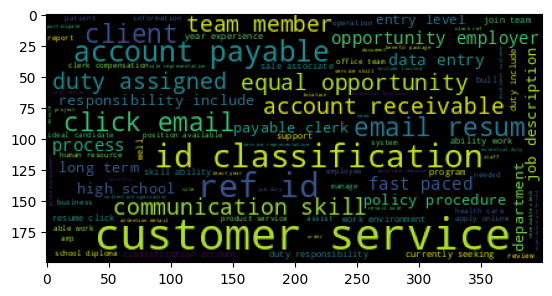

-----------
CLUSTER  19


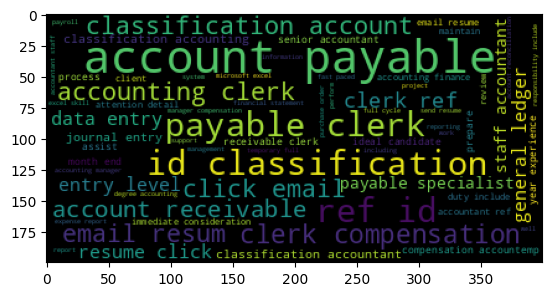

-----------
CLUSTER  13


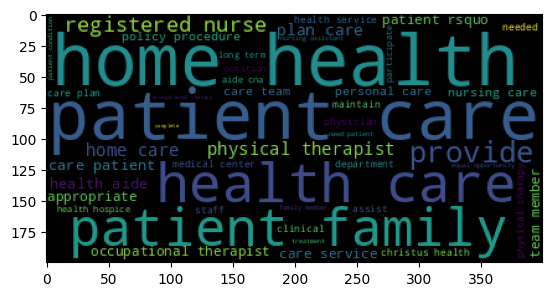

-----------
CLUSTER  6


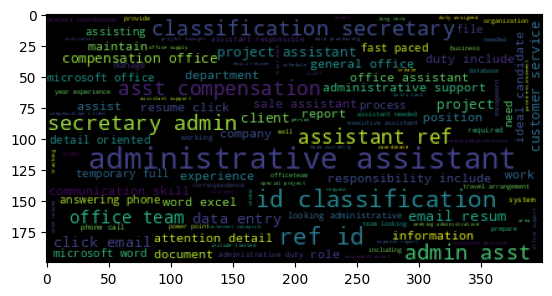

-----------
CLUSTER  7


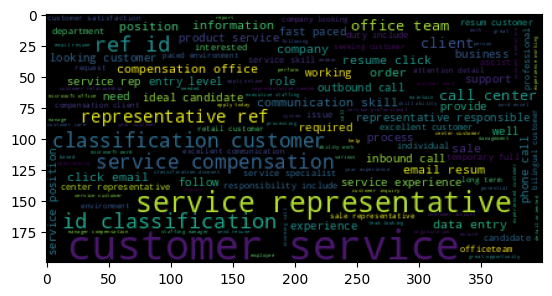

-----------


In [136]:
# Wordcloud for the 5 first clusters
wd = wordcloud.WordCloud()

for c in vacancies_final["kmeans_cluster"].value_counts().index[:5] :
    print("CLUSTER ", c)
    texts = " ".join(vacancies_final.loc[vacancies_final["kmeans_cluster"]==c,"job_desc_lem"])
    cloud = wd.generate(texts)
    plt.imshow(cloud)
    plt.show()
    print('-----------')

In [137]:
total_count = vacancies_final["kmeans_cluster"].count()

cluster = 25300
total_responses = total_count

round(cluster/total_responses, 2)

0.46

About 46% of the job descriptions are assigned to cluster 5 with high value of examples.

If we will increase our k surely some of those would have gone into the additional clusters, but in general a lot of those responses are just difficult to categorize by only focusing on individual words.

### Investigating the Clusters

In [141]:
"""
Let's look at cluster 11
We can see here that in general cluster 11 include job description of job position corresponds to Customer Service Representative
"""
display(vacancies_final[vacancies_final["kmeans_cluster"] == 11][["job_desc_lem", "Job_position"]].iloc[:10])
print("*"*80)
display(vacancies_final[vacancies_final["kmeans_cluster"] == 11][["job_desc_lem", "Job_position"]].iloc[-10:])

,job_desc_lem,Job_position
182,customer service representative needed immedia...,Customer Service Representative needed immedia...
309,customer service representative ref id classif...,Customer Service Representative
323,customer service representative ref id classif...,Customer Service Representative
457,customer service representative ref id classif...,Customer Service Representative
461,customer service representative ref id classif...,Customer Service Representative
748,customer service representative ref id classif...,Customer Service Representative
1258,customer service representative ref id classif...,Customer Service Representative
1350,customer service representative ref id classif...,Customer Service Representative
1358,customer service representative temp week ref ...,Customer Service Representative - temp for a f...
1359,customer service representative ref id classif...,Customer Service Representative


********************************************************************************


,job_desc_lem,Job_position
54083,customer service representative ref id classif...,Customer Service Representative
54093,customer service representative exciting compa...,Customer Service Representative for Exciting C...
54163,customer service representative ref id classif...,Customer Service Representative
54179,customer service representative benefit compan...,Customer Service Representative for Benefits c...
54207,customer service representative ref id classif...,Customer Service Representative
54259,customer service representative supporting sal...,Customer Service Representative supporting Sal...
54282,customer service representative ref id classif...,Customer Service Representative
54458,customer service representative ref id classif...,Customer Service Representative
54462,customer service representative ref id classif...,Customer Service Representative
54524,customer service representative ref id classif...,Customer Service Representative


In [145]:
"""
Let's look at cluster 13

Cluster 13 makes a lot of references to workers from Medicine domain
"""
display(vacancies_final[vacancies_final["kmeans_cluster"] == 13][["job_desc_lem", "Job_position"]].iloc[:10])
print("*"*80)
display(vacancies_final[vacancies_final["kmeans_cluster"] == 13][["job_desc_lem", "Job_position"]].iloc[-10:])

,job_desc_lem,Job_position
41,physical therapist diem jackson north medical ...,Physical Therapist 2- Per Diem
49,patient care technician patient care technicia...,Patient Care Technician
51,mental health technician prn mental health tec...,Mental Health Technician PRN
60,onsite nurse case manager rn augusta ga want i...,Onsite Nurse Case Manager RN - Part Time - Aug...
64,onsite nurse case manager rn staten island ny ...,Onsite Nurse Case Manager RN - Part Time - Sta...
66,site rn case manager racine wi want invent fut...,Part Time On-Site RN Case Manager - Racine WI
67,ot grove grove care wellness center busy skill...,OT - The Grove
72,rn critical care prn act patient advocate us n...,RN Critical Care PRN
83,registrar st mark hospital responsible timely ...,Registrar- St Marks Hospital- part-time
84,registrar coliseum prn parallon prn position n...,Registrar Coliseum PRN - Parallon


********************************************************************************


,job_desc_lem,Job_position
54971,registered nurse general supervision director ...,Registered Nurse
54992,licensed practical nurse provides client profe...,Licensed Practical Nurse
55007,prn occupational therapist shriners hospital c...,PRN Occupational Therapist
55014,wi nurse dungarvin residential based supported...,WI Nurse
55021,rn behavioral health rn work team partner usin...,RN- Behavioral Health
55028,rn pacu prn st. mark outpatient surgery ctr po...,RN PACU PRN - St. Mark's Outpatient Surgery Ctr.
55030,staff nurse prn position summary responsibilit...,Staff Nurse (PRN
55031,outpatient customer service representative pos...,Outpatient Customer Service Representative
55032,patient serv rep onsite ii e location spartanb...,Patient Serv Rep Onsite II- ES
55045,case manager rn hospice prn christus home care...,Case Manager RN- Hospice PRN


In [195]:
"""
Let's look at cluster 9

Cluster 9 makes a lot of references to Account Receivable Specialists
"""
display(vacancies_final[vacancies_final["kmeans_cluster"]==9][["job_desc_lem", "Job_position"]].iloc[:10])
print("*"*80)
display(vacancies_final[vacancies_final["kmeans_cluster"]==9][["job_desc_lem", "Job_position"]].iloc[-10:])

,job_desc_lem,Job_position
377,medical billing professional ref id classifica...,Medical Billing Professional
400,account receivable billing clerk ref id classi...,Accounts Receivable/Billing Clerk
416,billing clerk ref id classification billing cl...,Billing Clerk
427,billing specialist ref id classification accou...,Billing Specialist
1322,billing clerk ref id classification billing cl...,Billing Clerk
1333,junior billing analyst ref id classification b...,Junior Billing Analyst
1555,billing clerk ref id classification billing cl...,Billing Clerk
1816,superior billing specialist needed brentwood r...,Superior Billing Specialist Needed In Brentwood
2341,billing specialist busy multi disciplinary pra...,Billing specialist
2467,billing specialist ref id classification accou...,Billing Specialist


********************************************************************************


,job_desc_lem,Job_position
52690,billing clerk ref id classification billing cl...,Billing Clerk
52746,billing specialist ref id classification billi...,Billing Specialist
52933,billing clerk ref id classification billing cl...,Billing Clerk
53141,billing clerk ref id classification billing cl...,Billing Clerk
53221,billing clerk ref id classification billing cl...,Billing Clerk
53483,billing clerk ref id classification billing cl...,Billing Clerk
53500,billing clerk ref id classification billing cl...,Billing Clerk
54293,billing analyst fortune company ref id classif...,Billing Analyst (Fortune 500 Company!)
54695,billing clerk ref id classification billing cl...,Billing Clerk
54758,billing clerk ref id classification billing cl...,Billing Clerk


In [150]:
"""
Let's look at cluster 33

Cluster 33 makes a lot of references to workers on Kitchen Positions
"""
display(vacancies_final[vacancies_final["kmeans_cluster"]==33][["job_desc_lem", "Job_position"]].iloc[:10])
print("*"*80)
display(vacancies_final[vacancies_final["kmeans_cluster"]==33][["job_desc_lem", "Job_position"]].iloc[-10:])

,job_desc_lem,Job_position
14,hiring kitchen position experienced line cook ...,Hiring Kitchen Positions - Experienced Line Cooks
2597,hiring experienced cook line prep grill steer ...,Hiring Experienced Cooks - Line - Prep - Grill
5578,hiring kitchen position cook dishwasher steer ...,Hiring Kitchen Positions - Cooks - Dishwashers
5609,hiring restaurant position host staff cook ste...,Hiring Restaurant Positions - Host Staff - Cooks
6922,waiter waitress server bartender host hostess ...,"Waiter, Waitress, Server, Bartender, Host, Hos..."
6923,waiter waitress server bartender host hostess ...,"Waiter, Waitress, Server, Bartender, Host, Hos..."
6924,waiter waitress server bartender host hostess ...,"Waiter, Waitress, Server, Bartender, Host, Hos..."
10530,hiring kitchen position line prep cook steer s...,Hiring Kitchen Positions - Line & Prep Cooks
10531,hiring restaurant position server cook host st...,Hiring Restaurant Positions - Servers - Cooks...
10632,hiring restaurant position host staff cook dis...,Hiring Restaurant Positions - Host Staff - Co...


********************************************************************************


,job_desc_lem,Job_position
51538,hiring restaurant position server cook dishwas...,Hiring Restaurant Positions - Servers - Cooks ...
51540,hiring kitchen position cook dishwasher steer ...,Hiring All Kitchen Positions - Cooks - Dishwas...
51541,server assistant host hostess steer success lo...,Server Assistants - Hosts - Hostesses
51543,hiring kitchen position cook dishwasher steer ...,Hiring All Kitchen Positions - Cooks - Dishwas...
51557,hiring restaurant position server cook bartend...,Hiring All Restaurant Positions - Servers - Co...
51823,hiring kitchen position line cook steer succes...,Hiring Kitchen Positions - Line Cooks
52503,hiring kitchen position cook dishwasher steer ...,Hiring All Kitchen Positions - Cooks - Dishwas...
52579,hiring restaurant position server cook bartend...,Hiring All Restaurant Positions - Servers - Co...
52586,hiring restaurant position server cook bartend...,Hiring All Restaurant Positions - Servers - Co...
52590,hiring restaurant position server cook bartend...,Hiring All Restaurant Positions - Servers - Co...


### Data visualization: dimensionality reduction with TSNA

In [151]:
t0 = time()

tsne = TSNE(verbose=1, perplexity=50)  # Changed perplexity from 100 to 50 per FAQ
job_tsne = tsne.fit_transform(vacancy_svd)

print(f"\nDimensionality reduction with TSNE done in {time() - t0:.3f} s")

[t-SNE] Computing 151 nearest neighbors...
[t-SNE] Indexed 55153 samples in 0.111s...
[t-SNE] Computed neighbors for 55153 samples in 264.767s...
[t-SNE] Computed conditional probabilities for sample 1000 / 55153
[t-SNE] Computed conditional probabilities for sample 2000 / 55153
[t-SNE] Computed conditional probabilities for sample 3000 / 55153
[t-SNE] Computed conditional probabilities for sample 4000 / 55153
[t-SNE] Computed conditional probabilities for sample 5000 / 55153
[t-SNE] Computed conditional probabilities for sample 6000 / 55153
[t-SNE] Computed conditional probabilities for sample 7000 / 55153
[t-SNE] Computed conditional probabilities for sample 8000 / 55153
[t-SNE] Computed conditional probabilities for sample 9000 / 55153
[t-SNE] Computed conditional probabilities for sample 10000 / 55153
[t-SNE] Computed conditional probabilities for sample 11000 / 55153
[t-SNE] Computed conditional probabilities for sample 12000 / 55153
[t-SNE] Computed conditional probabilities for 

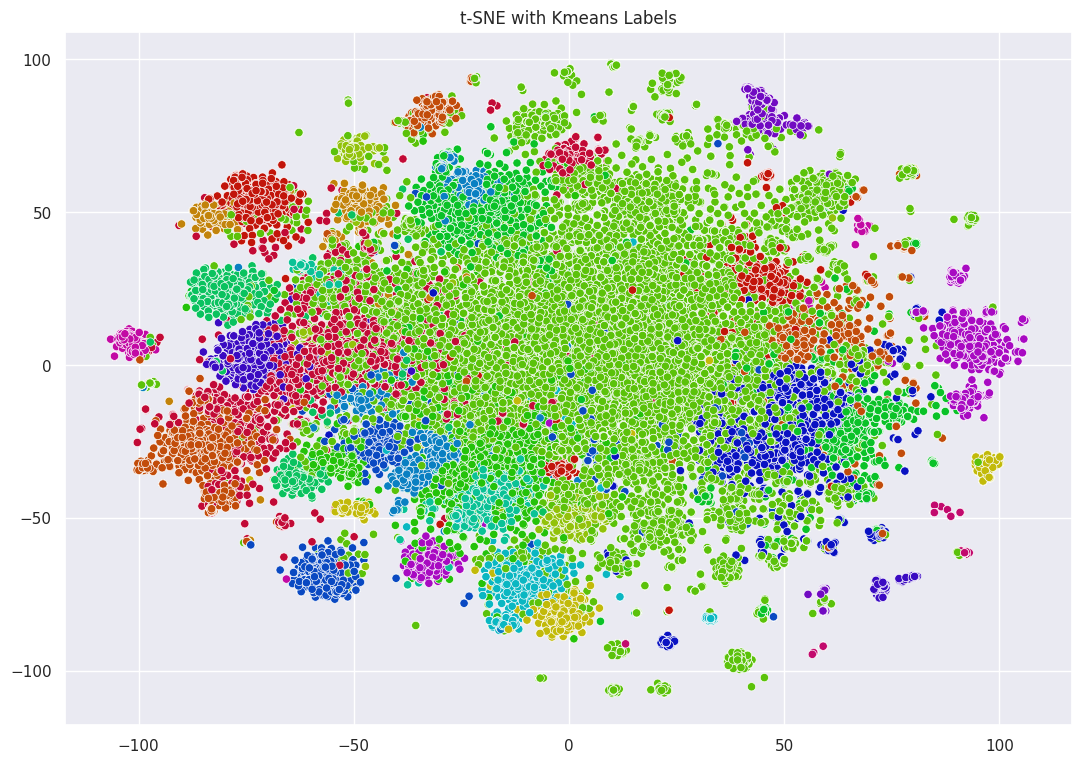

In [152]:
clusters_kmeans = vacancies_final["kmeans_cluster"]

# sns settings
sns.set(rc={"figure.figsize":(13,9)})

# colors
palette = sns.hls_palette(20, l=.4, s=.9)

# plot
sns.scatterplot(x=job_tsne[:,0], y=job_tsne[:,1], hue=clusters_kmeans, legend=False, palette=palette)
plt.title("t-SNE with Kmeans Labels")
plt.show()

The labeled plot gives better insight into how the job descriptions are grouped.

Now there are cases where the colored labels are spread out on the plot. This is a result of t-SNE and k-means finding different connections in the higher dimensional data. The topics of these job descriptions often intersect so it was hard to cleanly separate them.

Also, I see that there are ONE big topic. I guess that it presents job examples from the same industry: Office workers. It could be administrative assistant, customer service representative, etc. Yes these job positions are different, but anyway they are closer to each other than to job position from Medicine or Science domain.

Based on these findings, maybe it has more sense to use less number of clusters. I want to use for this purpose Topic modeling technique - Non-Negative Matrix Factorization (NMF). Let's go to see how does it work.

***

## <p style="text-align:center;font-size:100%;">Recommendation based on TF-IDF + KMeans algorithm</p>

In [153]:
resume_for_kmeans = resume_final.copy()
resume_for_kmeans.head(2)

,Applicant_ID,Job_title,Job_description
0,2,Writer for the Uloop Blog Volunteer,"* Wrote articles for the ""Uloop Blog,"" which i..."
1,38,Sales Person & Phone Receptionist,Asking customer if they need any assistance an...


In [154]:
"""
Predict kmeans model and get clusters for full resume dataset
"""
# Vectorize
resume_tfidf = tfidf_train.transform(resume_for_kmeans["Job_description"])
resume_svd = tsvd_train.transform(resume_tfidf)

# Create clusters
applicant_cluster = (kmeans_train.predict(resume_svd)).tolist()

resume_for_kmeans["kmeans_cluster"] = applicant_cluster
display(resume_for_kmeans.head(2))

,Applicant_ID,Job_title,Job_description,kmeans_cluster
0,2,Writer for the Uloop Blog Volunteer,"* Wrote articles for the ""Uloop Blog,"" which i...",5
1,38,Sales Person & Phone Receptionist,Asking customer if they need any assistance an...,5


In [155]:
"""
Create recommendation of resumes by Job ID
"""
def resumes_to_vacancy_kmeans(job_id):
    # get vacancy id as an index
    v = job_id
    
    if v in vacancies_final["Job_ID"].tolist():
        index = np.where(vacancies_final["Job_ID"] == v)[0][:]
        vacancy_q = vacancies_final.iloc[index[0]:(index[-1]+1)]
        cluster_num = vacancies_final[vacancies_final["Job_ID"] == v]["kmeans_cluster"].iloc[0]
        
        print(f"Information about Vacancy: {v}")
        display(vacancy_q)
        print(f"This vacancy belongs to cluster: {cluster_num}")
        
        # Get resume with the same topic
        pull_of_resumes = resume_for_kmeans[resume_for_kmeans["kmeans_cluster"] == cluster_num]
        
        # Vectorize vacancy's job description and resume
        vacancy_tfidf = tfidf_train.transform(vacancy_q["Job_description"])
        resume_tfidf = tfidf_train.transform(pull_of_resumes["Job_description"])
        
        # compute similarity score
        similarity_score = map(lambda x: linear_kernel(vacancy_tfidf, x), resume_tfidf)
        output = list(similarity_score)
        
        # getting the job id's of the recommendations
        top = sorted(range(len(output)), key=lambda i: output[i], reverse=True)[:10]
        recommendation = pd.DataFrame(columns = ["Job_ID", "Recommended_Applicant_ID"])
        count = 0
        
        for i in top:
            recommendation.at[count, "Job_ID"] = v
            recommendation.at[count, "Recommended_Applicant_ID"] = pull_of_resumes["Applicant_ID"].iloc[i]
            count += 1
            
        # getting the job ids and their data
        nearest_candidates = recommendation["Recommended_Applicant_ID"]
        applicant_recommended = pd.DataFrame(columns = ["Job_ID", "Job_position", "Recommended_Applicant_ID", "Work_experience", "Previous_job"])
        
        for id in nearest_candidates:
            index_resume = pull_of_resumes.index[pull_of_resumes["Applicant_ID"] == id][0]
            # index = np.where(vacancies_final["Job_ID"] == id)[0][0] - different result
            applicant_recommended.at[count, "Job_ID"] = v
            applicant_recommended.at[count, "Job_position"] = vacancies_final[vacancies_final["Job_ID"] == v]["Job_position"].iloc[0]
            applicant_recommended.at[count, "Recommended_Applicant_ID"] = id
            applicant_recommended.at[count, "Work_experience"] = pull_of_resumes["Job_description"][index_resume]
            applicant_recommended.at[count, "Previous_job"] = pull_of_resumes["Job_title"][index_resume]
            count += 1
            
        print(f"\nRecommended Applicant_id for Vacancy {v}\n")
        
    else:
        return ("This Job_ID is not in Vacancies' list")
        
    return applicant_recommended

In [156]:
resumes_to_vacancy_kmeans(129)

Information about Vacancy: 129


,Job_ID,Job_position,Job_description,Job_title_and_desc,job_desc_lem,frequency_job_title,kmeans_cluster
5,129,Receptionist,We are a group of professional massage therapi...,receptionist we are a group of professional...,receptionist group professional massage therap...,806,10


This vacancy belongs to cluster: 10

Recommended Applicant_id for Vacancy 129



,Job_ID,Job_position,Recommended_Applicant_ID,Work_experience,Previous_job
5,129,Receptionist,6403,Receptionist/Office Assistant.,Office Assistant
6,129,Receptionist,10079,"a/p clerk, receptionist, switchboard, payroll",acctspayable clerk
7,129,Receptionist,2803,Helped with data collection for 25 hospitals i...,Information Processing Specialisthttps://www.j...
8,129,Receptionist,10205,"Receptionist, filing, typing briefs, etc",Legal Secretary
9,129,Receptionist,3330,Receptionist/switchboard operator \r\nRetired ...,Receptionist


This recommendation looks better than the previous one based only similarity score value.

***

## 4.3 Topic modeling: Non-Negative Matrix Factorization (NMF)

NMF is an unsupervised technique so there are no labeling of topics that the model will be trained on. The way it works is that, NMF decomposes (or factorizes) high-dimensional vectors into a lower-dimensional representation. These lower-dimensional vectors are non-negative which also means their coefficients are non-negative.

Using the original matrix (A), NMF will give two matrices (W and H). W is the topics it found and H is the coefficients (weights) for those topics. In other words,
* A is job descriptions by words (original),
* H is job descriptions by topics,
* W is topics by words.

NMF will modify the initial values of W and H so that the product approaches A until either the approximation error converges or the max iterations are reached.

In our case, the high-dimensional vectors are going to be tf-idf weights.

#### Automatically Selecting the Best Number of Topics

**Coherence Score**

To evaluate the best number of topics, I can use the coherence score. In general it measures the relative distance between words within a topic.

There are a few different types of coherence score with the two most popular being c_v and u_mass.
* c_v is more accurate while u_mass is faster

We’ll be using c_v here which ranges from 0 to 1 with 1 being perfectly coherent topics.

In sklearn’s implementation of NMF it is possible to use tf-idf weights. However, sklearn’s NMF implementation does not have a coherence score.

Therefore, I’ll use gensim to get the best number of topics with the coherence score and then use that number of topics for the sklearn implementation of NMF.

In [157]:
# Create column: job_description after lemmatization -> token
vacancies_final["token"] = vacancies_final["job_desc_lem"].apply(lambda x: x.split())
vacancies_final.head(2)

,Job_ID,Job_position,Job_description,Job_title_and_desc,job_desc_lem,frequency_job_title,kmeans_cluster,token
0,111,Server,Tacolicious' first Palo Alto store just opened...,server tacolicious' first palo alto store...,server tacolicious first palo alto store opene...,94,0,"[server, tacolicious, first, palo, alto, store..."
1,113,Kitchen Staff/Chef,\r\n\r\nNew French Brasserie in S.F. Financia...,kitchen staff/ chef \r\n\r\n new french ...,kitchen staff chef french brasserie s.f financ...,5,5,"[kitchen, staff, chef, french, brasserie, s.f,..."


In [158]:
# Use Gensim's NMF to get the best num of topics via coherence score
texts = vacancies_final["token"]

# Create a dictionary
# In gensim a dictionary is a mapping between words and their integer id
dictionary = Dictionary(texts)

# Filter out extremes to limit the number of features
dictionary.filter_extremes(
    no_below=3,
    no_above=0.85,
    keep_n=20000
)

In [159]:
# Create the bag-of-words format (list of (token_id, token_count))
corpus = [dictionary.doc2bow(text) for text in texts]

In [160]:
# Create a list of the topic numbers we want to try
topic_nums = list(np.arange(5, 75+1, 5))

In [161]:
# Run the nmf model and calculate the coherence score
# for each number of topics
t0 = time()

coherence_scores = []

for num in topic_nums:
    nmf = Nmf(
        corpus=corpus,
        num_topics=num,
        id2word=dictionary,
        chunksize=2000,
        passes=5,
        kappa=.1,
        minimum_probability=0.01,
        w_max_iter=300,
        w_stop_condition=0.0001,
        h_max_iter=100,
        h_stop_condition=0.001,
        eval_every=10,
        normalize=True,
        random_state=RANDOM_SEED
    )
    
    # Run the coherence model to get the score
    cm = CoherenceModel(
        model=nmf,
        texts=texts,
        dictionary=dictionary,
        coherence="c_v"
    )
    
    coherence_scores.append(round(cm.get_coherence(), 5))
    
print(f"\nCalculating Coherence score for each number of topics done in {time() - t0:.3f} s")


Calculating Coherence score for each number of topics done in 3450.747 s


In [162]:
len(coherence_scores)

15

In [163]:
# Get the number of topics with the highest coherence score
scores = list(zip(topic_nums, coherence_scores))
best_num_topics = sorted(scores, key=itemgetter(1), reverse=True)[0][0]

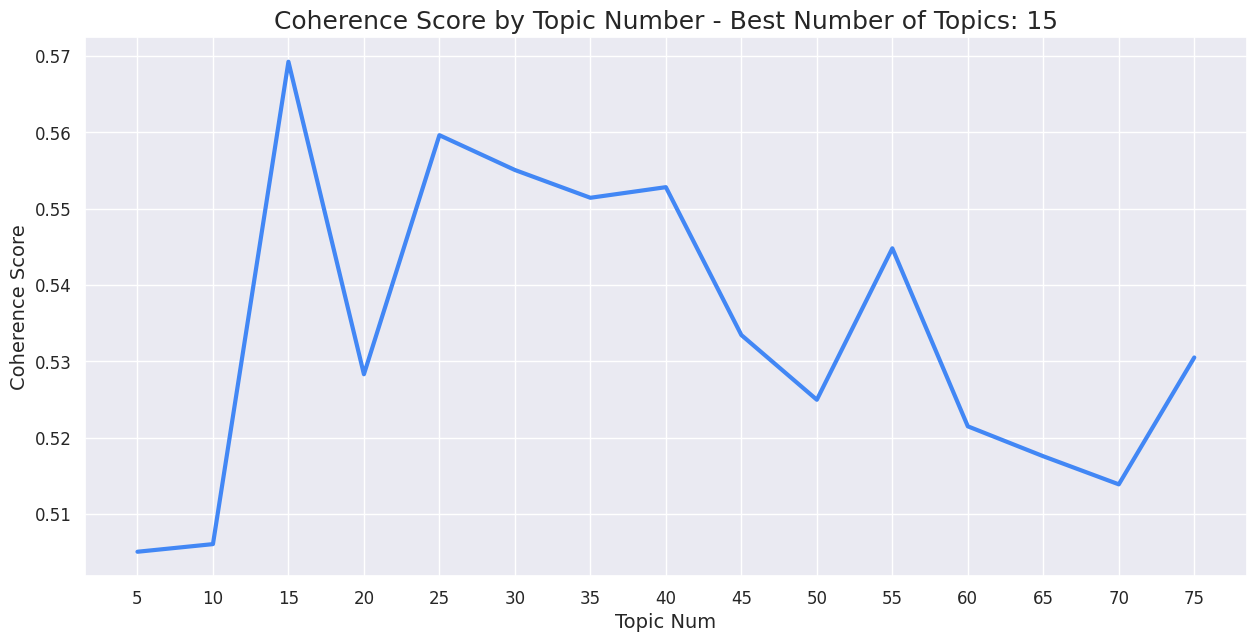

In [164]:
# Plot the results
fig = plt.figure(figsize=(15, 7))

plt.plot(
    topic_nums,
    coherence_scores,
    linewidth=3,
    color="#4287f5"
)

plt.xlabel("Topic Num", fontsize=14)
plt.ylabel("Coherence Score", fontsize=14)
plt.title(f"Coherence Score by Topic Number - Best Number of Topics: {best_num_topics}", fontsize=18)
plt.xticks(np.arange(5, max(topic_nums) + 1, 5), fontsize=12)
plt.yticks(fontsize=12)

plt.show()

For the number of topics to try out, I choose a range of 5 to 100 with a step of 5. This just comes from some trial and error, the number of job descriptions and average length of the job descriptions.

*Running too many topics will take a long time*

**15 is the number of topics** that returned the highest coherence score (more than .57) and it drops off pretty fast after that.

### Summarizing Topics

Another challenge is summarizing the topics.

The best solution here would to have a human go through the texts and manually create topics. This is obviously not ideal.

Another option is to use the words in each topic that had the highest score for that topic and them map those back to the feature names. We’ll use top 10 words.

In [165]:
tfidf_nmf = tfidf_vect.transform(vacancies_final["job_desc_lem"]) # tfidf_vect fitted on full vacancies dataset (after preprocessing)
display(tfidf_nmf)

<55153x14206 sparse matrix of type '<class 'numpy.float64'>'
	with 4049826 stored elements in Compressed Sparse Row format>

In [166]:
best_num_topics = 15

# Save the feature names for later to create topic summaries
tfidf_fn = tfidf_vect.get_feature_names_out()

# Run the nmf model
nmf = NMF(
    n_components=best_num_topics,
    init="nndsvd",
    max_iter=500,
    l1_ratio=0.0,
    solver="cd",
    alpha_W=0.0,
    tol=1e-4,
    random_state=RANDOM_SEED
).fit(tfidf_nmf)

In [167]:
def top_words(topic, n_top_words):
    """
    Function to get top words in each topic
    """
    return topic.argsort()[:-n_top_words - 1:-1] 


def topic_table(model, feature_names, n_top_words):
    """
    Function to get df with topics and top words
    """
    topics = {}
    for topic_idx, topic in enumerate(model.components_):
        t = (topic_idx)
        topics[t] = [feature_names[i] for i in top_words(topic, n_top_words)]
        
    return pd.DataFrame(topics)

In [168]:
"""
Use the top words for each cluster by tfidf weight to create 'topics'
"""

# Getting a df with each topic by document
docweights = nmf.transform(tfidf_vect.transform(vacancies_final["job_desc_lem"]))

n_top_words = 10

topic_df = topic_table(
    nmf,
    tfidf_fn,
    n_top_words
).T

# Cleaning up the top words to create topic summaries
topic_df["topics"] = topic_df.apply(lambda x: [", ".join(x)], axis=1) # Joining each word into a list
topic_df["topics"] = topic_df["topics"].apply(lambda x: list(set(x)))  # Removing duplicate words
topic_df["topics"] = topic_df["topics"].str[0] # Removing the list brackets

topic_df.head()

,0,1,2,3,4,5,6,7,8,9,topics
0,work,security,student,job,required,ability,program,duty,maintain,assigned,"work, security, student, job, required, abilit..."
1,home,bayada,care,health,nurse,aide,nursing,child,lpn,comfort,"home, bayada, care, health, nurse, aide, nursi..."
2,payable,account,clerk,invoice,receivable,vendor,check,matching,accountemps,ref,"payable, account, clerk, invoice, receivable, ..."
3,assistant,administrative,office,admin,secretary,asst,executive,compensation,ref,classification,"assistant, administrative, office, admin, secr..."
4,accountant,staff,reconciliation,accounting,senior,ledger,financial,tax,journal,end,"accountant, staff, reconciliation, accounting,..."


In [169]:
# Create a df with only the created topics and topic num
topic_df = topic_df["topics"].reset_index()
topic_df.columns = ["topic_nmf", "topics"]

topic_df

,topic_nmf,topics
0,0,"work, security, student, job, required, abilit..."
1,1,"home, bayada, care, health, nurse, aide, nursi..."
2,2,"payable, account, clerk, invoice, receivable, ..."
3,3,"assistant, administrative, office, admin, secr..."
4,4,"accountant, staff, reconciliation, accounting,..."
5,5,"customer, service, representative, call, cente..."
6,6,"data, entry, clerk, office, level, ref, classi..."
7,7,"receptionist, front, desk, switchboard, office..."
8,8,"payroll, administrator, processor, processing,..."
9,9,"sale, product, marketing, store, event, retail..."


* Topic 0: work for students (maybe it is about intern level positions)
* Topics 1 and 14 includes words related to the field of Medicine
* Topic 3: words from this topic describe Office workers
* Topic 6: words from this topic describe Dаta entry specialist
* Topic 5, 7: words from these topics describe Front Desk Representative (CSR)
* Topic 9: words from this topic describe Retail positions
* Topics 2, 4, 8, 10-12 includes words related to the field of Finance
* Topic 13: words from this topic describe Kitchen positions

In [170]:
# Creating a temp df with the job_id and topic num to join on
job_id = vacancies_final["Job_ID"].tolist()

df_temp = pd.DataFrame({
    "Job_ID": job_id,
    "topic_nmf": docweights.argmax(axis=1)
})

df_temp["topic_nmf"].nunique()

15

In [171]:
# Merging to get the topic num with url
merged_topic = df_temp.merge(
    topic_df,
    on="topic_nmf",
    how="left"
)

merged_topic

,Job_ID,topic_nmf,topics
0,111,13,"bull, cook, italian, server, restaurant, hirin..."
1,113,0,"work, security, student, job, required, abilit..."
2,117,13,"bull, cook, italian, server, restaurant, hirin..."
3,121,13,"bull, cook, italian, server, restaurant, hirin..."
4,127,4,"accountant, staff, reconciliation, accounting,..."
...,...,...,...
55148,81,13,"bull, cook, italian, server, restaurant, hirin..."
55149,82,2,"payable, account, clerk, invoice, receivable, ..."
55150,83,13,"bull, cook, italian, server, restaurant, hirin..."
55151,84,13,"bull, cook, italian, server, restaurant, hirin..."


In [172]:
# Merging with the original df
vacancies_final = pd.merge(
    vacancies_final,
    merged_topic,
    on="Job_ID",
    how="left"
)

vacancies_final.head()

,Job_ID,Job_position,Job_description,Job_title_and_desc,job_desc_lem,frequency_job_title,kmeans_cluster,token,topic_nmf,topics
0,111,Server,Tacolicious' first Palo Alto store just opened...,server tacolicious' first palo alto store...,server tacolicious first palo alto store opene...,94,0,"[server, tacolicious, first, palo, alto, store...",13,"bull, cook, italian, server, restaurant, hirin..."
1,113,Kitchen Staff/Chef,\r\n\r\nNew French Brasserie in S.F. Financia...,kitchen staff/ chef \r\n\r\n new french ...,kitchen staff chef french brasserie s.f financ...,5,5,"[kitchen, staff, chef, french, brasserie, s.f,...",0,"work, security, student, job, required, abilit..."
2,117,Bartender,We are a popular Mediterranean wine bar and re...,bartender we are a popular mediterranean w...,bartender popular mediterranean wine bar resta...,16,5,"[bartender, popular, mediterranean, wine, bar,...",13,"bull, cook, italian, server, restaurant, hirin..."
3,121,Server,● Serve food/drinks to customers in a profess...,server ● serve food/drinks to customers in...,server serve food drink customer professional ...,94,0,"[server, serve, food, drink, customer, profess...",13,"bull, cook, italian, server, restaurant, hirin..."
4,127,Kitchen Staff/Chef,"Located at the heart of Hollywood, we are one ...",kitchen staff/ chef located at the heart o...,kitchen staff chef located heart hollywood pop...,5,5,"[kitchen, staff, chef, located, heart, hollywo...",4,"accountant, staff, reconciliation, accounting,..."


In [173]:
vacancies_final["topic_nmf"].value_counts(normalize=True)

topic_nmf
0     0.157290
14    0.142531
3     0.110039
5     0.089025
9     0.073233
10    0.062698
4     0.054539
1     0.050006
13    0.049444
12    0.047160
7     0.042808
2     0.038928
6     0.035411
11    0.025021
8     0.021866
Name: proportion, dtype: float64

* Cluster 0 is the most "popular": 
* Cluster 8 is the least "popular":
* At the first glance, the distribution of examples on different topics looks close to the real one.

In [174]:
# Showing the 3 matrices we get with nmf
A = tfidf_vect.transform(vacancies_final["job_desc_lem"])
W = nmf.components_
H = nmf.transform(A)

print('A = {} x {}'.format(A.shape[0], A.shape[1]))
print('W = {} x {}'.format(W.shape[0], W.shape[1]))
print('H = {} x {}'.format(H.shape[0], H.shape[1]))

A = 55153 x 14206
W = 15 x 14206
H = 55153 x 15


* A is job description by words (original) = 55,153 documents * 14,206 unique words
* H is job description by topics = 55,153 documents * 15 topics
* W is topics by words = 15 topics * 14,206 unique words

So assuming 55,153 documents, 14,206 words and 15 topics we would get the following 3 matrices

## Exploring topics

In [175]:
# Office workers, Support services
display(vacancies_final[vacancies_final["topic_nmf"] == 0]["Job_position"].iloc[:10])
print("*"*80)
display(vacancies_final[vacancies_final["topic_nmf"] == 0]["Job_position"].iloc[-10:])

1                                    Kitchen Staff/Chef
7                                                Driver
11          Flex (Part Time) Merchandiser - Mullins, SC
12                                Child Psychotherapist
15                                     HR Administrator
22    Retail Administrative Support Team, Part Time:...
23                                Teaching Opportunties
29    Macy’s Seasonal Retail Stock Receiving, Part T...
32    Intern - Network SharePoint Web Development In...
34                                Director of Campaigns
Name: Job_position, dtype: object

********************************************************************************


55029                              Coin Teller
55037        General Manufacturing (Part Time)
55040                Guest Room Attendant (PT)
55041                   Casino Porter-EVS (PT)
55042            Information Technology Intern
55043    Devereux Gardens - Driver - Part Time
55056                     Research Interviewer
55100             Entry Level Security Officer
55111                                   Driver
55114                                   Driver
Name: Job_position, dtype: object

In [176]:
# Retail (Outliers as Sushi Chef)
display(vacancies_final[vacancies_final["topic_nmf"] == 5]["Job_position"].iloc[:10])
print("*"*80)
display(vacancies_final[vacancies_final["topic_nmf"] == 5]["Job_position"].iloc[-10:])

25                      Inbound and Outbound Call Center
52                   Part-time Data Management Associate
68     Senior CSR / Teller - Rockford West BC - Part ...
106                     Seasonal Delivery Representative
111                           Client Service Coordinator
124                             Customer Care Specilaist
143                      Customer Service Representative
145         Retail Sales Associate / Cashier - (Boulder)
146    SPORTS AUTHORITY - Now Hiring Retail Sales / C...
153         Operations Supervisor, Part-Time-UPS Freight
Name: Job_position, dtype: object

********************************************************************************


54961            Housekeeping / Janitor / Custodian
54980                Customer Service Administrator
54981          Part-Time Driver/Warehouse Associate
55027                                 VMI ASSOCIATE
55031    Outpatient Customer Service Representative
55063                                 Store Manager
55064                          Sales Representative
55084                              Customer Service
55086                                       Cashier
55097                                    Sushi Chef
Name: Job_position, dtype: object

In [177]:
# Medicine
display(vacancies_final[vacancies_final["topic_nmf"] == 14]["Job_position"].iloc[:10])
print("*"*80)
display(vacancies_final[vacancies_final["topic_nmf"] == 14]["Job_position"].iloc[-10:])

28    TriStar Centennial Medical Center - Registered...
31                              Registered Nurses - RNs
41                       Physical Therapist 2- Per Diem
49                              Patient Care Technician
50                                        Staff Nurse I
51                         Mental Health Technician PRN
54    Registered Nurse (RN) / Licensed Practical Nur...
55                                      Medication Aide
58    Emergency Room Registrar - 3rd shift - Chandle...
59              Emergency Room Registrar - Chandler, AZ
Name: Job_position, dtype: object

********************************************************************************


55021                                RN- Behavioral Health
55028     RN PACU PRN - St. Mark's Outpatient Surgery Ctr.
55030                                     Staff Nurse (PRN
55032                       Patient Serv Rep Onsite II- ES
55044                                                   RN
55045                         Case Manager RN- Hospice PRN
55046    MRI Technologist - 0.2FTE, Saturday Shift - Me...
55047    Monitor Technician - 0.9FTE/Nights - Cardiac U...
55055    CNA Certified Nursing Assistant - Nursing Home...
55057                           RN PRN/ psych kids/ varies
Name: Job_position, dtype: object

In [190]:
"""
Save nmf model
"""
with open("./nmf_model.pickle", "wb") as pkl_file: # "model/nmf_model.pickle"
    pickle.dump(nmf, pkl_file)

## For, loading the final model
# with open("./nmf_model.pickle", "rb") as pkl_file:
#     model_nmf = pickle.load(pkl_file)

## <center> Recommendation based on TF-IDF + NMF topic modeling

In [178]:
resume_for_nmf = resume_final.copy()
resume_for_nmf.head(2)

,Applicant_ID,Job_title,Job_description
0,2,Writer for the Uloop Blog Volunteer,"* Wrote articles for the ""Uloop Blog,"" which i..."
1,38,Sales Person & Phone Receptionist,Asking customer if they need any assistance an...


In [179]:
# Predicting the topic for applicant job description
new_texts = resume_for_nmf["Job_description"]

# Transform the new data with the fitted models
tfidf_resume = tfidf_vect.transform(new_texts)
resume_nmf = nmf.transform(tfidf_resume)

In [180]:
# Get the top predicted topic
predicted_topics = [np.argsort(each)[::-1][0] for each in resume_nmf]

# Add to the df
resume_for_nmf["pred_topic_num"] = predicted_topics

resume_for_nmf.head()

,Applicant_ID,Job_title,Job_description,pred_topic_num
0,2,Writer for the Uloop Blog Volunteer,"* Wrote articles for the ""Uloop Blog,"" which i...",0
1,38,Sales Person & Phone Receptionist,Asking customer if they need any assistance an...,5
2,78,Impact team member,"Help maintain merchandise flow, Work on fillin...",9
3,89,Healthcare Specialist / Combat Medic Clerk's h...,"Clinical and field medicine, Healthcare educat...",5
4,96,Cashier Receptionist Cashiet/Waiter,Greeting people and introducing/recommend food...,7


In [181]:
resume_for_nmf["pred_topic_num"].value_counts()

pred_topic_num
0     770
13    277
5     268
9     264
3     132
6     111
14    111
7     104
10     85
8      50
1      48
4      44
11     22
2      15
12     12
Name: count, dtype: int64

In [182]:
# Join with the original df to get the topic summary
resume_for_nmf = pd.merge(
    resume_for_nmf,
    vacancies_final[["topic_nmf", "topics"]],
    left_on="pred_topic_num",
    right_on="topic_nmf",
    how="inner"
).drop_duplicates().drop(["topic_nmf"], axis=1)

resume_for_nmf.head()

,Applicant_ID,Job_title,Job_description,pred_topic_num,topics
0,2,Writer for the Uloop Blog Volunteer,"* Wrote articles for the ""Uloop Blog,"" which i...",0,"work, security, student, job, required, abilit..."
8675,188,Beauty Advisor Sales Associate,"sell cosmetics,work at register, inventory Sto...",0,"work, security, student, job, required, abilit..."
17350,194,Teacher,Supervised children ages 2-5. Implemented curr...,0,"work, security, student, job, required, abilit..."
26025,208,Hostess Digital Design Intern,*\tAssist with food sales by taking and managi...,0,"work, security, student, job, required, abilit..."
34700,210,Laboratory Assistant,Maintained lab and chemical supplies throughou...,0,"work, security, student, job, required, abilit..."


In [183]:
resume_for_nmf = resume_for_nmf.reset_index(drop=True)
display(resume_for_nmf.iloc[-10:])
print("")
display(resume_for_nmf.shape)

,Applicant_ID,Job_title,Job_description,pred_topic_num,topics
2303,3829,"Sr. Regional Sales Representative Owner, Consu...",Involved in the roll out of the new company re...,2,"payable, account, clerk, invoice, receivable, ..."
2304,4660,Management Consultant,Program Management/Project Management/Account ...,2,"payable, account, clerk, invoice, receivable, ..."
2305,5504,Machine Operator,"Run a Machine12,20",2,"payable, account, clerk, invoice, receivable, ..."
2306,5763,Owner,Run day to day operations. Keep books. Write a...,2,"payable, account, clerk, invoice, receivable, ..."
2307,6028,Aounts Payable Manager,Account payable manager for 40 nursing homes.,2,"payable, account, clerk, invoice, receivable, ..."
2308,7893,Driver Driver Driver,"Local driver, hand delivered all cases and tra...",2,"payable, account, clerk, invoice, receivable, ..."
2309,8016,sales associate,helped customers find what they were looking f...,2,"payable, account, clerk, invoice, receivable, ..."
2310,11460,Office manager,Secretarial staff oversight\r\nClient and Vend...,2,"payable, account, clerk, invoice, receivable, ..."
2311,11595,Senior Category Management Analyst Customer Pl...,Category Captain for Newborn & Infant/Toddler ...,2,"payable, account, clerk, invoice, receivable, ..."
2312,11860,Merchandiser Independent Sales Representative ...,I am currently working in 6 locations within t...,2,"payable, account, clerk, invoice, receivable, ..."


(2313, 5)

In [185]:
# Server, CSR
resume_for_nmf[resume_for_nmf["pred_topic_num"] == 5]["Job_title"].iloc[-15:]

1023                                               Server
1024    Real Estate Agent CEO and Founder Sales Key Ho...
1025    cashier general cleaner sale associate  cashie...
1026    Sales Leader Server/Cashier Youth Care Worker ...
1027    Customer Service Representative Assistant Mana...
1028    Sales Associate  Gym Assistant/ Personal Train...
1029    Paralegal/ Manager Clerk/ Process Server      ...
1030    Office Cleaner Metro-North Office Assistant Re...
1031    ValueCare Compounding Pharmacy Personal Banker...
1032    StrategicPLUS Sales Support Office Manager Mem...
1033                 Call Center Agent Personal Assistant
1034                         Cashier Office Administrator
1035    Deskside Support Customer Service Rep Customer...
1036    Sales Operations Specialist Senior Client Serv...
1037    Customer Service Associate French-Language Con...
Name: Job_title, dtype: object

In [186]:
"""
Create recommendation of resumes by Job ID
"""
def resumes_to_vacancy_nmf(job_id):
    # get vacancy id as an index
    v = job_id
    
    if v in vacancies_final["Job_ID"].tolist():
        index = np.where(vacancies_final["Job_ID"] == v)[0][:]
        vacancy_q = vacancies_final.iloc[index[0]:(index[-1]+1)]
        topic_num = vacancies_final[vacancies_final["Job_ID"] == v]["topic_nmf"].iloc[0]
        
        print(f"Information about Vacancy: {v}")
        display(vacancy_q)
        print(f"This vacancy belongs to topic: {topic_num}")
        
        # Get resume with the same topic
        pull_of_resumes = resume_for_nmf[resume_for_nmf["pred_topic_num"] == topic_num]
        
        # Vectorize vacancy's job description and resume
        vacancy_tfidf = tfidf_vect.transform(vacancy_q["Job_description"])
        resume_tfidf = tfidf_vect.transform(pull_of_resumes["Job_description"])
        
        # compute similarity score
        similarity_score = map(lambda x: linear_kernel(vacancy_tfidf, x), resume_tfidf)
        output = list(similarity_score)
        
        # getting the job id's of the recommendations
        top = sorted(range(len(output)), key=lambda i: output[i], reverse=True)[:10]
        recommendation = pd.DataFrame(columns = ["Job_ID", "Recommended_Applicant_ID"])
        count = 0
        
        for i in top:
            recommendation.at[count, "Job_ID"] = v
            recommendation.at[count, "Recommended_Applicant_ID"] = pull_of_resumes["Applicant_ID"].iloc[i]
            count += 1
            
        # getting the job ids and their data
        nearest_candidates = recommendation["Recommended_Applicant_ID"]
        applicant_recommended = pd.DataFrame(columns = ["Job_ID", "Job_position", "Recommended_Applicant_ID", "Work_experience", "Previous_job"])
        
        for id in nearest_candidates:
            index_resume = pull_of_resumes.index[pull_of_resumes["Applicant_ID"] == id][0]
            # index = np.where(vacancies_final["Job_ID"] == id)[0][0] - different result
            applicant_recommended.at[count, "Job_ID"] = v
            applicant_recommended.at[count, "Job_position"] = vacancies_final[vacancies_final["Job_ID"] == v]["Job_position"].iloc[0]
            applicant_recommended.at[count, "Recommended_Applicant_ID"] = id
            applicant_recommended.at[count, "Work_experience"] = pull_of_resumes["Job_description"][index_resume]
            applicant_recommended.at[count, "Previous_job"] = pull_of_resumes["Job_title"][index_resume]
            count += 1
            
        print(f"\nRecommended Applicant_id for Vacancy {v}\n")
        
    else:
        return ("This Job_ID is not in Vacancies' list")
        
    return applicant_recommended

In [187]:
resumes_to_vacancy_nmf(129)

Information about Vacancy: 129


,Job_ID,Job_position,Job_description,Job_title_and_desc,job_desc_lem,frequency_job_title,kmeans_cluster,token,topic_nmf,topics
5,129,Receptionist,We are a group of professional massage therapi...,receptionist we are a group of professional...,receptionist group professional massage therap...,806,10,"[receptionist, group, professional, massage, t...",7,"receptionist, front, desk, switchboard, office..."


This vacancy belongs to topic: 7

Recommended Applicant_id for Vacancy 129



,Job_ID,Job_position,Recommended_Applicant_ID,Work_experience,Previous_job
10,129,Receptionist,728,"Cashier, restocking items, answering customers...",Cashier
11,129,Receptionist,3432,Daily Receptionist duties such as answering em...,Receptionist Tutor Office Assistant/Senior Lea...
12,129,Receptionist,5721,Check-in and check-out of patients in the pulm...,Scheduling Clerk/Receptionist Business Service...
13,129,Receptionist,14052,"front desk receptionist for mall management, f...",Guest Service Representative Sales Professiona...
14,129,Receptionist,627,I would handle sales and face to face people i...,Sales Associate/Retail Ordering
15,129,Receptionist,2803,Helped with data collection for 25 hospitals i...,Information Processing Specialisthttps://www.j...
16,129,Receptionist,5425,Backup receptionist for front desk/Security Ar...,Clerical Intern Finance DHR Unit Clerk Office ...
17,129,Receptionist,4174,Sub-braze headers for the assembly line Taking...,Brazer cashier machine operator Builder Housek...
18,129,Receptionist,581,Attended customers both in person and over the...,marketing director assistant
19,129,Receptionist,14220,As front desk I checked in guest with amazing ...,Front Desk Clerk Dress Steamer / Assistant


So, our HR specialist has a pull of top-10 resumes corresponds to vacancy ("Receptionist"). His/ her task is to organize meeting to check candidate's skills.

***

### 45 clusters VS 15 topics
I get 45 clusters for K-Means model and 15 topics from NMF topic modeilng. Let's look at the content of our clusters in topics.

In [188]:
clusters_in_topics = vacancies_final.groupby(["topic_nmf", "kmeans_cluster"])["Job_position"].unique()
clusters_in_topics[-50:]

topic_nmf  kmeans_cluster
11         42                                              [Financial Analyst]
           44                                                     [Purchasing]
12         3                           [Accounting Clerk, Property Accountant]
           5                 [Various Job Opportunities, Accounting Instruc...
           6                                             [Project Coordinator]
           8                 [Accounting Clerk in Ottumwa, Accounting Clerk...
           9                 [Accounts Receivable Clerk Needed ASAP!, Accou...
           13                [Patient Registration Clerk Needed for Prestig...
           14                [Accounting Clerk, Accounting Clerk Needed ASA...
           17                [Accounting Clerk - TAX SEASON PROJECT!, Tax C...
           19                [Accounting Professional looking to gain exper...
           20                [Bookkeeper, Part Time Accounting Clerk / Book...
           21             

I see that our topics include clusters with the similar job positions (from the same field). That's why I assume that 15 topics will be enough.

My last step is to create a dataframe with recommended pull of resumes (applicants' id).

***

### Create a dataframe with recommended resume (15 topics)

In [189]:
# get result the best recommendations based on similarity score as pairwise_distances/ or cosine_similarity
recs = pairwise_distances(docweights, resume_nmf, metric="cosine").argsort()

# create empty lists
top_rec_app_ids = []
top_rec_app_positions = []
top_rec_app_resumes = []
top_10_rec_app_ids = []

# get the information about the top recommended resumes to each Vacancies
for rec in recs:
    doc_num = rec[0]
    top_rec_app_ids.append(resume_final["Applicant_ID"].loc[doc_num])
    top_rec_app_positions.append(resume_final["Job_title"].loc[doc_num])
    top_rec_app_resumes.append(resume_final["Job_description"].loc[doc_num])
    top_10_rec_app_ids.append(list(rec[0:10]))

# create dict with updated information about recommended resumes to each Vacancies
rec_dict = {
    "Job_ID": vacancies_final["Job_ID"].tolist(), 
    "Jo_position": vacancies_final["Job_position"].tolist(),
    "top_rec_app_id": top_rec_app_ids,
    "top_rec_app_position": top_rec_app_positions,
    "top_rec_app_resume": top_rec_app_resumes, 
    "top_10_rec_app_ids": top_10_rec_app_ids
}

# create dataframe with recommended resumes
rec_df = pd.DataFrame.from_dict(rec_dict)
rec_df.iloc[:10]

,Job_ID,Jo_position,top_rec_app_id,top_rec_app_position,top_rec_app_resume,top_10_rec_app_ids
0,111,Server,2876,cashier/server,was a cashier for wal mart,"[599, 738, 362, 1381, 682, 270, 1792, 156, 211..."
1,113,Kitchen Staff/Chef,1271,assistance manager,"Open and Close the register, Money handling, S...","[236, 967, 162, 887, 757, 1140, 353, 1033, 352..."
2,117,Bartender,13970,kitchen crew Bobarista,"prep, cook, FIFO, trained, inventory, opening ...","[2113, 114, 555, 29, 1650, 1667, 324, 1890, 46..."
3,121,Server,7193,cashier,"Cashier, runner, cook, server. Serving custome...","[1381, 738, 362, 682, 1792, 599, 1274, 1834, 1..."
4,127,Kitchen Staff/Chef,1932,Spanish Tutor,Tutored an 11th grader in Spanish in preparati...,"[342, 181, 851, 108, 1791, 1959, 1563, 1072, 7..."
5,129,Receptionist,2374,Secretary,"I worked at the front desk greeting costumers,...","[445, 752, 1756, 581, 1811, 151, 848, 263, 120..."
6,131,Server,7193,cashier,"Cashier, runner, cook, server. Serving custome...","[1381, 1792, 682, 738, 362, 1445, 36, 599, 127..."
7,133,Driver,8856,Network Administrator Network Engineer IT Mana...,"Developed system imaging strategy, maintain an...","[1592, 1663, 75, 1596, 350, 830, 2278, 288, 18..."
8,134273,Assistant Store Manager,10783,Merchantdiser,"Resets, setting up new stores, scheduling rese...","[1863, 59, 622, 1001, 2072, 951, 2256, 1946, 1..."
9,134274,Store Associate - Retail Sales (Customer Service),1231,Assistant Manager,"*\tCommunicates clearly, concisely and accurat...","[227, 2276, 1480, 1820, 83, 1601, 2108, 1040, ..."


***

## <center> **FURTHER RESEARCH**

On this project I've tried 3 approaches to build Candidate resume recommendation engine:
- Recommender System based on the similarity score
- Clustering algorithms + RS based on the similarity score
    - K-means, Agglomerative clustering, DBSCAN with optimal number of clusters equals 45
- Topic modeling + RS based on the similarity score
    - NMF with optimal number of clusters equals 15

Based on the quality of recommendation (manually checked) I can conclude that approach with Clustering/ Topic modeling step plays a meaningful role in Recommender system building.


As a **further research step**, I can suggest next points:
- Data:
    * Get more informative dataframe/ use web scraping to get resumes and vacancies full of information in the next segments: education level, industry, requirenments. It's possible to use *industry* feature as class label and build recommender system based on classification models (LSV, NB, etc. + ensembles). Also if we have any *requirenments* in vacany's postings it will be useful to get information about total years of applicant's work experience from start and end date, for example.
    * Manually check the same job positions with different variation of title name and replace it to one "more popular" example
- Text preprocessing:
    * Expanding abbreviations
    * Use the other type of regex to clean text from information about company's site, merged words, etc.
    * Using another type of algorithm for vectorization (word2vec - Skip-Gram or BERT)
    * Using another method to get part-of-speech (with high level of correct tagging).
- Model:
    * Use topic modeling as LSA or LDA. These methods are more suited in domains where data is in "semantic units" like words.
    * Create classification models in order to predict new resumes to corresponded topics.
    * Explore the other approaches of Recommender System in case when we have no any labeled data.

***

## BONUS: sentence_transformers

We can use sentence_transformers in order to get groups of job_titles manually based on the benchmark.

In [191]:
!pip install sentence_transformers

import torch
from sentence_transformers import SentenceTransformer

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 86.0/86.0 kB 2.6 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
  Created wheel for sentence_transformers: filename=sentence_transformers-2.2.2-py3-none-any.whl size=125926 sha256=823a2f79dc5d60bfd33b7c3c3b69287a8e3fbfac882023c12f87922140370ad6
  Stored in directory: /root/.cache/pip/wheels/62/f2/10/1e606fd5f02395388f74e7462910fe851042f97238cbbd902f
Successfully built sentence_transformers


In [192]:
"""
Sentence-transformers model
It maps sentences & paragraphs to a 384 dimensional dense vector space and can be used for tasks like clustering or semantic search
"""
model = SentenceTransformer("sentence-transformers/all-MiniLM-L6-v2")

In [193]:
def cos_sim(a, b):
    # From https://github.com/UKPLab/sentence-transformers/blob/master/sentence_transformers/util.py#L31
    """
    Computes the cosine similarity cos_sim(a[i], b[j]) for all i and j.
    :return: Matrix with res[i][j]  = cos_sim(a[i], b[j])
    """
    if not isinstance(a, torch.Tensor):
        a = torch.tensor(a)

    if not isinstance(b, torch.Tensor):
        b = torch.tensor(b)

    if len(a.shape) == 1:
        a = a.unsqueeze(0)

    if len(b.shape) == 1:
        b = b.unsqueeze(0)

    a_norm = torch.nn.functional.normalize(a, p=2, dim=1)
    b_norm = torch.nn.functional.normalize(b, p=2, dim=1)
    return torch.mm(a_norm, b_norm.transpose(0, 1))

In [194]:
vacancies_test = job_description[["Job.ID", "Position"]]
vacancies_test = vacancies_test.dropna(subset=["Position"])

display(vacancies_test.head())
display(vacancies_test.shape)

,Job.ID,Position
0,111,Server
1,113,Kitchen Staff/Chef
2,117,Bartender
3,121,Server
4,127,Kitchen Staff/Chef


(84090, 2)

In [195]:
vacancies_test["cnt_characters_in_title"] = vacancies_test["Position"].apply(lambda x: len(x))
vacancies_test.head()

,Job.ID,Position,cnt_characters_in_title
0,111,Server,6
1,113,Kitchen Staff/Chef,18
2,117,Bartender,9
3,121,Server,6
4,127,Kitchen Staff/Chef,18


In [196]:
job_titles = []

# delete examples with less than 1 symbol in job title
for el in vacancies_test.loc[vacancies_test["cnt_characters_in_title"] > 1]["Position"].unique():
    job_titles.append(el)

curr_titles = np.array(sorted(job_titles, reverse=True))

curr_embed = model.encode(
        curr_titles,
        batch_size=64,
        show_progress_bar=True
)

Batches:   0%|          | 0/567 [00:00<?, ?it/s]

In [197]:
matrix = cos_sim(curr_embed, curr_embed)
len(matrix)

36245

In [198]:
for i, row in enumerate(matrix):
    break

for el in np.argsort(-row):
    if matrix[i][el] < 0.55: break
    print(curr_titles[el], round(matrix[i][el].item(), 2))

★ RESTAURANT / BAR / RETAIL / CUSTOMER SERVICE EXPERIENCE WANTED ★ 1.0
RESTAURANT / BAR / RETAIL / CUSTOMER SERVICE EXPERIENCE WANTED! 0.8
RESTAURANT / BAR / RETAIL / CUSTOMER SERVICE EXPERIENCE WANTED 0.8
Restaurant or Hospitality Experience Wanted for Sales & Marketing Firm 0.69
Restaurant Customer Service 0.64
Customer Service Or Retail Experience 0.62
Customer Service- Gain Experience Here! 0.61
Restaurant Cook - Prep - Bartender - Barback - Cashier - Server 0.61
ENTRY LEVEL MARKETING MAVERICKS ★ Sales & Marketing ★ 0.6
Servers, Cashiers, Bar & Greeters 0.6
Customer Service/Concierge 0.6
Retail & Customer Service Experience Wanted for Entry Level 0.59
Hiring Restaurant Positions - Servers - Host Staff - Bartenders 0.59
Hiring Restaurant Positions - Servers - Bartenders 0.59
Restaurant / Retail / Bar / Athletic Experience Needed! 0.59
Hiring Restaurant Positions - Servers - Bartenders - Host Staff 0.59
Hiring Restaurant Positions - Servers -  Bartenders - Host Staff 0.59
Hiring Rest

In [199]:
# Pull of job positions on RESTAURANT area
lst1 = """
★ RESTAURANT / BAR / RETAIL / CUSTOMER SERVICE EXPERIENCE WANTED ★ 1.0
RESTAURANT / BAR / RETAIL / CUSTOMER SERVICE EXPERIENCE WANTED! 0.8
RESTAURANT / BAR / RETAIL / CUSTOMER SERVICE EXPERIENCE WANTED 0.8
Restaurant or Hospitality Experience Wanted for Sales & Marketing Firm 0.69
Restaurant Customer Service 0.64
Restaurant Cook - Prep - Bartender - Barback - Cashier - Server 0.61
Servers, Cashiers, Bar & Greeters 0.6
Hiring Restaurant Positions - Servers - Host Staff - Bartenders 0.59
Hiring Restaurant Positions - Servers - Bartenders 0.59
Restaurant / Retail / Bar / Athletic Experience Needed! 0.59
Hiring Restaurant Positions - Servers -  Bartenders - Host Staff 0.59
Hiring Restaurant Positions - Servers - Bartenders - Host Staff 0.59
Hiring Restaurant Positions - Servers - Bussers - Bartenders 0.58
Hiring Restaurant Positions - Servers - Cooks - Bartenders 0.58
Hiring Restaurant Positions - Servers - Hosts - Bartenders 0.58
Restaurant Management Opportunities 0.58
Hiring Restaurant Positions - Servers - Bartender 0.58
Taste Bar Café - Food Sales Associate, Full Time/Part Time: Seattle, WA, Macy’s Downtown Seattle 0.57
Cooks, Servers, Bartenders, Cashiers & Greeters 0.57
Line Cooks, Servers, Cashiers, Bar & Greeters 0.56
Hiring All Restaurant Positions -  Servers - Cooks - Bartenders 0.56
Hiring All Restaurant Positions - Servers -  Cooks - Bartenders 0.56
Hiring All Restaurant Positions - Servers - Cooks - Bartenders 0.56
Hiring All Restaurant Positions - Servers -Cooks - Bartenders 0.56
SERVER / RE STAURANT / HOSPITALITY EXPERIENCE - CUSTOMER RELA TIONS REPS 0.56
Hiring All Restaurant Positions - Servers - Host Staff - Bartenders 0.56
Restaurant Server - Mystic Steakhouse 0.56
Hiring All Restaurant Positions - Cooks - Servers - Bartenders 0.56
Hiring Restaurant Positions - Servers - Barbacks - Host Staff 0.55
Dining Room Server - Restaurant - Los Angeles 0.55
Bartender - Kitchen Service Bar (PT) 0.55
""".split("\n")

# Analyst -> Financial, Marketing and other domain
lst2 = """
~ Click Here ~ Senior Financial Analysts 1.0
Senior Financial Analyst 0.84
Financial Analysts 0.82
Senior Financial Business Analyst 0.77
Financial Analysts needed 0.76
Financial Analysts Needed! 0.76
Junior Financial Analyst 0.76
Calling All Experienced Financial Analysts!! 0.76
Financial  Analyst 0.76
Financial Analyst 0.76
On the Lookout for Accomplished Financial Analysts! 0.75
In need of Financial Analysts 0.75
Financial Analysts Wanted! 0.73
Financial Reporting Analyst 0.73
Financial Analysts - All Levels Needed! 0.73
Searching for All Accurate and Focused Financial Analysts!! 0.72
Searching for Proven Financial Analysts! 0.72
Senior Financial Analyst ~ Apply Now ~ 0.72
Financial Analyst Needed! 0.71
Excellent Opportunities for Financial Analysts 0.71
Senior Business Analyst 0.7
On the Lookout for Dynamic Financial Analysts! 0.7
Proficient Financial Analysts Needed ASAP! 0.7
Financial Analysts Apply Within 0.69
Jr. Financial Analyst 0.69
Success Driven Financial Analysts Needed Now! 0.69
Sr. Financial Analyst Needed! 0.68
Financial/Data Analyst 0.68
Financial Analyst/Pricing Analyst Needed ASAP! 0.67
Sr. Financial Analyst 0.67
Financial Analyst Intern 0.66
Seeking All Skilled and Motived Financial Analysts! 0.66
Entry Level Financial Analyst 0.66
Financial Analyst - Healthcare 0.66
Financial Sales Analyst 0.66
Entry-Level Financial Analyst 0.66
Now Seeking a Financial Analyst! 0.66
Financial Analyst- Wyomissing 0.66
Motivated Financial Analysts Always Wanted!! 0.66
Financial Analyst at Healthcare Organization 0.65
Senior Sales Analyst 0.65
Investment Banking Analyst 0.65
Financial Analyst for a Prestigious Financial Service Firm! 0.64
Financial Analyst- Myerstown 0.64
Financial Analyst  (Advanced Excel) 0.64
Financial Aid Analyst 0.64
Hedge Fund Analyst 0.64
Junior Financial Analyst- Growing Company 0.63
FINANCE BUSINESS ANALYST 0.63
Senior Financial Reporting Manager 0.63
Financial Analyst â Accounting, PT 0.63
Financial Analyst needed for Financial Service firm! 0.63
Financial Analyist 0.63
Financial Analyst - Exciting Opportunity 0.63
Financial Business Analyst II 0.63
Real Estate Investment Firm seeks Financial Analyst! 0.63
Financial Analyst needed for well-known, established Firm! 0.63
Entry Level Corporate Finance Analyst 0.63
Financial Analyst with Advanced Excel 0.62
Senior Accountant - with Financial Edge 0.62
Financial Analyst with exposure to upper management! 0.62
Financial Analyst Needed for Fantastic Opportunity 0.62
Financial Advisor 0.62
Financial Analyst Needed for a fortune 500 company! 0.62
Immediate need for a Financial Analyst 0.62
Analyst Opportunity within the Financial Industy! 0.62
Financial Analyst - Exciting Growing Firm 0.62
Entry Level Financial Data Analyst 0.61
Financial Analyst - Entry Level 0.61
Financial Analyst and Underwriter 0.61
Investment Firm seeks Entry Level Financial Analyst 0.61
Analyst (Data Analyst for Fortune 500 Company!) 0.61
Senior Accountants 0.61
Mortgage Analyst 0.61
Financial Analyst- Morgantown 0.61
Accounting Analyst 0.61
Financial Analyst - HUGE company! 0.6
Senior Accountant - 0.6
SENIOR ACCOUNTANT 0.6
Senior Accountant 0.6
Business Analyst 0.6
Senior Analyst/Accountant at Major Healthcare System 0.6
Junior Financial Analyst Needed for Property Management! 0.6
Financial Aid Analyst/Specialist 0.6
Banking Analyst 0.6
Investor Accountant 0.6
Recent Grads-Accounting & Finance 0.6
Entry Level Investment Analyst 0.59
Data Analyst / Financial Analyst 0.59
Financial Accountant 0.59
IT Finance Reporting & Analystics Intern 0.59
Accounting and Finance Professionals 0.59
Financial Analyst - Automotive (15-00260) 0.59
Financial Specialist 0.59
Financial Reporting Intern 0.59
Financial Asset Liability Management Analyst 0.59
Jr. Business Analyst 0.58
Financial/System/Budget Analyst 0.58
Financial Analyst in North Columbus 0.58
Financial Analyst - South Fort Worth 0.58
Financial Analyst for Software company in Mountain View! 0.58
Financial Analyst/Payroll Associate 0.58
Budget Analyst 0.58
Market Research Analyst 0.58
Mutual Fund Valuation Analyst 0.58
Senior Accountant/Analyst at Prestigious Hospital 0.58
Pricing Analyst 0.57
Intern, Pricing Analyst 0.57
Junior Billing Analyst 0.57
Senior Cost Accountant Wanted - Click here to learn more! 0.57
Mutual Fund Accountant 0.57
Hedge Fund Accountant 0.57
Residential Mortgage Analyst 0.57
Motivated Financial Analyst Needed! 0.57
Sr. Business Analyst 0.57
Entry Level Financial Analyst needed for LA Investment Firm! 0.57
Entry Level Financial Analyst-Strong Excel Needed-Project! 0.57
Mortgage Loan Analyst 0.57
Financial Administrator 0.56
Financial Analyst - Entry Level Opportunity 0.56
College Co-op-Bank Business Analyst 0.56
Financial Analyst Needed in Sandusky 0.56
Financial Analyst in Blue Ash 0.56
Senior Workforce Management and Reporting Analyst 0.56
Executive Assistant - Finance Professional 0.56
Investment Operations Analyst Intern 0.56
Financial Advisor - Investment Advisor 0.56
Financial Planner 0.56
Financial Analyst Needed on the East Side of Indy! 0.56
Entry Level Financial Analyst at exciting DC non-profit 0.56
Financial Reporting Manager 0.56
Intern - Reporting Analyst 0.56
South OKC Company seeking Financial Analyst! 0.56
Administrative Analyst 0.56
Entry Level Investment Operations Analyst 0.56
Marketing Analyst 0.56
Fund Accountant 0.56
Bank Credit Analyst 0.56
Research Analyst 0.55
Purchasing Analyst 0.55
Senior Accountant for High Tech Company 0.55
Highly successful entertainment firm seeks Financial Analyst 0.55
Entry Level Opportunity for Financial Analyst 0.55
Treasury Analyst 0.55
Entry Level Financial Analyst for Non-Profit Organization 0.55
""".split("\n")

## Outliers: CSR from Retail

# Customer Service Or Retail Experience 0.62
# Customer Service- Gain Experience Here! 0.61
# ENTRY LEVEL MARKETING MAVERICKS ★ Sales & Marketing ★ 0.6
# Customer Service/Concierge 0.6
# Retail & Customer Service Experience Wanted for Entry Level 0.59
# Customer Service / Retail (Entry Level) 0.58
# Entry Level Customer Service Opportunity! 0.57
# Experienced Customer Service Individual! 0.57
# ENTRY LEVEL MARKETING/CUSTOMER SERVICE- EVENT PROMOTIONS & RETAIL 0.57
# CUSTOMER SERVICE / RETAIL / SALES 0.56
# Customer Service / Sales ( New Grads Welcome! ) 0.56
# Customer Service Representatives - Part Time Openings! 0.56
# Customer Service Representative Openings! 0.56
# Retail & Customer Service Experience Wanted for Entry Level Management 0.56
# Customer Service/Sales 0.56
# Customer Service / Sales 0.56
# Customer Service - Event / Retail Marketing & Advertising Firm 0.55
# CUSTOMER SERVICE REPRESENTATIVE - Earn & Learn! 0.55
# Customer Experience Specialist 0.55
# .Marketing, Customer Service, Entry Level 0.55

In [200]:
lst = lst1 + lst2 #+lst3 etc
lst = [el.rsplit(" ", 1)[0].strip() for el in lst if el]

In [201]:
# Get new examples of job titles (not in verified list)
job_titles_2 = sorted([sk for sk in sorted(job_titles, reverse=True) if sk not in set(lst)], reverse=True)

print(len(job_titles_2))
print(job_titles_2[:10])

curr_skills = np.array(job_titles_2)

curr_embed = model.encode(
        curr_skills,
        batch_size=64,
        show_progress_bar=True
)

36069
['~~~ OPEN HOUSE / CAREER FAIR~~~', '~ CLICK HERE ~ Accounts Payable Clerk', 'weekend counselor RCALD', 'weekend counselor', 'temporary Ad Operations Coordinator', 'speach therapist', 'sourcing Specialist', 'shipping and receiving clerk', 'shipping and receiving Distribution', 'server']


Batches:   0%|          | 0/564 [00:00<?, ?it/s]

In [202]:
matrix = cos_sim(curr_embed, curr_embed)
len(matrix)

36069

In [203]:
i = 1
row = matrix[i]

for el in np.argsort(-row):
    if matrix[i][el] < 0.55: break
    print(curr_skills[el], round(matrix[i][el].item(), 2))

~ CLICK HERE ~ Accounts Payable Clerk 1.0
Accounts Payable Clerk 0.93
Account Payable Clerk 0.92
Accounts Payable Clerk needed 0.89
Accounts Payable Clerk - Immediate Need! 0.88
Accounts Payable Clerk NEEDED! 0.88
Accounts Payable Clerk Needed! 0.88
Accounts Payable Clerk Needed ASAP! 0.88
Accounts Payable Clerk Now Needed! 0.87
Accounts Payable Clerk now needed! 0.87
Accounts Payable Clerk! 0.87
Accounts Payable Clerk Needed!! 0.86
Accounts Payable Clerk Needed Immediatley 0.86
Accounts Payable/Payroll Clerk 0.86
Accounts Payable Clerk Needed ASAP !!!! 0.85
Accounts Payable/Receivable Clerks 0.85
Accounts Payable / Accounts Receivable Clerk 0.85
Accounts Payable Clerk Needed Immediatley! 0.85
Accounts Payable Clerk Wanted Today 0.84
Immediate need for an Accounts Payable Clerk 0.84
Accounts Payable/Accounting Clerk 0.84
Accounts Payable Clerk WANTED NOW! 0.84
Focused Accounts Payable Clerk 0.83
Temporary Accounts Payable Clerk 0.83
Entry Level Accounts Payable Clerk 0.83
Accounts Paya

#### We can check it manually step by step and formed groups of job title. These Groups can be used as markers for further work.